#### PPO

In [1]:
import shutup
shutup.please()

In [2]:
import numpy as np

from src.agents.agent import Agent
from src.utils.buffer import Buffer
from src.utils.logger import LearningLogger

import scipy.signal
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp

from tensorflow.keras.layers import Input, Dense, Concatenate



In [3]:
import tensorflow as tf
import os
import numpy as np
import random

SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

episode: 1/10000, score: -92.0817066347918, average: -92.08 
episode: 2/10000, score: -72.5787588297583, average: -82.33 
episode: 3/10000, score: -369.5233101941409, average: -178.06 
episode: 4/10000, score: -305.0462108092929, average: -209.81 
episode: 5/10000, score: -126.99246052346963, average: -193.24 
episode: 6/10000, score: -108.50529973876411, average: -179.12 
episode: 7/10000, score: -101.81299673075037, average: -168.08 
episode: 8/10000, score: -123.30878753829121, average: -162.48 
episode: 9/10000, score: -400.1157130762604, average: -188.89 
episode: 10/10000, score: -73.39314082273202, average: -177.34 
episode: 11/10000, score: -165.53781905989644, average: -176.26 
episode: 12/10000, score: -298.42473511593965, average: -186.44 
episode: 13/10000, score: -214.62169224709714, average: -188.61 
episode: 14/10000, score: -295.4376145077164, average: -196.24 
episode: 15/10000, score: -69.74744627858493, average: -187.81 
episode: 16/10000, score: -421.6449900683729, 

KeyboardInterrupt: 

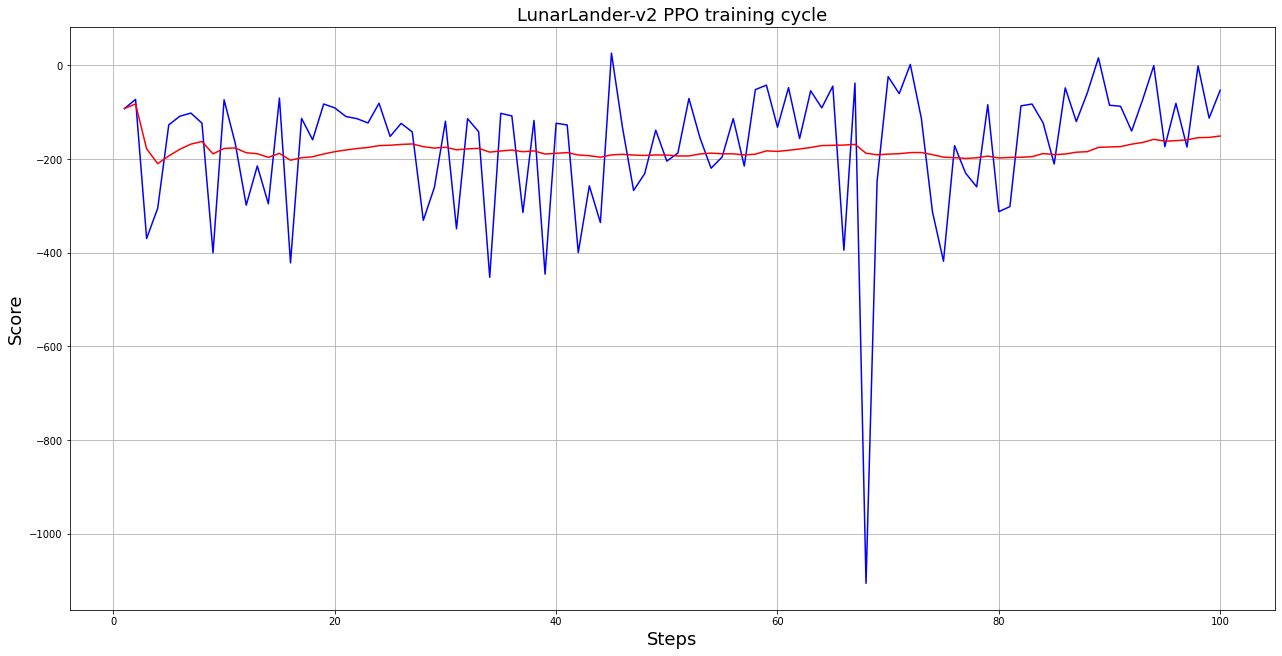

In [11]:

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # -1:cpu, 0:first gpu
import random
import gym
import pylab
import numpy as np
import tensorflow as tf
from tensorboardX import SummaryWriter
#tf.config.experimental_run_functions_eagerly(True) # used for debuging and development
tf.compat.v1.disable_eager_execution() # usually using this for fastest performance
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import copy

from threading import Thread, Lock
from multiprocessing import Process, Pipe
import time

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f'GPUs {gpus}')
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError: pass

class Environment(Process):
    def __init__(self, env_idx, child_conn, env_name, state_size, action_size, visualize=False):
        super(Environment, self).__init__()
        self.env = gym.make(env_name)
        self.is_render = visualize
        self.env_idx = env_idx
        self.child_conn = child_conn
        self.state_size = state_size
        self.action_size = action_size

    def run(self):
        super(Environment, self).run()
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size])
        self.child_conn.send(state)
        while True:
            action = self.child_conn.recv()
            if self.is_render and self.env_idx == 0:
                self.env.render()

            state, reward, done, info = self.env.step(action)
            state = np.reshape(state, [1, self.state_size])

            if done:
                state = self.env.reset()
                state = np.reshape(state, [1, self.state_size])

            self.child_conn.send([state, reward, done, info])


class Actor_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        self.action_space = action_space

        X = Dense(512, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X_input)
        X = Dense(256, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        X = Dense(64, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        output = Dense(self.action_space, activation="softmax")(X)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss, optimizer=optimizer(lr=lr))

    def ppo_loss(self, y_true, y_pred):
        # Defined in https://arxiv.org/abs/1707.06347
        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks

        prob = K.clip(prob, 1e-10, 1.0)
        old_prob = K.clip(old_prob, 1e-10, 1.0)

        ratio = K.exp(K.log(prob) - K.log(old_prob))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

    def predict(self, state):
        return self.Actor.predict(state)


class Critic_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        old_values = Input(shape=(1,))

        V = Dense(512, activation="relu", kernel_initializer='he_uniform')(X_input)
        V = Dense(256, activation="relu", kernel_initializer='he_uniform')(V)
        V = Dense(64, activation="relu", kernel_initializer='he_uniform')(V)
        value = Dense(1, activation=None)(V)

        self.Critic = Model(inputs=[X_input, old_values], outputs = value)
        self.Critic.compile(loss=[self.critic_PPO2_loss(old_values)], optimizer=optimizer(lr=lr))

    def critic_PPO2_loss(self, values):
        def loss(y_true, y_pred):
            LOSS_CLIPPING = 0.2
            clipped_value_loss = values + K.clip(y_pred - values, -LOSS_CLIPPING, LOSS_CLIPPING)
            v_loss1 = (y_true - clipped_value_loss) ** 2
            v_loss2 = (y_true - y_pred) ** 2
            
            value_loss = 0.5 * K.mean(K.maximum(v_loss1, v_loss2))
            #value_loss = K.mean((y_true - y_pred) ** 2) # standard PPO loss
            return value_loss
        return loss

    def predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])

class PPOAgent:
    # PPO Main Optimization Algorithm
    def __init__(self, env_name):
        # Initialization
        # Environment and PPO parameters
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.n
        self.state_size = self.env.observation_space.shape
        self.EPISODES = 10000 # total episodes to train through all environments
        self.episode = 0 # used to track the episodes total count of episodes played through all thread environments
        self.max_average = 0 # when average score is above 0 model will be saved
        self.lr = 0.00025
        self.epochs = 10 # training epochs
        self.shuffle=False
        self.Training_batch = 1000
        #self.optimizer = RMSprop
        self.optimizer = Adam

        self.replay_count = 0
        self.writer = SummaryWriter(comment="_"+self.env_name+"_"+self.optimizer.__name__+"_"+str(self.lr))
        
        # Instantiate plot memory
        self.scores_, self.episodes_, self.average_ = [], [], [] # used in matplotlib plots

        # Create Actor-Critic network models
        self.Actor = Actor_Model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        self.Critic = Critic_Model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        
        self.Actor_name = f"{self.env_name}_PPO_Actor.h5"
        self.Critic_name = f"{self.env_name}_PPO_Critic.h5"

        
    def act(self, state):
        """ example:
        pred = np.array([0.05, 0.85, 0.1])
        action_size = 3
        np.random.choice(a, p=pred)
        result>>> 1, because it have the highest probability to be taken
        """
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.predict(state)[0]
        action = np.random.choice(self.action_size, p=prediction)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        return action, action_onehot, prediction

    def discount_rewards(self, reward):#gaes is better
        # Compute the gamma-discounted rewards over an episode
        # We apply the discount and normalize it to avoid big variability of rewards
        gamma = 0.99    # discount rate
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            running_add = running_add * gamma + reward[i]
            discounted_r[i] = running_add

        discounted_r -= np.mean(discounted_r) # normalizing the result
        discounted_r /= (np.std(discounted_r) + 1e-8) # divide by standard deviation
        return discounted_r

    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.9, normalize=True):
        deltas = [r + gamma * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t + 1]

        target = gaes + values
        if normalize:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, predictions, dones, next_states):
        # reshape memory to appropriate shape for training
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)

        # Get Critic network predictions 
        values = self.Critic.predict(states)
        next_values = self.Critic.predict(next_states)

        # Compute discounted rewards and advantages
        #discounted_r = self.discount_rewards(rewards)
        #advantages = np.vstack(discounted_r - values)
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))
        '''
        pylab.plot(advantages,'.')
        pylab.plot(target,'-')
        ax=pylab.gca()
        ax.grid(True)
        pylab.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.06)
        pylab.show()
        '''
        # stack everything to numpy array
        # pack all advantages, predictions and actions to y_true and when they are received
        # in custom PPO loss function we unpack it
        y_true = np.hstack([advantages, predictions, actions])
        
        # training Actor and Critic networks
        a_loss = self.Actor.Actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=self.shuffle)
        c_loss = self.Critic.Critic.fit([states, values], target, epochs=self.epochs, verbose=0, shuffle=self.shuffle)

        self.writer.add_scalar('Data/actor_loss_per_replay', np.sum(a_loss.history['loss']), self.replay_count)
        self.writer.add_scalar('Data/critic_loss_per_replay', np.sum(c_loss.history['loss']), self.replay_count)
        self.replay_count += 1
 
    def load(self):
        self.Actor.Actor.load_weights(self.Actor_name)
        self.Critic.Critic.load_weights(self.Critic_name)

    def save(self):
        self.Actor.Actor.save_weights(self.Actor_name)
        self.Critic.Critic.save_weights(self.Critic_name)
        
    pylab.figure(figsize=(18, 9))
    pylab.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.06)
    def PlotModel(self, score, episode):
        self.scores_.append(score)
        self.episodes_.append(episode)
        self.average_.append(sum(self.scores_[-50:]) / len(self.scores_[-50:]))
        if str(episode)[-2:] == "00":# much faster than episode % 100
            pylab.plot(self.episodes_, self.scores_, 'b')
            pylab.plot(self.episodes_, self.average_, 'r')
            pylab.title(self.env_name+" PPO training cycle", fontsize=18)
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.grid(True)
                pylab.savefig(self.env_name+".png")
            except OSError:
                pass
        # saving best models
        if self.average_[-1] >= self.max_average:
            self.max_average = self.average_[-1]
            self.save()
            SAVING = "SAVING"
            # decreaate learning rate every saved model
            self.lr *= 0.95
            K.set_value(self.Actor.Actor.optimizer.learning_rate, self.lr)
            K.set_value(self.Critic.Critic.optimizer.learning_rate, self.lr)
        else:
            SAVING = ""

        return self.average_[-1], SAVING
    
    def run(self): # train only when episode is finished
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size[0]])
        done, score, SAVING = False, 0, ''
        while True:
            # Instantiate or reset games memory
            states, next_states, actions, rewards, predictions, dones = [], [], [], [], [], []
            while not done:
                self.env.render()
                # Actor picks an action
                action, action_onehot, prediction = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.env.step(action)
                # Memorize (state, action, reward) for training
                states.append(state)
                next_states.append(np.reshape(next_state, [1, self.state_size[0]]))
                actions.append(action_onehot)
                rewards.append(reward)
                dones.append(done)
                predictions.append(prediction)
                # Update current state
                state = np.reshape(next_state, [1, self.state_size[0]])
                score += reward
                if done:
                    self.episode += 1
                    average, SAVING = self.PlotModel(score, self.episode)
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, score, average, SAVING))
                    self.writer.add_scalar(f'Workers:{1}/score_per_episode', score, self.episode)
                    self.writer.add_scalar(f'Workers:{1}/learning_rate', self.lr, self.episode)
                    
                    self.replay(states, actions, rewards, predictions, dones, next_states)

                    state, done, score, SAVING = self.env.reset(), False, 0, ''
                    state = np.reshape(state, [1, self.state_size[0]])

            if self.episode >= self.EPISODES:
                break
        self.env.close()

    def run_batch(self): # train every self.Training_batch episodes
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size[0]])
        done, score, SAVING = False, 0, ''
        while True:
            # Instantiate or reset games memory
            states, next_states, actions, rewards, predictions, dones = [], [], [], [], [], []
            for t in range(self.Training_batch):
                self.env.render()
                # Actor picks an action
                action, action_onehot, prediction = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.env.step(action)
                # Memorize (state, action, reward) for training
                states.append(state)
                next_states.append(np.reshape(next_state, [1, self.state_size[0]]))
                actions.append(action_onehot)
                rewards.append(reward)
                dones.append(done)
                predictions.append(prediction)
                # Update current state
                state = np.reshape(next_state, [1, self.state_size[0]])
                score += reward
                if done:
                    self.episode += 1
                    average, SAVING = self.PlotModel(score, self.episode)
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, score, average, SAVING))
                    self.writer.add_scalar(f'Workers:{1}/score_per_episode', score, self.episode)
                    self.writer.add_scalar(f'Workers:{1}/learning_rate', self.lr, self.episode)

                    state, done, score, SAVING = self.env.reset(), False, 0, ''
                    state = np.reshape(state, [1, self.state_size[0]])
                    
            self.replay(states, actions, rewards, predictions, dones, next_states)
            if self.episode >= self.EPISODES:
                break
        self.env.close()  

        
    def run_multiprocesses(self, num_worker = 4):
        works, parent_conns, child_conns = [], [], []
        for idx in range(num_worker):
            parent_conn, child_conn = Pipe()
            work = Environment(idx, child_conn, self.env_name, self.state_size[0], self.action_size, True)
            work.start()
            works.append(work)
            parent_conns.append(parent_conn)
            child_conns.append(child_conn)

        states =        [[] for _ in range(num_worker)]
        next_states =   [[] for _ in range(num_worker)]
        actions =       [[] for _ in range(num_worker)]
        rewards =       [[] for _ in range(num_worker)]
        dones =         [[] for _ in range(num_worker)]
        predictions =   [[] for _ in range(num_worker)]
        score =         [0 for _ in range(num_worker)]

        state = [0 for _ in range(num_worker)]
        for worker_id, parent_conn in enumerate(parent_conns):
            state[worker_id] = parent_conn.recv()

        while self.episode < self.EPISODES:
            predictions_list = self.Actor.predict(np.reshape(state, [num_worker, self.state_size[0]]))
            actions_list = [np.random.choice(self.action_size, p=i) for i in predictions_list]

            for worker_id, parent_conn in enumerate(parent_conns):
                parent_conn.send(actions_list[worker_id])
                action_onehot = np.zeros([self.action_size])
                action_onehot[actions_list[worker_id]] = 1
                actions[worker_id].append(action_onehot)
                predictions[worker_id].append(predictions_list[worker_id])

            for worker_id, parent_conn in enumerate(parent_conns):
                next_state, reward, done, _ = parent_conn.recv()

                states[worker_id].append(state[worker_id])
                next_states[worker_id].append(next_state)
                rewards[worker_id].append(reward)
                dones[worker_id].append(done)
                state[worker_id] = next_state
                score[worker_id] += reward

                if done:
                    average, SAVING = self.PlotModel(score[worker_id], self.episode)
                    print("episode: {}/{}, worker: {}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, worker_id, score[worker_id], average, SAVING))
                    self.writer.add_scalar(f'Workers:{num_worker}/score_per_episode', score[worker_id], self.episode)
                    self.writer.add_scalar(f'Workers:{num_worker}/learning_rate', self.lr, self.episode)
                    score[worker_id] = 0
                    if(self.episode < self.EPISODES):
                        self.episode += 1
                        
            for worker_id in range(num_worker):
                if len(states[worker_id]) >= self.Training_batch:
                    self.replay(states[worker_id], actions[worker_id], rewards[worker_id], predictions[worker_id], dones[worker_id], next_states[worker_id])
                    
                    states[worker_id] = []
                    next_states[worker_id] = []
                    actions[worker_id] = []
                    rewards[worker_id] = []
                    dones[worker_id] = []
                    predictions[worker_id] = []

        # terminating processes after while loop
        works.append(work)
        for work in works:
            work.terminate()
            print('TERMINATED:', work)
            work.join()
            

    def test(self, test_episodes = 100):
        self.load()
        for e in range(100):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size[0]])
            done = False
            score = 0
            while not done:
                self.env.render()
                action = np.argmax(self.Actor.predict(state)[0])
                state, reward, done, _ = self.env.step(action)
                state = np.reshape(state, [1, self.state_size[0]])
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e, test_episodes, score))
                    break
        self.env.close()

if __name__ == "__main__":
    env_name = 'LunarLander-v2'
    agent = PPOAgent(env_name)
    #agent.run() # train as PPO, train every epesode
    agent.run_batch() # train as PPO, train every batch, trains better
    #agent.run_multiprocesses(num_worker = 8)  # train PPO multiprocessed (fastest)
    #agent.test()

In [4]:
env_name = 'LunarLander-v2'

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import gym
import scipy.signal
import time

In [6]:

def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )


def mlp(x, sizes, activation=tf.tanh, output_activation=None):
    # Build a feedforward neural network
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)


def logprobabilities(logits, a):
    # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
    logprobabilities_all = tf.nn.log_softmax(logits)
    logprobability = tf.reduce_sum(
        tf.one_hot(a, num_actions) * logprobabilities_all, axis=1
    )
    return logprobability


# Sample action from actor
@tf.function
def sample_action(observation):
    logits = actor(observation)
    action = tf.squeeze(tf.random.categorical(logits, 1), axis=1)
    return logits, action


# Train the policy by maxizing the PPO-Clip objective
@tf.function
def train_policy(
    observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
):

    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        ratio = tf.exp(
            logprobabilities(actor(observation_buffer), action_buffer)
            - logprobability_buffer
        )
        min_advantage = tf.where(
            advantage_buffer > 0,
            (1 + clip_ratio) * advantage_buffer,
            (1 - clip_ratio) * advantage_buffer,
        )

        policy_loss = -tf.reduce_mean(
            tf.minimum(ratio * advantage_buffer, min_advantage)
        )
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    kl = tf.reduce_mean(
        logprobability_buffer
        - logprobabilities(actor(observation_buffer), action_buffer)
    )
    kl = tf.reduce_sum(kl)
    return kl


# Train the value function by regression on mean-squared error
@tf.function
def train_value_function(observation_buffer, return_buffer):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        value_loss = tf.reduce_mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))

In [7]:
# Hyperparameters of the PPO algorithm
steps_per_epoch = 1000
epochs = 10000 
gamma = 0.99
clip_ratio = 0.2
policy_learning_rate = 0.00025 #3e-4
value_function_learning_rate = 0.00025 #1e-3
train_policy_iterations = 10
train_value_iterations = 10
lam = 0.9 #97
target_kl = 0.001
hidden_sizes = (512, 256, 64)

# True if you want to render the environment
render = False

In [8]:
# Initialize the environment and get the dimensionality of the
# observation space and the number of possible actions
env = gym.make(env_name) #gym.make("CartPole-v0")
observation_dimensions = env.observation_space.shape[0]
num_actions = env.action_space.n

# Initialize the buffer
buffer = Buffer(observation_dimensions, steps_per_epoch)

# Initialize the actor and the critic as keras models
observation_input = keras.Input(shape=(observation_dimensions,), dtype=tf.float32)
logits = mlp(observation_input, list(hidden_sizes) + [num_actions], tf.tanh, None)
actor = keras.Model(inputs=observation_input, outputs=logits)
value = tf.squeeze(
    mlp(observation_input, list(hidden_sizes) + [1], tf.tanh, None), axis=1
)
critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = Adam(learning_rate=policy_learning_rate)
value_optimizer = Adam(learning_rate=value_function_learning_rate)

# Initialize the observation, episode return and episode length
observation, episode_return, episode_length = env.reset(), 0, 0

In [9]:
# Iterate over the number of epochs
scores_ = []
episodes_ = 0
#.append(score)
for epoch in range(epochs):
    # Initialize the sum of the returns, lengths and number of episodes for each epoch
    sum_return = 0
    sum_length = 0
    num_episodes = 0

    # Iterate over the steps of each epoch
    for t in range(steps_per_epoch):
        if render:
            env.render()

        # Get the logits, action, and take one step in the environment
        observation = observation.reshape(1, -1)
        logits, action = sample_action(observation)
        observation_new, reward, done, _ = env.step(action[0].numpy())
        episode_return += reward
        episode_length += 1

        # Get the value and log-probability of the action
        value_t = critic(observation)
        logprobability_t = logprobabilities(logits, action)

        # Store obs, act, rew, v_t, logp_pi_t
        buffer.store(observation, action, reward, value_t, logprobability_t)

        # Update the observation
        observation = observation_new

        # Finish trajectory if reached to a terminal state
        terminal = done
        if terminal or (t == steps_per_epoch - 1):
            last_value = 0 if done else critic(observation.reshape(1, -1))
            buffer.finish_trajectory(last_value)
            sum_return += episode_return
            sum_length += episode_length
            num_episodes += 1
            episodes_ +=1
            scores_.append(episode_return)
            print("episode: {}/{}, score: {}, average: {:.2f} {}".format(episodes_, '?', episode_return, np.mean(scores_[-50:]), ''))

            observation, episode_return, episode_length = env.reset(), 0, 0
            
            
    # Get values from the buffer
    (
        observation_buffer,
        action_buffer,
        advantage_buffer,
        return_buffer,
        logprobability_buffer,
    ) = buffer.get()

    # Update the policy and implement early stopping using KL divergence
    for _ in range(train_policy_iterations):
        kl = train_policy(
            observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
        )
        if kl > 1.5 * target_kl:
            # Early Stopping
            break

    # Update the value function
    for _ in range(train_value_iterations):
        train_value_function(observation_buffer, return_buffer)

    # Print mean return and length for each epoch
    print()
    print(
        f" Epoch: {epoch + 1}. Mean Return: {round(np.mean(scores_[-50:]),3)}. Mean Length: {sum_length / num_episodes}"
    )
    print()

episode: 1/?, score: -228.1589235454368, average: -228.16 
episode: 2/?, score: -466.78925528671357, average: -347.47 
episode: 3/?, score: -113.98512130803611, average: -269.64 
episode: 4/?, score: -400.36207509973735, average: -302.32 
episode: 5/?, score: -168.4407852566154, average: -275.55 
episode: 6/?, score: -107.04989903645297, average: -247.46 
episode: 7/?, score: -390.9114158281949, average: -267.96 
episode: 8/?, score: -422.3851083938756, average: -287.26 
episode: 9/?, score: -147.43826047260478, average: -271.72 
episode: 10/?, score: -135.3248353555855, average: -258.08 
episode: 11/?, score: -50.278876044357, average: -239.19 

 Epoch: 1. Mean Return: -239.193. Mean Length: 90.9090909090909

episode: 12/?, score: -114.97726415481662, average: -228.84 
episode: 13/?, score: -117.24603533700663, average: -220.26 
episode: 14/?, score: -427.261572159411, average: -235.04 
episode: 15/?, score: -215.10494513667223, average: -233.71 
episode: 16/?, score: -188.34156988962

episode: 123/?, score: -202.87012137465558, average: -146.35 
episode: 124/?, score: -41.27025767519095, average: -144.24 
episode: 125/?, score: -21.54204340628169, average: -140.01 

 Epoch: 14. Mean Return: -140.006. Mean Length: 200.0

episode: 126/?, score: -34.442971377807666, average: -138.10 
episode: 127/?, score: -264.8375156499184, average: -141.38 
episode: 128/?, score: -185.41149629287406, average: -144.11 
episode: 129/?, score: -35.85818498811629, average: -143.00 
episode: 130/?, score: -471.78687354135866, average: -150.18 
episode: 131/?, score: -291.48206128005654, average: -152.79 
episode: 132/?, score: -6.310015143684339, average: -151.09 

 Epoch: 15. Mean Return: -151.088. Mean Length: 142.85714285714286

episode: 133/?, score: -42.2953520602028, average: -144.18 
episode: 134/?, score: -142.80075137834348, average: -145.50 
episode: 135/?, score: -168.10829614845022, average: -147.79 
episode: 136/?, score: -93.98088732453675, average: -147.89 
episode: 137/?,

episode: 242/?, score: -56.34038348491391, average: -92.27 
episode: 243/?, score: -69.98954820053731, average: -92.46 
episode: 244/?, score: 3.717891461801357, average: -90.36 

 Epoch: 30. Mean Return: -90.365. Mean Length: 200.0

episode: 245/?, score: -220.2449304582349, average: -94.78 
episode: 246/?, score: -34.57886705665595, average: -94.63 
episode: 247/?, score: -316.11577945771376, average: -100.13 
episode: 248/?, score: -155.83950600347976, average: -102.67 

 Epoch: 31. Mean Return: -102.666. Mean Length: 250.0

episode: 249/?, score: 7.824517843956926, average: -100.65 
episode: 250/?, score: -14.549894946349482, average: -99.52 
episode: 251/?, score: -117.3013642467497, average: -101.07 
episode: 252/?, score: -86.43827116754389, average: -99.08 
episode: 253/?, score: -26.641374525411, average: -99.36 

 Epoch: 32. Mean Return: -99.363. Mean Length: 200.0

episode: 254/?, score: -189.60673473062033, average: -101.80 
episode: 255/?, score: -225.7091529911208, averag

episode: 351/?, score: 164.8610777928865, average: -5.29 
episode: 352/?, score: 59.7094747108968, average: -4.09 

 Epoch: 60. Mean Return: -4.091. Mean Length: 500.0

episode: 353/?, score: 74.57494984830957, average: -4.75 

 Epoch: 61. Mean Return: -4.748. Mean Length: 1000.0

episode: 354/?, score: -69.20846261736611, average: -6.70 
episode: 355/?, score: 29.492912346238654, average: -7.96 

 Epoch: 62. Mean Return: -7.96. Mean Length: 500.0

episode: 356/?, score: 87.3946038939123, average: -4.84 

 Epoch: 63. Mean Return: -4.842. Mean Length: 1000.0

episode: 357/?, score: 55.14801805266835, average: -4.68 

 Epoch: 64. Mean Return: -4.68. Mean Length: 1000.0

episode: 358/?, score: -75.14828462814219, average: -4.10 
episode: 359/?, score: 13.228425685675873, average: -2.95 
episode: 360/?, score: 7.4847395573259945, average: 0.56 
episode: 361/?, score: 47.93024506697545, average: 1.89 

 Epoch: 65. Mean Return: 1.886. Mean Length: 250.0

episode: 362/?, score: 110.6032855622

episode: 434/?, score: -56.59673892749468, average: 16.24 

 Epoch: 121. Mean Return: 16.24. Mean Length: 1000.0

episode: 435/?, score: -92.71010819229292, average: 12.47 

 Epoch: 122. Mean Return: 12.472. Mean Length: 1000.0

episode: 436/?, score: -88.56570689498095, average: 8.19 

 Epoch: 123. Mean Return: 8.192. Mean Length: 1000.0

episode: 437/?, score: -56.39548386256479, average: 4.27 

 Epoch: 124. Mean Return: 4.275. Mean Length: 1000.0

episode: 438/?, score: -100.76742499331247, average: 2.78 

 Epoch: 125. Mean Return: 2.777. Mean Length: 1000.0

episode: 439/?, score: -78.54691672977351, average: -1.78 

 Epoch: 126. Mean Return: -1.778. Mean Length: 1000.0

episode: 440/?, score: -76.03596293663331, average: -4.64 

 Epoch: 127. Mean Return: -4.645. Mean Length: 1000.0

episode: 441/?, score: -118.45048273795308, average: -9.34 

 Epoch: 128. Mean Return: -9.338. Mean Length: 1000.0

episode: 442/?, score: -89.40671684582057, average: -13.68 

 Epoch: 129. Mean Return

episode: 506/?, score: -87.95603808917464, average: -68.69 

 Epoch: 191. Mean Return: -68.69. Mean Length: 1000.0

episode: 507/?, score: 1.545212164248275, average: -67.32 

 Epoch: 192. Mean Return: -67.322. Mean Length: 1000.0

episode: 508/?, score: -33.237840792044295, average: -67.81 

 Epoch: 193. Mean Return: -67.807. Mean Length: 1000.0

episode: 509/?, score: -33.5649016139656, average: -68.09 

 Epoch: 194. Mean Return: -68.093. Mean Length: 1000.0

episode: 510/?, score: -59.08302954566521, average: -67.74 

 Epoch: 195. Mean Return: -67.739. Mean Length: 1000.0

episode: 511/?, score: -28.36333851114634, average: -66.63 

 Epoch: 196. Mean Return: -66.63. Mean Length: 1000.0

episode: 512/?, score: -30.96101488046348, average: -64.77 

 Epoch: 197. Mean Return: -64.769. Mean Length: 1000.0

episode: 513/?, score: -47.073926614523934, average: -64.69 

 Epoch: 198. Mean Return: -64.694. Mean Length: 1000.0

episode: 514/?, score: -31.589696739076523, average: -63.47 

 Epo

episode: 581/?, score: -55.51552589177988, average: -22.79 

 Epoch: 256. Mean Return: -22.793. Mean Length: 1000.0

episode: 582/?, score: -96.34239057042362, average: -23.14 

 Epoch: 257. Mean Return: -23.144. Mean Length: 1000.0

episode: 583/?, score: -82.52893743005346, average: -21.87 

 Epoch: 258. Mean Return: -21.87. Mean Length: 1000.0

episode: 584/?, score: -29.76302286111859, average: -19.45 

 Epoch: 259. Mean Return: -19.446. Mean Length: 1000.0

episode: 585/?, score: -60.09090736932595, average: -17.70 

 Epoch: 260. Mean Return: -17.698. Mean Length: 1000.0

episode: 586/?, score: -68.18055193118401, average: -16.90 

 Epoch: 261. Mean Return: -16.896. Mean Length: 1000.0

episode: 587/?, score: -22.680529643606494, average: -16.74 

 Epoch: 262. Mean Return: -16.736. Mean Length: 1000.0

episode: 588/?, score: -39.84075791655336, average: -16.69 

 Epoch: 263. Mean Return: -16.69. Mean Length: 1000.0

episode: 589/?, score: -70.76018627965249, average: -16.97 

 Epo

episode: 657/?, score: -107.52127821815809, average: -53.62 

 Epoch: 321. Mean Return: -53.62. Mean Length: 1000.0

episode: 658/?, score: -52.326865252449, average: -52.19 

 Epoch: 322. Mean Return: -52.193. Mean Length: 1000.0

episode: 659/?, score: -51.44176133099498, average: -52.41 

 Epoch: 323. Mean Return: -52.408. Mean Length: 1000.0

episode: 660/?, score: -58.482572751519214, average: -49.34 

 Epoch: 324. Mean Return: -49.343. Mean Length: 1000.0

episode: 661/?, score: -7.495576669615415, average: -49.85 

 Epoch: 325. Mean Return: -49.851. Mean Length: 1000.0

episode: 662/?, score: -38.17561165650707, average: -48.56 

 Epoch: 326. Mean Return: -48.562. Mean Length: 1000.0

episode: 663/?, score: -64.31949677733733, average: -47.32 

 Epoch: 327. Mean Return: -47.325. Mean Length: 1000.0

episode: 664/?, score: -66.56762977958131, average: -49.31 

 Epoch: 328. Mean Return: -49.311. Mean Length: 1000.0

episode: 665/?, score: -78.29564000177643, average: -50.36 

 Epo

episode: 733/?, score: 95.47184513371582, average: -26.20 
episode: 734/?, score: 33.09582560526941, average: -26.97 

 Epoch: 386. Mean Return: -26.969. Mean Length: 500.0

episode: 735/?, score: -152.2869756289843, average: -31.71 
episode: 736/?, score: 53.80661871461289, average: -30.20 

 Epoch: 387. Mean Return: -30.202. Mean Length: 500.0

episode: 737/?, score: -57.32447844496722, average: -31.33 

 Epoch: 388. Mean Return: -31.329. Mean Length: 1000.0

episode: 738/?, score: -0.9480824491583919, average: -30.95 

 Epoch: 389. Mean Return: -30.953. Mean Length: 1000.0

episode: 739/?, score: -69.60072433027361, average: -31.18 

 Epoch: 390. Mean Return: -31.184. Mean Length: 1000.0

episode: 740/?, score: -47.45145215535917, average: -30.77 

 Epoch: 391. Mean Return: -30.772. Mean Length: 1000.0

episode: 741/?, score: -29.009302199785065, average: -30.61 

 Epoch: 392. Mean Return: -30.61. Mean Length: 1000.0

episode: 742/?, score: -70.17383932992489, average: -31.66 

 Epo

episode: 811/?, score: 47.48081219140186, average: 6.36 

 Epoch: 449. Mean Return: 6.361. Mean Length: 500.0

episode: 812/?, score: 57.22020979021492, average: 8.13 
episode: 813/?, score: 18.82093291129456, average: 9.92 

 Epoch: 450. Mean Return: 9.923. Mean Length: 500.0

episode: 814/?, score: -140.6011597644075, average: 8.23 
episode: 815/?, score: -52.872828048488316, average: 8.91 
episode: 816/?, score: -5.310531151019406, average: 10.85 

 Epoch: 451. Mean Return: 10.855. Mean Length: 333.3333333333333

episode: 817/?, score: 107.53508493169139, average: 13.06 
episode: 818/?, score: 68.08183810192108, average: 15.93 

 Epoch: 452. Mean Return: 15.927. Mean Length: 500.0

episode: 819/?, score: -95.72526266181552, average: 14.09 
episode: 820/?, score: -47.483362569497025, average: 13.42 

 Epoch: 453. Mean Return: 13.423. Mean Length: 500.0

episode: 821/?, score: -153.57218309814115, average: 12.62 
episode: 822/?, score: 26.390625880326613, average: 15.40 

 Epoch: 454.

episode: 894/?, score: -81.18952116091674, average: -51.47 

 Epoch: 509. Mean Return: -51.467. Mean Length: 1000.0

episode: 895/?, score: -61.691273719156975, average: -53.92 

 Epoch: 510. Mean Return: -53.915. Mean Length: 1000.0

episode: 896/?, score: -148.68597350015764, average: -54.61 
episode: 897/?, score: -38.326676387868844, average: -55.84 

 Epoch: 511. Mean Return: -55.839. Mean Length: 500.0

episode: 898/?, score: -238.52527171086496, average: -58.74 
episode: 899/?, score: -24.587111747017293, average: -60.12 

 Epoch: 512. Mean Return: -60.117. Mean Length: 500.0

episode: 900/?, score: -139.76794127937453, average: -62.98 
episode: 901/?, score: -152.34615777501512, average: -63.33 
episode: 902/?, score: -94.10582101985044, average: -65.92 

 Epoch: 513. Mean Return: -65.921. Mean Length: 333.3333333333333

episode: 903/?, score: -181.29421778929466, average: -68.34 

 Epoch: 514. Mean Return: -68.343. Mean Length: 1000.0

episode: 904/?, score: -155.4407466603661

episode: 989/?, score: -106.44045687801628, average: -80.95 
episode: 990/?, score: -151.57054154236465, average: -81.64 
episode: 991/?, score: -56.21799353619607, average: -81.23 

 Epoch: 549. Mean Return: -81.235. Mean Length: 333.3333333333333

episode: 992/?, score: -152.13639253176075, average: -83.18 
episode: 993/?, score: -187.41364159635893, average: -83.84 
episode: 994/?, score: -22.187692136157555, average: -81.68 

 Epoch: 550. Mean Return: -81.676. Mean Length: 333.3333333333333

episode: 995/?, score: -122.1036336264475, average: -84.29 
episode: 996/?, score: -119.42435726797216, average: -83.25 
episode: 997/?, score: -188.4318995212996, average: -87.23 
episode: 998/?, score: -31.810042462935957, average: -84.53 

 Epoch: 551. Mean Return: -84.531. Mean Length: 250.0

episode: 999/?, score: -149.4922998841505, average: -85.69 
episode: 1000/?, score: 18.156011614354572, average: -85.72 

 Epoch: 552. Mean Return: -85.725. Mean Length: 500.0

episode: 1001/?, score: 

episode: 1074/?, score: -88.05824634935364, average: -38.99 
episode: 1075/?, score: -47.102094933683375, average: -38.97 

 Epoch: 602. Mean Return: -38.967. Mean Length: 500.0

episode: 1076/?, score: -158.81550298144592, average: -40.63 
episode: 1077/?, score: -171.34943751981433, average: -40.48 
episode: 1078/?, score: -2.414232471032416, average: -36.01 

 Epoch: 603. Mean Return: -36.008. Mean Length: 333.3333333333333

episode: 1079/?, score: -91.8978790736506, average: -33.44 

 Epoch: 604. Mean Return: -33.435. Mean Length: 1000.0

episode: 1080/?, score: -203.83825864985397, average: -35.33 
episode: 1081/?, score: -116.49103700531045, average: -34.22 
episode: 1082/?, score: -12.98166536824429, average: -31.89 

 Epoch: 605. Mean Return: -31.885. Mean Length: 333.3333333333333

episode: 1083/?, score: -113.64389141265607, average: -32.76 
episode: 1084/?, score: -171.03069447926885, average: -34.57 
episode: 1085/?, score: -1.0948613686891888, average: -34.49 

 Epoch: 606

episode: 1158/?, score: -68.08673698581339, average: -64.45 

 Epoch: 656. Mean Return: -64.45. Mean Length: 1000.0

episode: 1159/?, score: -96.7044978885635, average: -64.49 

 Epoch: 657. Mean Return: -64.49. Mean Length: 1000.0

episode: 1160/?, score: -62.39944532983874, average: -66.13 

 Epoch: 658. Mean Return: -66.13. Mean Length: 1000.0

episode: 1161/?, score: -105.61777759894535, average: -65.61 

 Epoch: 659. Mean Return: -65.606. Mean Length: 1000.0

episode: 1162/?, score: -45.04159371997286, average: -66.56 

 Epoch: 660. Mean Return: -66.557. Mean Length: 1000.0

episode: 1163/?, score: -82.69571615660435, average: -66.61 

 Epoch: 661. Mean Return: -66.614. Mean Length: 1000.0

episode: 1164/?, score: -94.86385736009052, average: -64.75 

 Epoch: 662. Mean Return: -64.75. Mean Length: 1000.0

episode: 1165/?, score: 6.8095360465960555, average: -64.90 

 Epoch: 663. Mean Return: -64.902. Mean Length: 1000.0

episode: 1166/?, score: -88.14284144079075, average: -68.66 

episode: 1228/?, score: -45.71529852058114, average: -74.58 

 Epoch: 725. Mean Return: -74.581. Mean Length: 1000.0

episode: 1229/?, score: -72.10458759987226, average: -74.24 

 Epoch: 726. Mean Return: -74.242. Mean Length: 1000.0

episode: 1230/?, score: -68.43435740464766, average: -74.20 

 Epoch: 727. Mean Return: -74.201. Mean Length: 1000.0

episode: 1231/?, score: -51.115523318905346, average: -73.77 

 Epoch: 728. Mean Return: -73.771. Mean Length: 1000.0

episode: 1232/?, score: -62.838497937410125, average: -74.32 

 Epoch: 729. Mean Return: -74.324. Mean Length: 1000.0

episode: 1233/?, score: -32.35167411420225, average: -73.82 

 Epoch: 730. Mean Return: -73.822. Mean Length: 1000.0

episode: 1234/?, score: -69.27768837104949, average: -72.71 

 Epoch: 731. Mean Return: -72.706. Mean Length: 1000.0

episode: 1235/?, score: -65.80580349185877, average: -72.00 

 Epoch: 732. Mean Return: -72.002. Mean Length: 1000.0

episode: 1236/?, score: -28.399749200075583, average: 

episode: 1314/?, score: -188.74482193096597, average: -70.21 
episode: 1315/?, score: 13.046633194616131, average: -70.50 

 Epoch: 777. Mean Return: -70.5. Mean Length: 500.0

episode: 1316/?, score: -13.87383280698589, average: -70.01 

 Epoch: 778. Mean Return: -70.012. Mean Length: 1000.0

episode: 1317/?, score: -80.0737551821909, average: -68.47 

 Epoch: 779. Mean Return: -68.466. Mean Length: 1000.0

episode: 1318/?, score: -47.77278593365797, average: -68.60 

 Epoch: 780. Mean Return: -68.603. Mean Length: 1000.0

episode: 1319/?, score: -78.38394865281747, average: -66.24 

 Epoch: 781. Mean Return: -66.238. Mean Length: 1000.0

episode: 1320/?, score: -195.32254746535025, average: -69.03 
episode: 1321/?, score: 50.28490562757658, average: -63.76 

 Epoch: 782. Mean Return: -63.759. Mean Length: 500.0

episode: 1322/?, score: -31.47123542344018, average: -63.87 

 Epoch: 783. Mean Return: -63.869. Mean Length: 1000.0

episode: 1323/?, score: -44.502058972099604, average: -6

episode: 1388/?, score: -102.93254433150284, average: -73.98 

 Epoch: 843. Mean Return: -73.976. Mean Length: 1000.0

episode: 1389/?, score: -116.52895465148036, average: -74.79 

 Epoch: 844. Mean Return: -74.786. Mean Length: 1000.0

episode: 1390/?, score: -132.74765638208078, average: -75.96 

 Epoch: 845. Mean Return: -75.96. Mean Length: 1000.0

episode: 1391/?, score: -76.90035714390517, average: -76.25 
episode: 1392/?, score: -108.67304517863697, average: -77.64 

 Epoch: 846. Mean Return: -77.635. Mean Length: 500.0

episode: 1393/?, score: -96.71473921604685, average: -78.60 

 Epoch: 847. Mean Return: -78.595. Mean Length: 1000.0

episode: 1394/?, score: -203.00505228103026, average: -81.30 
episode: 1395/?, score: -17.862874879675964, average: -80.06 

 Epoch: 848. Mean Return: -80.059. Mean Length: 500.0

episode: 1396/?, score: -107.63667183347476, average: -81.51 
episode: 1397/?, score: -85.02409221089448, average: -82.82 

 Epoch: 849. Mean Return: -82.816. Mean Len

episode: 1469/?, score: -21.49528304968163, average: -67.38 

 Epoch: 901. Mean Return: -67.384. Mean Length: 1000.0

episode: 1470/?, score: -41.8969033851639, average: -65.58 

 Epoch: 902. Mean Return: -65.584. Mean Length: 1000.0

episode: 1471/?, score: -11.628490904773264, average: -65.03 

 Epoch: 903. Mean Return: -65.033. Mean Length: 1000.0

episode: 1472/?, score: -41.46748587018727, average: -64.10 

 Epoch: 904. Mean Return: -64.096. Mean Length: 1000.0

episode: 1473/?, score: 63.968097378919495, average: -62.12 

 Epoch: 905. Mean Return: -62.123. Mean Length: 1000.0

episode: 1474/?, score: -74.80876607790742, average: -59.36 

 Epoch: 906. Mean Return: -59.364. Mean Length: 1000.0

episode: 1475/?, score: 4.165897326594728, average: -59.80 

 Epoch: 907. Mean Return: -59.798. Mean Length: 1000.0

episode: 1476/?, score: -157.9410516726622, average: -60.92 
episode: 1477/?, score: 45.88988417578549, average: -59.06 

 Epoch: 908. Mean Return: -59.065. Mean Length: 500.0

episode: 1541/?, score: -47.48083811784204, average: -67.17 

 Epoch: 969. Mean Return: -67.167. Mean Length: 1000.0

episode: 1542/?, score: -75.53298009541703, average: -66.62 

 Epoch: 970. Mean Return: -66.618. Mean Length: 1000.0

episode: 1543/?, score: -44.908869945558564, average: -66.58 

 Epoch: 971. Mean Return: -66.58. Mean Length: 1000.0

episode: 1544/?, score: -54.7948186990159, average: -66.09 

 Epoch: 972. Mean Return: -66.092. Mean Length: 1000.0

episode: 1545/?, score: -19.836606426246547, average: -64.46 

 Epoch: 973. Mean Return: -64.457. Mean Length: 1000.0

episode: 1546/?, score: -77.42121743334056, average: -63.81 

 Epoch: 974. Mean Return: -63.808. Mean Length: 1000.0

episode: 1547/?, score: -62.50192939258036, average: -63.43 

 Epoch: 975. Mean Return: -63.432. Mean Length: 1000.0

episode: 1548/?, score: -43.666675893170186, average: -62.63 

 Epoch: 976. Mean Return: -62.631. Mean Length: 1000.0

episode: 1549/?, score: -78.60137283495354, average: -6

episode: 1613/?, score: -33.690676451785734, average: -64.41 

 Epoch: 1035. Mean Return: -64.414. Mean Length: 1000.0

episode: 1614/?, score: -67.45138366961734, average: -64.43 

 Epoch: 1036. Mean Return: -64.433. Mean Length: 1000.0

episode: 1615/?, score: -44.27765545784999, average: -63.59 

 Epoch: 1037. Mean Return: -63.589. Mean Length: 1000.0

episode: 1616/?, score: -32.47087868171745, average: -64.39 

 Epoch: 1038. Mean Return: -64.394. Mean Length: 1000.0

episode: 1617/?, score: -76.38977459051812, average: -64.42 

 Epoch: 1039. Mean Return: -64.424. Mean Length: 1000.0

episode: 1618/?, score: -35.534487607386005, average: -63.80 

 Epoch: 1040. Mean Return: -63.804. Mean Length: 1000.0

episode: 1619/?, score: -15.521444703428324, average: -63.81 

 Epoch: 1041. Mean Return: -63.815. Mean Length: 1000.0

episode: 1620/?, score: -68.04738914449699, average: -63.01 
episode: 1621/?, score: -5.129668551317252, average: -60.49 

 Epoch: 1042. Mean Return: -60.492. Mean 

episode: 1685/?, score: -77.95694535147007, average: -60.47 
episode: 1686/?, score: -19.051070327269773, average: -60.63 

 Epoch: 1101. Mean Return: -60.634. Mean Length: 500.0

episode: 1687/?, score: -96.26779009799843, average: -61.40 
episode: 1688/?, score: -147.59098930773945, average: -63.01 
episode: 1689/?, score: 37.47643133012466, average: -61.47 

 Epoch: 1102. Mean Return: -61.472. Mean Length: 333.3333333333333

episode: 1690/?, score: -63.85824094258216, average: -62.08 

 Epoch: 1103. Mean Return: -62.083. Mean Length: 1000.0

episode: 1691/?, score: -71.5657508972086, average: -62.97 

 Epoch: 1104. Mean Return: -62.966. Mean Length: 1000.0

episode: 1692/?, score: -27.67652078100588, average: -62.05 

 Epoch: 1105. Mean Return: -62.051. Mean Length: 1000.0

episode: 1693/?, score: -228.96886941267027, average: -65.78 
episode: 1694/?, score: -2.9951343084731645, average: -64.49 

 Epoch: 1106. Mean Return: -64.489. Mean Length: 500.0

episode: 1695/?, score: -66.194

episode: 1761/?, score: -101.07665987398148, average: -64.35 
episode: 1762/?, score: 1.575302020139792, average: -63.88 

 Epoch: 1163. Mean Return: -63.878. Mean Length: 500.0

episode: 1763/?, score: -81.53607467134849, average: -64.43 
episode: 1764/?, score: -92.02900334169688, average: -65.74 

 Epoch: 1164. Mean Return: -65.744. Mean Length: 500.0

episode: 1765/?, score: -97.91612508047386, average: -66.00 

 Epoch: 1165. Mean Return: -66.001. Mean Length: 1000.0

episode: 1766/?, score: -34.93234739016261, average: -66.02 

 Epoch: 1166. Mean Return: -66.016. Mean Length: 1000.0

episode: 1767/?, score: -200.5178515650843, average: -68.58 
episode: 1768/?, score: -18.920324020005403, average: -67.48 

 Epoch: 1167. Mean Return: -67.48. Mean Length: 500.0

episode: 1769/?, score: -85.12185282620749, average: -68.16 
episode: 1770/?, score: -129.9732762953078, average: -69.60 
episode: 1771/?, score: -13.461135936356724, average: -67.15 

 Epoch: 1168. Mean Return: -67.154. Mean

episode: 1847/?, score: -28.206507656951985, average: 4.85 

 Epoch: 1216. Mean Return: 4.85. Mean Length: 1000.0

episode: 1848/?, score: 11.00254715281265, average: 4.81 

 Epoch: 1217. Mean Return: 4.808. Mean Length: 1000.0

episode: 1849/?, score: -37.470623914102184, average: 5.19 

 Epoch: 1218. Mean Return: 5.19. Mean Length: 1000.0

episode: 1850/?, score: -33.56398501218012, average: 3.97 

 Epoch: 1219. Mean Return: 3.965. Mean Length: 1000.0

episode: 1851/?, score: -70.75058108472636, average: 5.07 
episode: 1852/?, score: 58.681405879727656, average: 4.74 

 Epoch: 1220. Mean Return: 4.741. Mean Length: 500.0

episode: 1853/?, score: 154.34626123525288, average: 7.80 
episode: 1854/?, score: 95.08531808011382, average: 10.94 

 Epoch: 1221. Mean Return: 10.939. Mean Length: 500.0

episode: 1855/?, score: -14.181041111916546, average: 9.44 

 Epoch: 1222. Mean Return: 9.437. Mean Length: 1000.0

episode: 1856/?, score: -68.77229773961923, average: 9.46 
episode: 1857/?, sc

episode: 1933/?, score: -34.29204435533578, average: -6.28 

 Epoch: 1271. Mean Return: -6.279. Mean Length: 1000.0

episode: 1934/?, score: 104.7711665583246, average: 0.18 
episode: 1935/?, score: 59.08566641621221, average: 0.11 

 Epoch: 1272. Mean Return: 0.108. Mean Length: 500.0

episode: 1936/?, score: -3.938635667022803, average: -0.02 

 Epoch: 1273. Mean Return: -0.023. Mean Length: 1000.0

episode: 1937/?, score: 6.464937483320035, average: 2.33 

 Epoch: 1274. Mean Return: 2.325. Mean Length: 1000.0

episode: 1938/?, score: -128.85393037388747, average: -1.27 
episode: 1939/?, score: 53.299991842485824, average: -1.86 

 Epoch: 1275. Mean Return: -1.865. Mean Length: 500.0

episode: 1940/?, score: -79.86972224910927, average: -4.28 
episode: 1941/?, score: 25.921070360933374, average: -2.55 

 Epoch: 1276. Mean Return: -2.545. Mean Length: 500.0

episode: 1942/?, score: -152.88548979906759, average: -6.88 
episode: 1943/?, score: 42.505271730332666, average: -7.18 

 Epoch

episode: 2018/?, score: -141.4607731924847, average: -37.56 
episode: 2019/?, score: 45.39054282887394, average: -34.77 

 Epoch: 1326. Mean Return: -34.768. Mean Length: 500.0

episode: 2020/?, score: -77.9377632321411, average: -36.07 

 Epoch: 1327. Mean Return: -36.071. Mean Length: 1000.0

episode: 2021/?, score: -27.950971952103977, average: -34.16 

 Epoch: 1328. Mean Return: -34.163. Mean Length: 1000.0

episode: 2022/?, score: -95.7934343828918, average: -36.96 

 Epoch: 1329. Mean Return: -36.955. Mean Length: 1000.0

episode: 2023/?, score: -82.81010545888476, average: -39.40 
episode: 2024/?, score: 47.54908414110664, average: -38.34 

 Epoch: 1330. Mean Return: -38.342. Mean Length: 500.0

episode: 2025/?, score: -18.70287546670468, average: -32.97 

 Epoch: 1331. Mean Return: -32.966. Mean Length: 1000.0

episode: 2026/?, score: -49.59255750112723, average: -34.64 

 Epoch: 1332. Mean Return: -34.644. Mean Length: 1000.0

episode: 2027/?, score: -30.202701731068363, avera

episode: 2104/?, score: -109.04059910037205, average: -78.50 
episode: 2105/?, score: -123.83813860277638, average: -79.82 
episode: 2106/?, score: -96.1087569567168, average: -80.72 
episode: 2107/?, score: -71.51971364861025, average: -78.34 
episode: 2108/?, score: 31.364206768453347, average: -78.32 

 Epoch: 1377. Mean Return: -78.321. Mean Length: 200.0

episode: 2109/?, score: -151.96018278461025, average: -77.24 
episode: 2110/?, score: 40.38881437061647, average: -77.17 

 Epoch: 1378. Mean Return: -77.17. Mean Length: 500.0

episode: 2111/?, score: -80.22688026944599, average: -75.59 
episode: 2112/?, score: -89.26048150738444, average: -78.02 
episode: 2113/?, score: -69.24507910919874, average: -76.75 

 Epoch: 1379. Mean Return: -76.746. Mean Length: 333.3333333333333

episode: 2114/?, score: -171.3479858755927, average: -79.95 
episode: 2115/?, score: -18.776090494912797, average: -78.05 

 Epoch: 1380. Mean Return: -78.052. Mean Length: 500.0

episode: 2116/?, score: -15

episode: 2188/?, score: -107.06344664114492, average: -61.57 

 Epoch: 1431. Mean Return: -61.571. Mean Length: 1000.0

episode: 2189/?, score: -103.79295922961006, average: -64.14 

 Epoch: 1432. Mean Return: -64.143. Mean Length: 1000.0

episode: 2190/?, score: -32.96357764826735, average: -62.23 

 Epoch: 1433. Mean Return: -62.226. Mean Length: 1000.0

episode: 2191/?, score: -80.23897549138616, average: -60.09 

 Epoch: 1434. Mean Return: -60.094. Mean Length: 1000.0

episode: 2192/?, score: -89.59494650751427, average: -62.16 
episode: 2193/?, score: -55.76626537826222, average: -63.14 

 Epoch: 1435. Mean Return: -63.14. Mean Length: 500.0

episode: 2194/?, score: -75.99747910164702, average: -62.99 

 Epoch: 1436. Mean Return: -62.993. Mean Length: 1000.0

episode: 2195/?, score: -107.96129012055113, average: -63.42 
episode: 2196/?, score: -45.40451196831149, average: -62.70 

 Epoch: 1437. Mean Return: -62.696. Mean Length: 500.0

episode: 2197/?, score: -117.27043435123724, 

episode: 2272/?, score: -153.6469953714465, average: -103.26 
episode: 2273/?, score: -126.16926857289077, average: -101.28 
episode: 2274/?, score: -13.424312280048204, average: -101.58 

 Epoch: 1484. Mean Return: -101.582. Mean Length: 333.3333333333333

episode: 2275/?, score: -173.50087206234082, average: -103.13 
episode: 2276/?, score: -20.36287059889139, average: -102.67 

 Epoch: 1485. Mean Return: -102.668. Mean Length: 500.0

episode: 2277/?, score: -138.30140168043877, average: -101.79 

 Epoch: 1486. Mean Return: -101.792. Mean Length: 1000.0

episode: 2278/?, score: -205.83300566771285, average: -106.17 
episode: 2279/?, score: 9.183246277119062, average: -103.21 

 Epoch: 1487. Mean Return: -103.211. Mean Length: 500.0

episode: 2280/?, score: -118.91288746147829, average: -104.75 

 Epoch: 1488. Mean Return: -104.749. Mean Length: 1000.0

episode: 2281/?, score: -70.7244361631868, average: -104.31 

 Epoch: 1489. Mean Return: -104.306. Mean Length: 1000.0

episode: 2282

episode: 2359/?, score: -219.96774734746845, average: -86.98 
episode: 2360/?, score: 9.255755041452314, average: -86.25 

 Epoch: 1533. Mean Return: -86.255. Mean Length: 500.0

episode: 2361/?, score: -46.67972598574695, average: -85.26 

 Epoch: 1534. Mean Return: -85.264. Mean Length: 1000.0

episode: 2362/?, score: -103.07378702206036, average: -86.70 

 Epoch: 1535. Mean Return: -86.704. Mean Length: 1000.0

episode: 2363/?, score: -52.41050995570918, average: -86.85 

 Epoch: 1536. Mean Return: -86.847. Mean Length: 1000.0

episode: 2364/?, score: -143.15187214746533, average: -87.03 
episode: 2365/?, score: -138.6875824183223, average: -89.80 
episode: 2366/?, score: -114.42764889610889, average: -89.94 
episode: 2367/?, score: 24.098390266212924, average: -88.84 

 Epoch: 1537. Mean Return: -88.844. Mean Length: 250.0

episode: 2368/?, score: -165.6979303481178, average: -90.61 
episode: 2369/?, score: 18.524916653894824, average: -87.89 

 Epoch: 1538. Mean Return: -87.888. M

episode: 2447/?, score: -127.40221072509927, average: -77.79 

 Epoch: 1582. Mean Return: -77.789. Mean Length: 1000.0

episode: 2448/?, score: -97.56084185000779, average: -77.84 

 Epoch: 1583. Mean Return: -77.839. Mean Length: 1000.0

episode: 2449/?, score: -184.06323767485208, average: -79.73 
episode: 2450/?, score: -0.915105236607068, average: -75.37 

 Epoch: 1584. Mean Return: -75.367. Mean Length: 500.0

episode: 2451/?, score: -134.71583861033133, average: -78.63 
episode: 2452/?, score: -10.403720292258813, average: -75.80 

 Epoch: 1585. Mean Return: -75.8. Mean Length: 500.0

episode: 2453/?, score: -76.7624743446815, average: -77.44 

 Epoch: 1586. Mean Return: -77.444. Mean Length: 1000.0

episode: 2454/?, score: -195.97902011275966, average: -79.20 
episode: 2455/?, score: 34.766111730443356, average: -77.38 

 Epoch: 1587. Mean Return: -77.375. Mean Length: 500.0

episode: 2456/?, score: -83.86876025186076, average: -76.11 

 Epoch: 1588. Mean Return: -76.107. Mean L

episode: 2523/?, score: -136.97256758719465, average: -85.60 
episode: 2524/?, score: -55.780362006331686, average: -85.24 

 Epoch: 1644. Mean Return: -85.235. Mean Length: 500.0

episode: 2525/?, score: -151.96762718957137, average: -87.12 
episode: 2526/?, score: -41.09395736113729, average: -86.13 

 Epoch: 1645. Mean Return: -86.128. Mean Length: 500.0

episode: 2527/?, score: -168.4477614367432, average: -87.00 
episode: 2528/?, score: -2.0094887651641757, average: -87.25 

 Epoch: 1646. Mean Return: -87.25. Mean Length: 500.0

episode: 2529/?, score: -126.96739605297701, average: -88.68 

 Epoch: 1647. Mean Return: -88.679. Mean Length: 1000.0

episode: 2530/?, score: -124.16074704798588, average: -89.40 

 Epoch: 1648. Mean Return: -89.398. Mean Length: 1000.0

episode: 2531/?, score: -97.66150814604664, average: -88.63 

 Epoch: 1649. Mean Return: -88.634. Mean Length: 1000.0

episode: 2532/?, score: -115.06139816653447, average: -90.76 

 Epoch: 1650. Mean Return: -90.76. Mea

episode: 2593/?, score: -34.44872209582612, average: -100.35 

 Epoch: 1711. Mean Return: -100.348. Mean Length: 1000.0

episode: 2594/?, score: -103.98817546780725, average: -100.65 

 Epoch: 1712. Mean Return: -100.65. Mean Length: 1000.0

episode: 2595/?, score: -74.11450641702879, average: -100.91 
episode: 2596/?, score: -44.38981039944163, average: -100.46 

 Epoch: 1713. Mean Return: -100.459. Mean Length: 500.0

episode: 2597/?, score: -33.3211330853962, average: -98.79 

 Epoch: 1714. Mean Return: -98.788. Mean Length: 1000.0

episode: 2598/?, score: -191.10483148264285, average: -101.39 
episode: 2599/?, score: 30.123578730152282, average: -98.16 

 Epoch: 1715. Mean Return: -98.155. Mean Length: 500.0

episode: 2600/?, score: -76.7228398002641, average: -97.03 

 Epoch: 1716. Mean Return: -97.028. Mean Length: 1000.0

episode: 2601/?, score: -103.08139359135428, average: -96.93 

 Epoch: 1717. Mean Return: -96.93. Mean Length: 1000.0

episode: 2602/?, score: -76.403735494888

episode: 2667/?, score: -65.84657618460244, average: -62.68 
episode: 2668/?, score: 21.94942323683282, average: -60.92 

 Epoch: 1776. Mean Return: -60.922. Mean Length: 500.0

episode: 2669/?, score: -85.9124999892915, average: -62.33 

 Epoch: 1777. Mean Return: -62.33. Mean Length: 1000.0

episode: 2670/?, score: 7.589398709335759, average: -60.68 

 Epoch: 1778. Mean Return: -60.682. Mean Length: 1000.0

episode: 2671/?, score: -27.617201244375185, average: -60.27 

 Epoch: 1779. Mean Return: -60.266. Mean Length: 1000.0

episode: 2672/?, score: -94.60762098700556, average: -61.79 

 Epoch: 1780. Mean Return: -61.792. Mean Length: 1000.0

episode: 2673/?, score: -94.88831050826009, average: -61.38 

 Epoch: 1781. Mean Return: -61.378. Mean Length: 1000.0

episode: 2674/?, score: -68.11610252100643, average: -62.26 

 Epoch: 1782. Mean Return: -62.258. Mean Length: 1000.0

episode: 2675/?, score: -52.80166429961707, average: -61.59 

 Epoch: 1783. Mean Return: -61.59. Mean Length: 

episode: 2737/?, score: -14.810533981981266, average: -48.85 

 Epoch: 1844. Mean Return: -48.855. Mean Length: 1000.0

episode: 2738/?, score: -59.655223498200776, average: -48.13 

 Epoch: 1845. Mean Return: -48.134. Mean Length: 1000.0

episode: 2739/?, score: -54.007632707394, average: -47.80 

 Epoch: 1846. Mean Return: -47.797. Mean Length: 1000.0

episode: 2740/?, score: -56.54692912839762, average: -47.91 

 Epoch: 1847. Mean Return: -47.906. Mean Length: 1000.0

episode: 2741/?, score: -88.53154369480589, average: -48.40 

 Epoch: 1848. Mean Return: -48.398. Mean Length: 1000.0

episode: 2742/?, score: -14.575977032360049, average: -47.79 

 Epoch: 1849. Mean Return: -47.793. Mean Length: 1000.0

episode: 2743/?, score: -82.26814949224446, average: -47.95 

 Epoch: 1850. Mean Return: -47.954. Mean Length: 1000.0

episode: 2744/?, score: -140.7060262329717, average: -49.02 
episode: 2745/?, score: 27.470674390288544, average: -47.53 

 Epoch: 1851. Mean Return: -47.528. Mean Le

episode: 2813/?, score: -131.55302839869586, average: -71.29 
episode: 2814/?, score: -3.164631722754392, average: -69.88 

 Epoch: 1906. Mean Return: -69.88. Mean Length: 500.0

episode: 2815/?, score: -16.34746397019365, average: -69.16 

 Epoch: 1907. Mean Return: -69.159. Mean Length: 1000.0

episode: 2816/?, score: -84.86978673246169, average: -69.14 

 Epoch: 1908. Mean Return: -69.138. Mean Length: 1000.0

episode: 2817/?, score: -146.4066475417195, average: -70.75 

 Epoch: 1909. Mean Return: -70.752. Mean Length: 1000.0

episode: 2818/?, score: -154.13544312326624, average: -72.40 

 Epoch: 1910. Mean Return: -72.397. Mean Length: 1000.0

episode: 2819/?, score: -162.72519742614293, average: -73.61 
episode: 2820/?, score: 3.360719324148933, average: -72.05 

 Epoch: 1911. Mean Return: -72.045. Mean Length: 500.0

episode: 2821/?, score: -175.96470397788346, average: -75.47 
episode: 2822/?, score: 5.920912356365666, average: -73.96 

 Epoch: 1912. Mean Return: -73.964. Mean L

episode: 2892/?, score: -18.975480092659893, average: -60.33 

 Epoch: 1965. Mean Return: -60.334. Mean Length: 1000.0

episode: 2893/?, score: -101.67916843479054, average: -60.75 

 Epoch: 1966. Mean Return: -60.755. Mean Length: 1000.0

episode: 2894/?, score: -80.45200852954711, average: -62.51 

 Epoch: 1967. Mean Return: -62.512. Mean Length: 1000.0

episode: 2895/?, score: -105.70012591520742, average: -62.51 

 Epoch: 1968. Mean Return: -62.513. Mean Length: 1000.0

episode: 2896/?, score: -76.64010787962494, average: -63.48 

 Epoch: 1969. Mean Return: -63.483. Mean Length: 1000.0

episode: 2897/?, score: -74.19427534670719, average: -62.01 

 Epoch: 1970. Mean Return: -62.007. Mean Length: 1000.0

episode: 2898/?, score: -71.42746085121826, average: -63.96 

 Epoch: 1971. Mean Return: -63.956. Mean Length: 1000.0

episode: 2899/?, score: -81.93766285924748, average: -64.26 

 Epoch: 1972. Mean Return: -64.262. Mean Length: 1000.0

episode: 2900/?, score: -63.16526932708058, a

episode: 2962/?, score: -71.87743661384056, average: -57.93 

 Epoch: 2034. Mean Return: -57.933. Mean Length: 1000.0

episode: 2963/?, score: -36.63929749556774, average: -57.51 

 Epoch: 2035. Mean Return: -57.51. Mean Length: 1000.0

episode: 2964/?, score: -70.25386634934068, average: -57.19 

 Epoch: 2036. Mean Return: -57.195. Mean Length: 1000.0

episode: 2965/?, score: -44.66011888059363, average: -56.98 

 Epoch: 2037. Mean Return: -56.977. Mean Length: 1000.0

episode: 2966/?, score: -6.412875088834527, average: -55.53 

 Epoch: 2038. Mean Return: -55.533. Mean Length: 1000.0

episode: 2967/?, score: -40.678245048915734, average: -54.86 

 Epoch: 2039. Mean Return: -54.858. Mean Length: 1000.0

episode: 2968/?, score: -28.4100541167041, average: -53.75 

 Epoch: 2040. Mean Return: -53.749. Mean Length: 1000.0

episode: 2969/?, score: -59.443330797254745, average: -53.47 

 Epoch: 2041. Mean Return: -53.475. Mean Length: 1000.0

episode: 2970/?, score: -9.24969996574618, avera

episode: 3034/?, score: -90.1038933788743, average: -47.93 

 Epoch: 2101. Mean Return: -47.934. Mean Length: 1000.0

episode: 3035/?, score: -43.633210385374824, average: -48.29 

 Epoch: 2102. Mean Return: -48.294. Mean Length: 1000.0

episode: 3036/?, score: -60.340932082364, average: -48.97 

 Epoch: 2103. Mean Return: -48.965. Mean Length: 1000.0

episode: 3037/?, score: -65.17682761381815, average: -49.00 
episode: 3038/?, score: -83.4669208980596, average: -49.31 
episode: 3039/?, score: 31.55173541534161, average: -48.05 

 Epoch: 2104. Mean Return: -48.045. Mean Length: 333.3333333333333

episode: 3040/?, score: -65.19394468801485, average: -48.99 

 Epoch: 2105. Mean Return: -48.986. Mean Length: 1000.0

episode: 3041/?, score: -168.82267493106852, average: -50.92 
episode: 3042/?, score: -87.68960960896399, average: -52.53 
episode: 3043/?, score: 16.526843107799184, average: -50.56 

 Epoch: 2106. Mean Return: -50.563. Mean Length: 333.3333333333333

episode: 3044/?, score:

episode: 3112/?, score: -57.112252821725775, average: -72.96 

 Epoch: 2161. Mean Return: -72.956. Mean Length: 500.0

episode: 3113/?, score: -156.5192963359366, average: -75.54 
episode: 3114/?, score: -28.154013911884512, average: -75.12 

 Epoch: 2162. Mean Return: -75.12. Mean Length: 500.0

episode: 3115/?, score: -254.390199762467, average: -78.16 
episode: 3116/?, score: 8.034936934719681, average: -76.84 

 Epoch: 2163. Mean Return: -76.84. Mean Length: 500.0

episode: 3117/?, score: -164.9194801886071, average: -78.95 

 Epoch: 2164. Mean Return: -78.948. Mean Length: 1000.0

episode: 3118/?, score: -136.68723348882463, average: -79.84 

 Epoch: 2165. Mean Return: -79.842. Mean Length: 1000.0

episode: 3119/?, score: -27.748559400043124, average: -79.84 

 Epoch: 2166. Mean Return: -79.836. Mean Length: 1000.0

episode: 3120/?, score: -142.03237697648842, average: -79.68 

 Epoch: 2167. Mean Return: -79.683. Mean Length: 1000.0

episode: 3121/?, score: -65.32163235021825, ave

episode: 3187/?, score: -87.30004625344817, average: -96.99 

 Epoch: 2222. Mean Return: -96.994. Mean Length: 1000.0

episode: 3188/?, score: -118.08354717231974, average: -97.27 

 Epoch: 2223. Mean Return: -97.274. Mean Length: 1000.0

episode: 3189/?, score: -53.03377177164615, average: -96.68 

 Epoch: 2224. Mean Return: -96.678. Mean Length: 1000.0

episode: 3190/?, score: -105.30491305963957, average: -95.75 

 Epoch: 2225. Mean Return: -95.755. Mean Length: 1000.0

episode: 3191/?, score: -85.61245632547394, average: -94.00 

 Epoch: 2226. Mean Return: -93.998. Mean Length: 1000.0

episode: 3192/?, score: -32.3031446742979, average: -92.38 

 Epoch: 2227. Mean Return: -92.377. Mean Length: 1000.0

episode: 3193/?, score: -88.46848330163708, average: -91.28 

 Epoch: 2228. Mean Return: -91.285. Mean Length: 1000.0

episode: 3194/?, score: -77.23529070781727, average: -90.32 
episode: 3195/?, score: -103.43616921321336, average: -91.05 
episode: 3196/?, score: 24.683835201781214,

episode: 3268/?, score: -49.740356551415275, average: -67.77 

 Epoch: 2279. Mean Return: -67.77. Mean Length: 1000.0

episode: 3269/?, score: -77.43185147034558, average: -68.59 
episode: 3270/?, score: -151.95131642921731, average: -69.91 
episode: 3271/?, score: 26.28261627136615, average: -69.55 

 Epoch: 2280. Mean Return: -69.548. Mean Length: 333.3333333333333

episode: 3272/?, score: -73.83209387279705, average: -66.99 

 Epoch: 2281. Mean Return: -66.986. Mean Length: 1000.0

episode: 3273/?, score: -49.79129269818505, average: -68.13 
episode: 3274/?, score: -22.273349920946345, average: -64.85 

 Epoch: 2282. Mean Return: -64.853. Mean Length: 500.0

episode: 3275/?, score: -32.1037942528143, average: -63.76 

 Epoch: 2283. Mean Return: -63.76. Mean Length: 1000.0

episode: 3276/?, score: -106.65387489077186, average: -66.24 

 Epoch: 2284. Mean Return: -66.243. Mean Length: 1000.0

episode: 3277/?, score: -76.30203205834366, average: -65.86 
episode: 3278/?, score: -52.8350

episode: 3342/?, score: -99.18350129752403, average: -80.27 

 Epoch: 2344. Mean Return: -80.266. Mean Length: 1000.0

episode: 3343/?, score: -84.56445115025686, average: -80.17 

 Epoch: 2345. Mean Return: -80.172. Mean Length: 1000.0

episode: 3344/?, score: -109.61966418305249, average: -80.52 

 Epoch: 2346. Mean Return: -80.516. Mean Length: 1000.0

episode: 3345/?, score: -80.95263819313904, average: -81.17 

 Epoch: 2347. Mean Return: -81.169. Mean Length: 1000.0

episode: 3346/?, score: -54.2553592739796, average: -81.15 

 Epoch: 2348. Mean Return: -81.153. Mean Length: 1000.0

episode: 3347/?, score: -81.39230403164647, average: -81.30 

 Epoch: 2349. Mean Return: -81.295. Mean Length: 1000.0

episode: 3348/?, score: -128.11046414629055, average: -82.90 

 Epoch: 2350. Mean Return: -82.903. Mean Length: 1000.0

episode: 3349/?, score: -138.05725703537973, average: -83.91 

 Epoch: 2351. Mean Return: -83.914. Mean Length: 1000.0

episode: 3350/?, score: -122.23766532121444, a

episode: 3419/?, score: -84.17674853977877, average: -81.03 

 Epoch: 2405. Mean Return: -81.031. Mean Length: 1000.0

episode: 3420/?, score: -102.66269146420615, average: -80.96 

 Epoch: 2406. Mean Return: -80.957. Mean Length: 1000.0

episode: 3421/?, score: -93.7665926270693, average: -82.42 
episode: 3422/?, score: -84.95082151221914, average: -81.08 
episode: 3423/?, score: 0.02943914951390597, average: -81.10 

 Epoch: 2407. Mean Return: -81.1. Mean Length: 333.3333333333333

episode: 3424/?, score: -75.70170419489844, average: -80.21 

 Epoch: 2408. Mean Return: -80.215. Mean Length: 1000.0

episode: 3425/?, score: -51.19362674115746, average: -81.12 

 Epoch: 2409. Mean Return: -81.116. Mean Length: 1000.0

episode: 3426/?, score: -87.61714745876114, average: -79.64 

 Epoch: 2410. Mean Return: -79.638. Mean Length: 1000.0

episode: 3427/?, score: -114.12318793470301, average: -82.01 

 Epoch: 2411. Mean Return: -82.007. Mean Length: 1000.0

episode: 3428/?, score: -72.059328

episode: 3496/?, score: -10.233472740128127, average: -82.72 

 Epoch: 2465. Mean Return: -82.723. Mean Length: 500.0

episode: 3497/?, score: -96.40180948302283, average: -81.59 

 Epoch: 2466. Mean Return: -81.586. Mean Length: 1000.0

episode: 3498/?, score: -88.93602438080379, average: -82.30 

 Epoch: 2467. Mean Return: -82.302. Mean Length: 1000.0

episode: 3499/?, score: -138.09298308637403, average: -82.85 

 Epoch: 2468. Mean Return: -82.855. Mean Length: 1000.0

episode: 3500/?, score: -80.79089661752045, average: -84.13 

 Epoch: 2469. Mean Return: -84.133. Mean Length: 1000.0

episode: 3501/?, score: -36.384383062646506, average: -82.32 

 Epoch: 2470. Mean Return: -82.323. Mean Length: 1000.0

episode: 3502/?, score: -60.825398637017315, average: -82.42 

 Epoch: 2471. Mean Return: -82.417. Mean Length: 1000.0

episode: 3503/?, score: -95.74675879998932, average: -82.77 

 Epoch: 2472. Mean Return: -82.765. Mean Length: 1000.0

episode: 3504/?, score: -84.47317034742647, a

episode: 3569/?, score: -64.17815625674811, average: -68.85 

 Epoch: 2530. Mean Return: -68.854. Mean Length: 1000.0

episode: 3570/?, score: -67.06087736084952, average: -68.42 

 Epoch: 2531. Mean Return: -68.422. Mean Length: 1000.0

episode: 3571/?, score: -87.90549966254191, average: -69.00 
episode: 3572/?, score: -19.300010283550275, average: -67.51 

 Epoch: 2532. Mean Return: -67.513. Mean Length: 500.0

episode: 3573/?, score: -134.01857912758328, average: -68.60 
episode: 3574/?, score: 17.962169459463812, average: -66.91 

 Epoch: 2533. Mean Return: -66.907. Mean Length: 500.0

episode: 3575/?, score: -140.47681572078, average: -67.58 

 Epoch: 2534. Mean Return: -67.583. Mean Length: 1000.0

episode: 3576/?, score: -111.44936212176283, average: -69.29 
episode: 3577/?, score: -34.71285579087432, average: -68.55 

 Epoch: 2535. Mean Return: -68.554. Mean Length: 500.0

episode: 3578/?, score: -66.48703754374522, average: -68.74 

 Epoch: 2536. Mean Return: -68.741. Mean Le

episode: 3645/?, score: 21.598868293284983, average: -58.71 

 Epoch: 2591. Mean Return: -58.707. Mean Length: 500.0

episode: 3646/?, score: -62.60023455001864, average: -60.04 

 Epoch: 2592. Mean Return: -60.043. Mean Length: 1000.0

episode: 3647/?, score: -131.23142718129105, average: -60.35 
episode: 3648/?, score: 26.39716412774783, average: -56.99 

 Epoch: 2593. Mean Return: -56.992. Mean Length: 500.0

episode: 3649/?, score: -82.20982534256021, average: -59.31 
episode: 3650/?, score: 31.17670267411623, average: -56.83 

 Epoch: 2594. Mean Return: -56.832. Mean Length: 500.0

episode: 3651/?, score: -86.43641782171679, average: -57.50 

 Epoch: 2595. Mean Return: -57.501. Mean Length: 1000.0

episode: 3652/?, score: -93.40762601036384, average: -56.95 

 Epoch: 2596. Mean Return: -56.951. Mean Length: 1000.0

episode: 3653/?, score: 6.909111651042557, average: -54.71 

 Epoch: 2597. Mean Return: -54.713. Mean Length: 1000.0

episode: 3654/?, score: -98.811268021602, average:

episode: 3719/?, score: -114.8993999997361, average: -73.05 

 Epoch: 2655. Mean Return: -73.05. Mean Length: 1000.0

episode: 3720/?, score: -97.61551414382271, average: -71.89 

 Epoch: 2656. Mean Return: -71.888. Mean Length: 1000.0

episode: 3721/?, score: -132.27181554226783, average: -75.13 

 Epoch: 2657. Mean Return: -75.133. Mean Length: 1000.0

episode: 3722/?, score: -208.5908892365589, average: -77.46 
episode: 3723/?, score: 15.602336625021776, average: -76.26 

 Epoch: 2658. Mean Return: -76.26. Mean Length: 500.0

episode: 3724/?, score: -130.2001144312835, average: -77.74 

 Epoch: 2659. Mean Return: -77.737. Mean Length: 1000.0

episode: 3725/?, score: -109.45149865545065, average: -77.70 

 Epoch: 2660. Mean Return: -77.703. Mean Length: 1000.0

episode: 3726/?, score: -110.73224924910767, average: -78.58 

 Epoch: 2661. Mean Return: -78.579. Mean Length: 1000.0

episode: 3727/?, score: -126.98315098402294, average: -81.59 

 Epoch: 2662. Mean Return: -81.592. Mean Le

episode: 3796/?, score: -92.27433443248137, average: -97.31 

 Epoch: 2715. Mean Return: -97.306. Mean Length: 1000.0

episode: 3797/?, score: -117.89872090857814, average: -97.38 
episode: 3798/?, score: -123.61853780519264, average: -97.31 
episode: 3799/?, score: 8.624505962093266, average: -94.48 

 Epoch: 2716. Mean Return: -94.48. Mean Length: 333.3333333333333

episode: 3800/?, score: -68.5719700828337, average: -93.66 

 Epoch: 2717. Mean Return: -93.659. Mean Length: 1000.0

episode: 3801/?, score: -85.8649345379204, average: -93.80 

 Epoch: 2718. Mean Return: -93.798. Mean Length: 1000.0

episode: 3802/?, score: -70.2394463282687, average: -92.71 

 Epoch: 2719. Mean Return: -92.709. Mean Length: 1000.0

episode: 3803/?, score: -120.5034220509351, average: -92.88 
episode: 3804/?, score: -99.1598350928284, average: -93.29 
episode: 3805/?, score: 3.3588842303157396, average: -90.86 

 Epoch: 2720. Mean Return: -90.858. Mean Length: 333.3333333333333

episode: 3806/?, score: 

episode: 3879/?, score: -35.70117663207415, average: -87.39 

 Epoch: 2768. Mean Return: -87.394. Mean Length: 1000.0

episode: 3880/?, score: -73.19322700103342, average: -86.97 

 Epoch: 2769. Mean Return: -86.972. Mean Length: 1000.0

episode: 3881/?, score: -84.27577706194246, average: -86.47 

 Epoch: 2770. Mean Return: -86.473. Mean Length: 1000.0

episode: 3882/?, score: -80.48397469814982, average: -85.61 

 Epoch: 2771. Mean Return: -85.609. Mean Length: 1000.0

episode: 3883/?, score: -98.20533452983372, average: -83.75 
episode: 3884/?, score: -57.44005157144604, average: -84.78 

 Epoch: 2772. Mean Return: -84.778. Mean Length: 500.0

episode: 3885/?, score: -85.98896323578126, average: -84.07 

 Epoch: 2773. Mean Return: -84.068. Mean Length: 1000.0

episode: 3886/?, score: -68.52942679876844, average: -83.00 

 Epoch: 2774. Mean Return: -83.003. Mean Length: 1000.0

episode: 3887/?, score: -102.74899381990542, average: -83.45 

 Epoch: 2775. Mean Return: -83.45. Mean Leng

episode: 3952/?, score: -76.65191363590301, average: -60.05 

 Epoch: 2834. Mean Return: -60.047. Mean Length: 1000.0

episode: 3953/?, score: -37.128447993700654, average: -58.85 

 Epoch: 2835. Mean Return: -58.848. Mean Length: 1000.0

episode: 3954/?, score: -57.88828500929319, average: -58.10 

 Epoch: 2836. Mean Return: -58.103. Mean Length: 1000.0

episode: 3955/?, score: -49.45728037229242, average: -57.05 

 Epoch: 2837. Mean Return: -57.052. Mean Length: 1000.0

episode: 3956/?, score: -25.857100041459802, average: -57.16 

 Epoch: 2838. Mean Return: -57.165. Mean Length: 1000.0

episode: 3957/?, score: -44.14283748852239, average: -56.18 

 Epoch: 2839. Mean Return: -56.184. Mean Length: 1000.0

episode: 3958/?, score: -56.444372444689535, average: -55.66 

 Epoch: 2840. Mean Return: -55.659. Mean Length: 1000.0

episode: 3959/?, score: -23.560022658465922, average: -54.56 

 Epoch: 2841. Mean Return: -54.562. Mean Length: 1000.0

episode: 3960/?, score: -61.12753228677135, 

episode: 4027/?, score: -93.83938926239371, average: -77.65 

 Epoch: 2897. Mean Return: -77.651. Mean Length: 1000.0

episode: 4028/?, score: -137.7139274834309, average: -78.30 
episode: 4029/?, score: -3.0773804744570077, average: -76.98 

 Epoch: 2898. Mean Return: -76.983. Mean Length: 500.0

episode: 4030/?, score: -73.44527271735029, average: -76.88 

 Epoch: 2899. Mean Return: -76.882. Mean Length: 1000.0

episode: 4031/?, score: -102.27140107505804, average: -76.57 

 Epoch: 2900. Mean Return: -76.573. Mean Length: 1000.0

episode: 4032/?, score: -194.08427743978484, average: -78.97 
episode: 4033/?, score: -121.96240594073825, average: -80.14 
episode: 4034/?, score: 14.907498237539244, average: -76.58 

 Epoch: 2901. Mean Return: -76.582. Mean Length: 333.3333333333333

episode: 4035/?, score: -100.62688229724837, average: -78.84 

 Epoch: 2902. Mean Return: -78.84. Mean Length: 1000.0

episode: 4036/?, score: -169.62431875621448, average: -80.82 
episode: 4037/?, score: -12

episode: 4106/?, score: -84.81828313738511, average: -72.20 

 Epoch: 2956. Mean Return: -72.198. Mean Length: 1000.0

episode: 4107/?, score: -104.68443408608906, average: -72.02 

 Epoch: 2957. Mean Return: -72.02. Mean Length: 1000.0

episode: 4108/?, score: -31.97706749080658, average: -70.62 

 Epoch: 2958. Mean Return: -70.619. Mean Length: 1000.0

episode: 4109/?, score: -86.9961335420739, average: -71.76 
episode: 4110/?, score: -49.78469711201477, average: -71.62 

 Epoch: 2959. Mean Return: -71.615. Mean Length: 500.0

episode: 4111/?, score: -58.573547052955455, average: -71.76 

 Epoch: 2960. Mean Return: -71.758. Mean Length: 1000.0

episode: 4112/?, score: -85.39822400214187, average: -71.88 

 Epoch: 2961. Mean Return: -71.875. Mean Length: 1000.0

episode: 4113/?, score: -112.37118680064081, average: -72.60 

 Epoch: 2962. Mean Return: -72.602. Mean Length: 1000.0

episode: 4114/?, score: -68.23720952628568, average: -72.05 

 Epoch: 2963. Mean Return: -72.047. Mean Len

episode: 4181/?, score: -71.53434796751928, average: -88.72 

 Epoch: 3020. Mean Return: -88.723. Mean Length: 1000.0

episode: 4182/?, score: -97.05580084945909, average: -88.90 

 Epoch: 3021. Mean Return: -88.897. Mean Length: 1000.0

episode: 4183/?, score: -79.20755697943065, average: -89.81 
episode: 4184/?, score: -53.786254181750344, average: -88.87 

 Epoch: 3022. Mean Return: -88.871. Mean Length: 500.0

episode: 4185/?, score: -77.27212903061131, average: -89.51 

 Epoch: 3023. Mean Return: -89.509. Mean Length: 1000.0

episode: 4186/?, score: -89.14711092691451, average: -88.26 

 Epoch: 3024. Mean Return: -88.263. Mean Length: 1000.0

episode: 4187/?, score: -89.71488604768798, average: -90.14 

 Epoch: 3025. Mean Return: -90.139. Mean Length: 1000.0

episode: 4188/?, score: -102.92742231828271, average: -90.29 

 Epoch: 3026. Mean Return: -90.292. Mean Length: 1000.0

episode: 4189/?, score: -63.64184460598001, average: -89.57 

 Epoch: 3027. Mean Return: -89.569. Mean Le

episode: 4251/?, score: -35.25858602037571, average: -62.38 

 Epoch: 3088. Mean Return: -62.379. Mean Length: 1000.0

episode: 4252/?, score: -50.868815476299375, average: -62.30 

 Epoch: 3089. Mean Return: -62.3. Mean Length: 1000.0

episode: 4253/?, score: -67.3581154246543, average: -61.82 

 Epoch: 3090. Mean Return: -61.821. Mean Length: 1000.0

episode: 4254/?, score: -65.63017258831975, average: -61.20 

 Epoch: 3091. Mean Return: -61.197. Mean Length: 1000.0

episode: 4255/?, score: -87.45658443112296, average: -62.05 

 Epoch: 3092. Mean Return: -62.053. Mean Length: 1000.0

episode: 4256/?, score: -62.157291581609684, average: -62.10 

 Epoch: 3093. Mean Return: -62.105. Mean Length: 1000.0

episode: 4257/?, score: -38.13917628605549, average: -61.57 

 Epoch: 3094. Mean Return: -61.571. Mean Length: 1000.0

episode: 4258/?, score: -40.428882621997495, average: -61.39 

 Epoch: 3095. Mean Return: -61.394. Mean Length: 1000.0

episode: 4259/?, score: -25.467428639926066, ave

episode: 4325/?, score: -73.41845518465458, average: -68.87 

 Epoch: 3152. Mean Return: -68.869. Mean Length: 1000.0

episode: 4326/?, score: -87.65573289545901, average: -70.06 

 Epoch: 3153. Mean Return: -70.057. Mean Length: 1000.0

episode: 4327/?, score: -75.2304454018373, average: -70.40 

 Epoch: 3154. Mean Return: -70.401. Mean Length: 1000.0

episode: 4328/?, score: -215.3569736243552, average: -73.42 
episode: 4329/?, score: -117.81474202115491, average: -74.61 
episode: 4330/?, score: 10.989872359685316, average: -73.04 

 Epoch: 3155. Mean Return: -73.037. Mean Length: 333.3333333333333

episode: 4331/?, score: -262.6233575494308, average: -76.58 
episode: 4332/?, score: 5.894944179147319, average: -75.90 

 Epoch: 3156. Mean Return: -75.903. Mean Length: 500.0

episode: 4333/?, score: -120.58330978865747, average: -77.28 

 Epoch: 3157. Mean Return: -77.278. Mean Length: 1000.0

episode: 4334/?, score: -91.37059150316776, average: -78.30 
episode: 4335/?, score: -17.8566

episode: 4406/?, score: -18.17862222194163, average: -81.68 

 Epoch: 3209. Mean Return: -81.682. Mean Length: 1000.0

episode: 4407/?, score: -122.83374280502669, average: -84.58 

 Epoch: 3210. Mean Return: -84.585. Mean Length: 1000.0

episode: 4408/?, score: -91.30038708185, average: -83.69 

 Epoch: 3211. Mean Return: -83.686. Mean Length: 1000.0

episode: 4409/?, score: -129.4865062482441, average: -83.83 
episode: 4410/?, score: -77.10554140421631, average: -85.56 
episode: 4411/?, score: -68.61100327298975, average: -85.17 
episode: 4412/?, score: -3.3511402784495785, average: -83.57 

 Epoch: 3212. Mean Return: -83.572. Mean Length: 250.0

episode: 4413/?, score: -127.97905800956029, average: -85.16 

 Epoch: 3213. Mean Return: -85.156. Mean Length: 1000.0

episode: 4414/?, score: -53.86530789481726, average: -84.31 

 Epoch: 3214. Mean Return: -84.31. Mean Length: 1000.0

episode: 4415/?, score: -89.61142780193805, average: -84.56 

 Epoch: 3215. Mean Return: -84.557. Mean Le

episode: 4486/?, score: -80.72303025181428, average: -61.70 
episode: 4487/?, score: -93.26381485455663, average: -62.40 

 Epoch: 3267. Mean Return: -62.399. Mean Length: 500.0

episode: 4488/?, score: -83.22555214810492, average: -62.63 
episode: 4489/?, score: -86.46749070494745, average: -62.94 
episode: 4490/?, score: 5.540887294994639, average: -62.49 

 Epoch: 3268. Mean Return: -62.487. Mean Length: 333.3333333333333

episode: 4491/?, score: -27.219933350643064, average: -61.66 

 Epoch: 3269. Mean Return: -61.658. Mean Length: 1000.0

episode: 4492/?, score: -66.85619452526254, average: -61.84 

 Epoch: 3270. Mean Return: -61.844. Mean Length: 1000.0

episode: 4493/?, score: -38.58995397763288, average: -61.16 

 Epoch: 3271. Mean Return: -61.155. Mean Length: 1000.0

episode: 4494/?, score: -79.06068385593193, average: -60.18 
episode: 4495/?, score: -9.907914819685056, average: -60.87 

 Epoch: 3272. Mean Return: -60.87. Mean Length: 500.0

episode: 4496/?, score: -54.055627

episode: 4571/?, score: -95.3003152236465, average: -56.47 
episode: 4572/?, score: -90.39994139048312, average: -57.54 
episode: 4573/?, score: -148.8677322401863, average: -59.31 
episode: 4574/?, score: -4.7556077300928985, average: -58.95 

 Epoch: 3320. Mean Return: -58.953. Mean Length: 250.0

episode: 4575/?, score: -103.06900852928074, average: -59.87 
episode: 4576/?, score: 2.1391545842578035, average: -58.71 

 Epoch: 3321. Mean Return: -58.708. Mean Length: 500.0

episode: 4577/?, score: -101.57270654136207, average: -60.27 
episode: 4578/?, score: -91.41830316008793, average: -58.20 

 Epoch: 3322. Mean Return: -58.197. Mean Length: 500.0

episode: 4579/?, score: -85.9290435637247, average: -60.52 
episode: 4580/?, score: -99.14544302735092, average: -60.52 

 Epoch: 3323. Mean Return: -60.523. Mean Length: 500.0

episode: 4581/?, score: -65.38298470357277, average: -59.79 
episode: 4582/?, score: -28.0785670283544, average: -60.56 

 Epoch: 3324. Mean Return: -60.559. Mea

episode: 4664/?, score: 15.515465329855456, average: -68.72 

 Epoch: 3363. Mean Return: -68.723. Mean Length: 500.0

episode: 4665/?, score: -149.5815480279839, average: -68.37 
episode: 4666/?, score: -141.92038507042025, average: -71.54 
episode: 4667/?, score: 14.790780062589839, average: -69.78 

 Epoch: 3364. Mean Return: -69.785. Mean Length: 333.3333333333333

episode: 4668/?, score: -87.35274798878159, average: -67.96 

 Epoch: 3365. Mean Return: -67.959. Mean Length: 1000.0

episode: 4669/?, score: 123.63518206218927, average: -65.32 
episode: 4670/?, score: 20.96702320495226, average: -62.93 

 Epoch: 3366. Mean Return: -62.93. Mean Length: 500.0

episode: 4671/?, score: -137.3575318788733, average: -67.62 

 Epoch: 3367. Mean Return: -67.624. Mean Length: 1000.0

episode: 4672/?, score: -90.38255074950095, average: -69.72 
episode: 4673/?, score: -141.27293420046934, average: -70.62 
episode: 4674/?, score: 40.906784269934015, average: -67.91 

 Epoch: 3368. Mean Return: -6

episode: 4750/?, score: 0.3099340405055653, average: -66.03 

 Epoch: 3413. Mean Return: -66.028. Mean Length: 500.0

episode: 4751/?, score: -83.53700895996438, average: -68.56 

 Epoch: 3414. Mean Return: -68.562. Mean Length: 1000.0

episode: 4752/?, score: -84.66824132668773, average: -64.56 
episode: 4753/?, score: 8.077248035556895, average: -64.65 

 Epoch: 3415. Mean Return: -64.649. Mean Length: 500.0

episode: 4754/?, score: -73.74914570602165, average: -63.43 

 Epoch: 3416. Mean Return: -63.426. Mean Length: 1000.0

episode: 4755/?, score: -69.77388648494605, average: -64.72 

 Epoch: 3417. Mean Return: -64.718. Mean Length: 1000.0

episode: 4756/?, score: -134.3459531008647, average: -65.71 
episode: 4757/?, score: -88.42618181956192, average: -66.79 
episode: 4758/?, score: 3.0802665268108576, average: -64.33 

 Epoch: 3418. Mean Return: -64.334. Mean Length: 333.3333333333333

episode: 4759/?, score: -65.27077878049565, average: -63.87 
episode: 4760/?, score: -90.660827

episode: 4839/?, score: -85.19302154359252, average: -77.78 
episode: 4840/?, score: -127.06480420256821, average: -77.77 
episode: 4841/?, score: -99.16001824642265, average: -77.06 
episode: 4842/?, score: 19.364951953444443, average: -76.87 

 Epoch: 3461. Mean Return: -76.87. Mean Length: 250.0

episode: 4843/?, score: -46.103159441867156, average: -75.57 

 Epoch: 3462. Mean Return: -75.566. Mean Length: 1000.0

episode: 4844/?, score: -77.36364455874538, average: -75.04 
episode: 4845/?, score: -52.48300289356597, average: -73.98 

 Epoch: 3463. Mean Return: -73.984. Mean Length: 500.0

episode: 4846/?, score: -99.16706857368902, average: -76.72 

 Epoch: 3464. Mean Return: -76.724. Mean Length: 1000.0

episode: 4847/?, score: -88.41217309278458, average: -77.33 

 Epoch: 3465. Mean Return: -77.334. Mean Length: 1000.0

episode: 4848/?, score: -59.943789547498525, average: -75.83 

 Epoch: 3466. Mean Return: -75.834. Mean Length: 1000.0

episode: 4849/?, score: -91.60386934404157

episode: 4926/?, score: -111.6152308403596, average: -77.74 

 Epoch: 3511. Mean Return: -77.737. Mean Length: 1000.0

episode: 4927/?, score: -107.71435476548179, average: -78.62 
episode: 4928/?, score: -112.20095399219306, average: -78.94 
episode: 4929/?, score: -33.04885144721403, average: -76.91 

 Epoch: 3512. Mean Return: -76.914. Mean Length: 333.3333333333333

episode: 4930/?, score: -102.82932891388106, average: -77.08 
episode: 4931/?, score: -184.66161017274396, average: -81.11 
episode: 4932/?, score: -35.212316032051376, average: -80.33 

 Epoch: 3513. Mean Return: -80.333. Mean Length: 333.3333333333333

episode: 4933/?, score: -50.83198873129587, average: -80.68 

 Epoch: 3514. Mean Return: -80.68. Mean Length: 1000.0

episode: 4934/?, score: -110.8503772898266, average: -80.69 
episode: 4935/?, score: -77.83178223688662, average: -81.74 

 Epoch: 3515. Mean Return: -81.74. Mean Length: 500.0

episode: 4936/?, score: -107.42538731502353, average: -83.19 
episode: 4937/

episode: 5013/?, score: -273.7390390621551, average: -123.74 
episode: 5014/?, score: -132.16935875190435, average: -122.95 
episode: 5015/?, score: -24.228467102165524, average: -122.22 

 Epoch: 3557. Mean Return: -122.224. Mean Length: 333.3333333333333

episode: 5016/?, score: -162.0765031369323, average: -123.33 

 Epoch: 3558. Mean Return: -123.329. Mean Length: 1000.0

episode: 5017/?, score: -188.63915382161252, average: -124.96 
episode: 5018/?, score: -111.88228478170547, average: -125.82 
episode: 5019/?, score: -20.068912701037583, average: -124.01 

 Epoch: 3559. Mean Return: -124.009. Mean Length: 333.3333333333333

episode: 5020/?, score: -240.53933592208548, average: -126.15 
episode: 5021/?, score: 4.619877246218394, average: -123.59 

 Epoch: 3560. Mean Return: -123.586. Mean Length: 500.0

episode: 5022/?, score: -110.98497376719335, average: -124.72 
episode: 5023/?, score: -105.43327080287689, average: -123.74 

 Epoch: 3561. Mean Return: -123.736. Mean Length: 500

episode: 5091/?, score: -120.73672287451369, average: -106.08 

 Epoch: 3614. Mean Return: -106.08. Mean Length: 1000.0

episode: 5092/?, score: -121.23558433231229, average: -106.18 

 Epoch: 3615. Mean Return: -106.181. Mean Length: 1000.0

episode: 5093/?, score: -125.55473471615464, average: -106.11 

 Epoch: 3616. Mean Return: -106.112. Mean Length: 1000.0

episode: 5094/?, score: -110.40785181453109, average: -106.45 

 Epoch: 3617. Mean Return: -106.453. Mean Length: 1000.0

episode: 5095/?, score: -114.98471534451727, average: -106.30 

 Epoch: 3618. Mean Return: -106.3. Mean Length: 1000.0

episode: 5096/?, score: -146.000660490784, average: -107.79 

 Epoch: 3619. Mean Return: -107.793. Mean Length: 1000.0

episode: 5097/?, score: -95.66207026209318, average: -106.96 

 Epoch: 3620. Mean Return: -106.957. Mean Length: 1000.0

episode: 5098/?, score: -147.9618638722123, average: -107.17 

 Epoch: 3621. Mean Return: -107.172. Mean Length: 1000.0

episode: 5099/?, score: -125.84

episode: 5171/?, score: -80.50677775614736, average: -104.17 

 Epoch: 3668. Mean Return: -104.171. Mean Length: 500.0

episode: 5172/?, score: -66.27656881415383, average: -104.90 

 Epoch: 3669. Mean Return: -104.896. Mean Length: 1000.0

episode: 5173/?, score: -48.99854780708067, average: -102.83 

 Epoch: 3670. Mean Return: -102.827. Mean Length: 1000.0

episode: 5174/?, score: -32.093985334099976, average: -101.18 

 Epoch: 3671. Mean Return: -101.182. Mean Length: 1000.0

episode: 5175/?, score: -54.23884200471312, average: -100.90 

 Epoch: 3672. Mean Return: -100.896. Mean Length: 1000.0

episode: 5176/?, score: -46.49736027629368, average: -97.98 

 Epoch: 3673. Mean Return: -97.984. Mean Length: 1000.0

episode: 5177/?, score: -102.60738547759203, average: -97.40 
episode: 5178/?, score: -25.795840130095403, average: -95.14 

 Epoch: 3674. Mean Return: -95.136. Mean Length: 500.0

episode: 5179/?, score: -50.76845426534888, average: -97.06 

 Epoch: 3675. Mean Return: -97.05

episode: 5245/?, score: -72.75754573376824, average: -59.39 

 Epoch: 3733. Mean Return: -59.39. Mean Length: 1000.0

episode: 5246/?, score: -80.94674316574759, average: -59.84 
episode: 5247/?, score: -13.235028204034094, average: -59.06 

 Epoch: 3734. Mean Return: -59.062. Mean Length: 500.0

episode: 5248/?, score: -20.382758131832084, average: -57.83 

 Epoch: 3735. Mean Return: -57.834. Mean Length: 1000.0

episode: 5249/?, score: -82.23967060820031, average: -58.11 
episode: 5250/?, score: 5.244355087943019, average: -53.26 

 Epoch: 3736. Mean Return: -53.257. Mean Length: 500.0

episode: 5251/?, score: -114.09453212115172, average: -54.39 

 Epoch: 3737. Mean Return: -54.387. Mean Length: 1000.0

episode: 5252/?, score: -66.41672150289205, average: -54.22 

 Epoch: 3738. Mean Return: -54.219. Mean Length: 1000.0

episode: 5253/?, score: -81.58570663240162, average: -54.65 

 Epoch: 3739. Mean Return: -54.647. Mean Length: 1000.0

episode: 5254/?, score: -86.75550889437046, av

episode: 5324/?, score: 13.267137405107972, average: -66.53 

 Epoch: 3791. Mean Return: -66.528. Mean Length: 250.0

episode: 5325/?, score: -78.41843209432542, average: -65.85 

 Epoch: 3792. Mean Return: -65.852. Mean Length: 1000.0

episode: 5326/?, score: -218.25202479409734, average: -69.58 
episode: 5327/?, score: 17.209884542707076, average: -68.06 

 Epoch: 3793. Mean Return: -68.064. Mean Length: 500.0

episode: 5328/?, score: -69.23373646172136, average: -67.98 

 Epoch: 3794. Mean Return: -67.983. Mean Length: 1000.0

episode: 5329/?, score: -43.17480911307257, average: -66.68 

 Epoch: 3795. Mean Return: -66.68. Mean Length: 1000.0

episode: 5330/?, score: -69.04963760403926, average: -66.80 

 Epoch: 3796. Mean Return: -66.798. Mean Length: 1000.0

episode: 5331/?, score: -86.72687004794248, average: -66.60 
episode: 5332/?, score: -122.93745606440002, average: -69.02 
episode: 5333/?, score: 3.219948634185135, average: -66.25 

 Epoch: 3797. Mean Return: -66.25. Mean Len

episode: 5407/?, score: -86.00953750901196, average: -71.20 
episode: 5408/?, score: -27.16236237835062, average: -71.43 

 Epoch: 3845. Mean Return: -71.432. Mean Length: 500.0

episode: 5409/?, score: -68.89481650492067, average: -70.57 
episode: 5410/?, score: -54.96128566349895, average: -70.55 

 Epoch: 3846. Mean Return: -70.546. Mean Length: 500.0

episode: 5411/?, score: -70.52953116029951, average: -70.58 

 Epoch: 3847. Mean Return: -70.577. Mean Length: 1000.0

episode: 5412/?, score: -79.21131269827255, average: -70.45 

 Epoch: 3848. Mean Return: -70.451. Mean Length: 1000.0

episode: 5413/?, score: -106.66243640997375, average: -72.25 

 Epoch: 3849. Mean Return: -72.247. Mean Length: 1000.0

episode: 5414/?, score: -63.99296834575598, average: -72.24 

 Epoch: 3850. Mean Return: -72.245. Mean Length: 1000.0

episode: 5415/?, score: -55.62882757546177, average: -71.23 

 Epoch: 3851. Mean Return: -71.233. Mean Length: 1000.0

episode: 5416/?, score: -102.22281765391264, a

episode: 5486/?, score: -60.75524796531969, average: -82.14 

 Epoch: 3903. Mean Return: -82.136. Mean Length: 500.0

episode: 5487/?, score: -150.2135905285529, average: -84.00 

 Epoch: 3904. Mean Return: -84.005. Mean Length: 1000.0

episode: 5488/?, score: -218.4797332211175, average: -87.32 
episode: 5489/?, score: -10.713777991574482, average: -87.08 

 Epoch: 3905. Mean Return: -87.08. Mean Length: 500.0

episode: 5490/?, score: -169.2436612902182, average: -89.04 

 Epoch: 3906. Mean Return: -89.035. Mean Length: 1000.0

episode: 5491/?, score: -133.17621604010426, average: -91.81 
episode: 5492/?, score: -88.05551236091827, average: -93.24 

 Epoch: 3907. Mean Return: -93.241. Mean Length: 500.0

episode: 5493/?, score: -150.9611691193055, average: -95.47 
episode: 5494/?, score: -92.28933064194544, average: -95.72 

 Epoch: 3908. Mean Return: -95.718. Mean Length: 500.0

episode: 5495/?, score: -120.9206936611985, average: -97.81 
episode: 5496/?, score: -93.8752455910617, av

episode: 5565/?, score: -54.31976949474042, average: -82.76 

 Epoch: 3960. Mean Return: -82.76. Mean Length: 1000.0

episode: 5566/?, score: -133.17791128297395, average: -83.26 

 Epoch: 3961. Mean Return: -83.258. Mean Length: 1000.0

episode: 5567/?, score: -83.45217133297615, average: -83.65 

 Epoch: 3962. Mean Return: -83.653. Mean Length: 1000.0

episode: 5568/?, score: -145.04301511650033, average: -85.70 
episode: 5569/?, score: 18.486016615351346, average: -83.18 

 Epoch: 3963. Mean Return: -83.185. Mean Length: 500.0

episode: 5570/?, score: -92.1396627072976, average: -83.58 

 Epoch: 3964. Mean Return: -83.578. Mean Length: 1000.0

episode: 5571/?, score: -105.716290105283, average: -83.78 
episode: 5572/?, score: -40.16259491363991, average: -82.79 

 Epoch: 3965. Mean Return: -82.788. Mean Length: 500.0

episode: 5573/?, score: -58.34903736110654, average: -82.21 

 Epoch: 3966. Mean Return: -82.205. Mean Length: 1000.0

episode: 5574/?, score: -79.37084546342956, aver

episode: 5643/?, score: -67.25309944267121, average: -72.31 

 Epoch: 4020. Mean Return: -72.307. Mean Length: 1000.0

episode: 5644/?, score: -72.71456093777445, average: -72.11 
episode: 5645/?, score: -47.683784806628076, average: -72.62 

 Epoch: 4021. Mean Return: -72.619. Mean Length: 500.0

episode: 5646/?, score: -79.51393662113064, average: -73.04 
episode: 5647/?, score: -105.10039023549601, average: -73.02 
episode: 5648/?, score: -12.768687287635519, average: -71.57 

 Epoch: 4022. Mean Return: -71.57. Mean Length: 333.3333333333333

episode: 5649/?, score: -51.19966253038571, average: -71.31 

 Epoch: 4023. Mean Return: -71.314. Mean Length: 1000.0

episode: 5650/?, score: -60.41729491338356, average: -70.64 

 Epoch: 4024. Mean Return: -70.636. Mean Length: 1000.0

episode: 5651/?, score: -50.296996632629664, average: -69.73 

 Epoch: 4025. Mean Return: -69.731. Mean Length: 1000.0

episode: 5652/?, score: -56.9359109096751, average: -69.31 

 Epoch: 4026. Mean Return: -6

episode: 5722/?, score: -89.3668947819761, average: -84.92 

 Epoch: 4078. Mean Return: -84.921. Mean Length: 1000.0

episode: 5723/?, score: -83.52394810124784, average: -85.21 

 Epoch: 4079. Mean Return: -85.207. Mean Length: 1000.0

episode: 5724/?, score: -127.34591821246224, average: -85.96 
episode: 5725/?, score: -64.62751926661178, average: -85.68 

 Epoch: 4080. Mean Return: -85.684. Mean Length: 500.0

episode: 5726/?, score: -96.53811641150587, average: -85.90 

 Epoch: 4081. Mean Return: -85.902. Mean Length: 1000.0

episode: 5727/?, score: -56.424408494428484, average: -85.04 

 Epoch: 4082. Mean Return: -85.04. Mean Length: 1000.0

episode: 5728/?, score: -120.4286733185417, average: -84.67 

 Epoch: 4083. Mean Return: -84.668. Mean Length: 1000.0

episode: 5729/?, score: -103.60860099290824, average: -84.08 

 Epoch: 4084. Mean Return: -84.078. Mean Length: 1000.0

episode: 5730/?, score: -74.32837333893636, average: -85.61 

 Epoch: 4085. Mean Return: -85.612. Mean Len

episode: 5804/?, score: -79.697914639585, average: -86.22 

 Epoch: 4132. Mean Return: -86.223. Mean Length: 1000.0

episode: 5805/?, score: -56.95252424235784, average: -85.29 

 Epoch: 4133. Mean Return: -85.29. Mean Length: 1000.0

episode: 5806/?, score: -125.06069471204904, average: -87.08 

 Epoch: 4134. Mean Return: -87.081. Mean Length: 1000.0

episode: 5807/?, score: -109.85560596223729, average: -86.48 
episode: 5808/?, score: -94.61792073615709, average: -86.61 
episode: 5809/?, score: -102.2930823258323, average: -86.80 
episode: 5810/?, score: -81.24064328701998, average: -85.39 
episode: 5811/?, score: 33.29951320983942, average: -84.49 

 Epoch: 4135. Mean Return: -84.495. Mean Length: 200.0

episode: 5812/?, score: -98.71205260127194, average: -84.47 

 Epoch: 4136. Mean Return: -84.469. Mean Length: 1000.0

episode: 5813/?, score: -104.32864000226698, average: -85.26 
episode: 5814/?, score: -34.952828877664, average: -84.18 

 Epoch: 4137. Mean Return: -84.182. Mean L

episode: 5883/?, score: -75.82898463223692, average: -73.64 

 Epoch: 4191. Mean Return: -73.64. Mean Length: 1000.0

episode: 5884/?, score: -66.43072669555643, average: -75.20 

 Epoch: 4192. Mean Return: -75.202. Mean Length: 1000.0

episode: 5885/?, score: -70.37037798876136, average: -74.51 

 Epoch: 4193. Mean Return: -74.508. Mean Length: 1000.0

episode: 5886/?, score: -62.24931226560359, average: -73.60 

 Epoch: 4194. Mean Return: -73.595. Mean Length: 1000.0

episode: 5887/?, score: -57.765243321726444, average: -73.71 

 Epoch: 4195. Mean Return: -73.708. Mean Length: 1000.0

episode: 5888/?, score: -46.76068715674754, average: -73.40 

 Epoch: 4196. Mean Return: -73.404. Mean Length: 1000.0

episode: 5889/?, score: -56.15730965149812, average: -74.10 

 Epoch: 4197. Mean Return: -74.097. Mean Length: 1000.0

episode: 5890/?, score: -105.08532031811072, average: -74.15 
episode: 5891/?, score: -64.0687419219234, average: -73.34 

 Epoch: 4198. Mean Return: -73.345. Mean Len

episode: 5964/?, score: -88.80244143815646, average: -85.92 
episode: 5965/?, score: 18.05201941427289, average: -81.35 

 Epoch: 4248. Mean Return: -81.345. Mean Length: 250.0

episode: 5966/?, score: -105.0134412539558, average: -83.56 

 Epoch: 4249. Mean Return: -83.559. Mean Length: 1000.0

episode: 5967/?, score: -79.90946353297814, average: -82.97 

 Epoch: 4250. Mean Return: -82.969. Mean Length: 1000.0

episode: 5968/?, score: -75.85141024110122, average: -82.80 

 Epoch: 4251. Mean Return: -82.804. Mean Length: 1000.0

episode: 5969/?, score: -74.94252626468682, average: -81.86 

 Epoch: 4252. Mean Return: -81.856. Mean Length: 1000.0

episode: 5970/?, score: -118.68801798704934, average: -82.34 

 Epoch: 4253. Mean Return: -82.345. Mean Length: 1000.0

episode: 5971/?, score: -61.56170375248257, average: -81.82 

 Epoch: 4254. Mean Return: -81.815. Mean Length: 1000.0

episode: 5972/?, score: -79.5594979499397, average: -83.59 

 Epoch: 4255. Mean Return: -83.589. Mean Lengt

episode: 6042/?, score: -93.69203613450838, average: -74.81 

 Epoch: 4307. Mean Return: -74.806. Mean Length: 1000.0

episode: 6043/?, score: -26.79735367226715, average: -73.60 

 Epoch: 4308. Mean Return: -73.598. Mean Length: 1000.0

episode: 6044/?, score: -74.04434898334428, average: -73.90 

 Epoch: 4309. Mean Return: -73.903. Mean Length: 1000.0

episode: 6045/?, score: -48.736840265973214, average: -72.64 

 Epoch: 4310. Mean Return: -72.637. Mean Length: 1000.0

episode: 6046/?, score: -142.0883536045095, average: -73.70 
episode: 6047/?, score: 43.69971180481659, average: -70.78 

 Epoch: 4311. Mean Return: -70.783. Mean Length: 500.0

episode: 6048/?, score: -57.889123768147776, average: -71.84 

 Epoch: 4312. Mean Return: -71.84. Mean Length: 1000.0

episode: 6049/?, score: -44.00343589952458, average: -71.99 

 Epoch: 4313. Mean Return: -71.991. Mean Length: 1000.0

episode: 6050/?, score: -62.04609214770224, average: -71.06 

 Epoch: 4314. Mean Return: -71.063. Mean Leng

episode: 6124/?, score: -92.59840714190634, average: -70.49 
episode: 6125/?, score: -86.3080096262002, average: -70.36 
episode: 6126/?, score: 13.030670053801384, average: -68.06 

 Epoch: 4362. Mean Return: -68.062. Mean Length: 333.3333333333333

episode: 6127/?, score: -93.33686420582816, average: -69.54 
episode: 6128/?, score: -96.07725085249041, average: -69.92 
episode: 6129/?, score: 17.35488604635949, average: -67.68 

 Epoch: 4363. Mean Return: -67.678. Mean Length: 333.3333333333333

episode: 6130/?, score: -64.82972514344436, average: -67.36 

 Epoch: 4364. Mean Return: -67.363. Mean Length: 1000.0

episode: 6131/?, score: -66.07988874929431, average: -67.74 

 Epoch: 4365. Mean Return: -67.736. Mean Length: 1000.0

episode: 6132/?, score: -63.01420073102148, average: -67.77 

 Epoch: 4366. Mean Return: -67.767. Mean Length: 1000.0

episode: 6133/?, score: -48.1913975083042, average: -67.11 

 Epoch: 4367. Mean Return: -67.113. Mean Length: 1000.0

episode: 6134/?, score:

episode: 6201/?, score: -51.43488406239818, average: -53.01 

 Epoch: 4423. Mean Return: -53.005. Mean Length: 1000.0

episode: 6202/?, score: -45.31478506102286, average: -53.57 

 Epoch: 4424. Mean Return: -53.574. Mean Length: 1000.0

episode: 6203/?, score: -34.00148570299293, average: -53.00 

 Epoch: 4425. Mean Return: -53.005. Mean Length: 1000.0

episode: 6204/?, score: -72.99200911037279, average: -53.79 

 Epoch: 4426. Mean Return: -53.792. Mean Length: 1000.0

episode: 6205/?, score: -45.71439788481296, average: -53.94 

 Epoch: 4427. Mean Return: -53.941. Mean Length: 1000.0

episode: 6206/?, score: -99.21829487232105, average: -54.80 
episode: 6207/?, score: -91.34961080979272, average: -54.79 
episode: 6208/?, score: -11.238001962445129, average: -54.60 

 Epoch: 4428. Mean Return: -54.597. Mean Length: 333.3333333333333

episode: 6209/?, score: -79.80577874332215, average: -54.70 

 Epoch: 4429. Mean Return: -54.704. Mean Length: 1000.0

episode: 6210/?, score: -87.95025

episode: 6275/?, score: -41.086222982930636, average: -48.02 

 Epoch: 4488. Mean Return: -48.023. Mean Length: 1000.0

episode: 6276/?, score: -15.397970363682798, average: -47.56 

 Epoch: 4489. Mean Return: -47.565. Mean Length: 1000.0

episode: 6277/?, score: -24.626628675055727, average: -47.22 

 Epoch: 4490. Mean Return: -47.22. Mean Length: 1000.0

episode: 6278/?, score: 4.088470090170282, average: -46.91 

 Epoch: 4491. Mean Return: -46.911. Mean Length: 1000.0

episode: 6279/?, score: -70.25366889182462, average: -46.91 

 Epoch: 4492. Mean Return: -46.911. Mean Length: 1000.0

episode: 6280/?, score: -101.25885290235145, average: -46.92 

 Epoch: 4493. Mean Return: -46.924. Mean Length: 1000.0

episode: 6281/?, score: -58.8919931826278, average: -47.56 

 Epoch: 4494. Mean Return: -47.564. Mean Length: 1000.0

episode: 6282/?, score: -66.89418124506905, average: -47.19 

 Epoch: 4495. Mean Return: -47.19. Mean Length: 1000.0

episode: 6283/?, score: -50.14417910563622, aver

episode: 6348/?, score: -45.50959496198559, average: -39.69 

 Epoch: 4554. Mean Return: -39.695. Mean Length: 1000.0

episode: 6349/?, score: -54.82276833034569, average: -40.62 

 Epoch: 4555. Mean Return: -40.62. Mean Length: 1000.0

episode: 6350/?, score: -44.97257106471546, average: -40.30 

 Epoch: 4556. Mean Return: -40.295. Mean Length: 1000.0

episode: 6351/?, score: -50.52769704008226, average: -40.83 

 Epoch: 4557. Mean Return: -40.829. Mean Length: 1000.0

episode: 6352/?, score: -0.3707118817381456, average: -40.44 

 Epoch: 4558. Mean Return: -40.445. Mean Length: 1000.0

episode: 6353/?, score: -33.54143640618241, average: -39.54 

 Epoch: 4559. Mean Return: -39.538. Mean Length: 1000.0

episode: 6354/?, score: -63.57301476574265, average: -40.59 
episode: 6355/?, score: 24.997548154495725, average: -38.01 

 Epoch: 4560. Mean Return: -38.005. Mean Length: 500.0

episode: 6356/?, score: -21.13172575168328, average: -37.41 

 Epoch: 4561. Mean Return: -37.41. Mean Lengt

episode: 6419/?, score: -31.701748623999027, average: -40.29 

 Epoch: 4621. Mean Return: -40.286. Mean Length: 1000.0

episode: 6420/?, score: -54.21542335788104, average: -39.81 

 Epoch: 4622. Mean Return: -39.814. Mean Length: 1000.0

episode: 6421/?, score: -142.81995162333848, average: -41.77 
episode: 6422/?, score: 0.46974618028734416, average: -41.17 

 Epoch: 4623. Mean Return: -41.167. Mean Length: 500.0

episode: 6423/?, score: -68.19872503483026, average: -42.29 

 Epoch: 4624. Mean Return: -42.294. Mean Length: 1000.0

episode: 6424/?, score: -86.72886422834952, average: -43.94 

 Epoch: 4625. Mean Return: -43.94. Mean Length: 1000.0

episode: 6425/?, score: -60.044218853433584, average: -44.89 

 Epoch: 4626. Mean Return: -44.888. Mean Length: 1000.0

episode: 6426/?, score: -8.698420173597352, average: -43.73 

 Epoch: 4627. Mean Return: -43.726. Mean Length: 1000.0

episode: 6427/?, score: -20.913658292971995, average: -43.33 

 Epoch: 4628. Mean Return: -43.332. Mean 

episode: 6491/?, score: -58.16129124060273, average: -47.08 

 Epoch: 4687. Mean Return: -47.082. Mean Length: 1000.0

episode: 6492/?, score: -28.26614174790036, average: -46.80 

 Epoch: 4688. Mean Return: -46.797. Mean Length: 1000.0

episode: 6493/?, score: -41.21986465142907, average: -46.52 

 Epoch: 4689. Mean Return: -46.519. Mean Length: 1000.0

episode: 6494/?, score: -51.298858137471086, average: -46.74 

 Epoch: 4690. Mean Return: -46.743. Mean Length: 1000.0

episode: 6495/?, score: -52.49826552063958, average: -46.01 

 Epoch: 4691. Mean Return: -46.008. Mean Length: 1000.0

episode: 6496/?, score: -66.66492997784054, average: -47.16 

 Epoch: 4692. Mean Return: -47.164. Mean Length: 1000.0

episode: 6497/?, score: -47.40751284990374, average: -46.76 

 Epoch: 4693. Mean Return: -46.757. Mean Length: 1000.0

episode: 6498/?, score: -55.5587527067435, average: -47.33 

 Epoch: 4694. Mean Return: -47.331. Mean Length: 1000.0

episode: 6499/?, score: -52.787663493878256, ave

episode: 6564/?, score: -85.40707220524028, average: -80.27 

 Epoch: 4752. Mean Return: -80.268. Mean Length: 1000.0

episode: 6565/?, score: -94.44232737070685, average: -80.42 

 Epoch: 4753. Mean Return: -80.418. Mean Length: 1000.0

episode: 6566/?, score: -85.4858596725148, average: -81.02 

 Epoch: 4754. Mean Return: -81.025. Mean Length: 1000.0

episode: 6567/?, score: -134.98832022753652, average: -82.50 

 Epoch: 4755. Mean Return: -82.497. Mean Length: 1000.0

episode: 6568/?, score: -109.80225204957853, average: -83.43 

 Epoch: 4756. Mean Return: -83.427. Mean Length: 1000.0

episode: 6569/?, score: -67.3908039028142, average: -83.56 

 Epoch: 4757. Mean Return: -83.557. Mean Length: 1000.0

episode: 6570/?, score: -74.08399255223624, average: -83.87 

 Epoch: 4758. Mean Return: -83.868. Mean Length: 1000.0

episode: 6571/?, score: -110.63190229474155, average: -84.55 

 Epoch: 4759. Mean Return: -84.551. Mean Length: 1000.0

episode: 6572/?, score: -67.53062562509747, ave

episode: 6640/?, score: -77.56195191046052, average: -96.20 

 Epoch: 4814. Mean Return: -96.2. Mean Length: 1000.0

episode: 6641/?, score: -109.06239738958097, average: -96.59 

 Epoch: 4815. Mean Return: -96.586. Mean Length: 1000.0

episode: 6642/?, score: -92.8018189593049, average: -96.02 

 Epoch: 4816. Mean Return: -96.017. Mean Length: 1000.0

episode: 6643/?, score: -78.05013646278965, average: -95.07 

 Epoch: 4817. Mean Return: -95.068. Mean Length: 1000.0

episode: 6644/?, score: -78.88848351582409, average: -95.87 

 Epoch: 4818. Mean Return: -95.873. Mean Length: 1000.0

episode: 6645/?, score: -77.75057390045006, average: -95.53 

 Epoch: 4819. Mean Return: -95.527. Mean Length: 1000.0

episode: 6646/?, score: -106.68809404579, average: -95.31 

 Epoch: 4820. Mean Return: -95.31. Mean Length: 1000.0

episode: 6647/?, score: -95.33043021921966, average: -94.54 

 Epoch: 4821. Mean Return: -94.538. Mean Length: 1000.0

episode: 6648/?, score: -96.77983791184195, average: 

episode: 6717/?, score: -80.16660468570049, average: -95.48 
episode: 6718/?, score: -56.396303330937435, average: -95.29 

 Epoch: 4873. Mean Return: -95.294. Mean Length: 500.0

episode: 6719/?, score: -140.49694414263217, average: -95.89 
episode: 6720/?, score: -24.05188768938187, average: -94.10 

 Epoch: 4874. Mean Return: -94.098. Mean Length: 500.0

episode: 6721/?, score: -76.32852570500825, average: -90.82 

 Epoch: 4875. Mean Return: -90.819. Mean Length: 1000.0

episode: 6722/?, score: -100.61178852369126, average: -93.06 

 Epoch: 4876. Mean Return: -93.058. Mean Length: 1000.0

episode: 6723/?, score: -151.63946699290108, average: -93.87 

 Epoch: 4877. Mean Return: -93.866. Mean Length: 1000.0

episode: 6724/?, score: -74.13763123610765, average: -92.94 
episode: 6725/?, score: -24.426255952442144, average: -92.88 

 Epoch: 4878. Mean Return: -92.884. Mean Length: 500.0

episode: 6726/?, score: -90.40827120068585, average: -92.42 

 Epoch: 4879. Mean Return: -92.421. Mea

episode: 6799/?, score: -184.95379355405427, average: -63.35 
episode: 6800/?, score: 19.002292739015882, average: -62.24 

 Epoch: 4928. Mean Return: -62.242. Mean Length: 500.0

episode: 6801/?, score: -122.3449085605375, average: -64.59 
episode: 6802/?, score: 42.149346459606576, average: -62.55 

 Epoch: 4929. Mean Return: -62.548. Mean Length: 500.0

episode: 6803/?, score: 0.4118321451166685, average: -59.88 

 Epoch: 4930. Mean Return: -59.88. Mean Length: 1000.0

episode: 6804/?, score: -74.93175918652545, average: -61.28 
episode: 6805/?, score: 55.542784455356674, average: -59.23 

 Epoch: 4931. Mean Return: -59.231. Mean Length: 500.0

episode: 6806/?, score: -26.42435582266744, average: -55.87 

 Epoch: 4932. Mean Return: -55.865. Mean Length: 1000.0

episode: 6807/?, score: -130.9548735118009, average: -58.35 

 Epoch: 4933. Mean Return: -58.346. Mean Length: 1000.0

episode: 6808/?, score: -100.02879645051331, average: -58.10 

 Epoch: 4934. Mean Return: -58.096. Mean Le

episode: 6886/?, score: -51.266053996819494, average: -78.38 

 Epoch: 4979. Mean Return: -78.383. Mean Length: 1000.0

episode: 6887/?, score: -22.54563755987983, average: -76.23 

 Epoch: 4980. Mean Return: -76.226. Mean Length: 1000.0

episode: 6888/?, score: -189.48774460242657, average: -79.82 
episode: 6889/?, score: 36.466323994153775, average: -77.30 

 Epoch: 4981. Mean Return: -77.297. Mean Length: 500.0

episode: 6890/?, score: -77.76448634117868, average: -75.76 
episode: 6891/?, score: -63.463755599008906, average: -77.47 

 Epoch: 4982. Mean Return: -77.473. Mean Length: 500.0

episode: 6892/?, score: -57.35252057675359, average: -76.86 

 Epoch: 4983. Mean Return: -76.864. Mean Length: 1000.0

episode: 6893/?, score: -96.64882862427231, average: -77.41 
episode: 6894/?, score: -150.5880115849987, average: -78.14 
episode: 6895/?, score: 34.56742438733896, average: -74.65 

 Epoch: 4984. Mean Return: -74.647. Mean Length: 333.3333333333333

episode: 6896/?, score: -82.317

episode: 6965/?, score: -82.41711223941373, average: -54.19 

 Epoch: 5039. Mean Return: -54.193. Mean Length: 1000.0

episode: 6966/?, score: -90.4418320411499, average: -55.15 
episode: 6967/?, score: -12.148998904549295, average: -54.90 

 Epoch: 5040. Mean Return: -54.899. Mean Length: 500.0

episode: 6968/?, score: -74.91235920535007, average: -52.45 

 Epoch: 5041. Mean Return: -52.45. Mean Length: 1000.0

episode: 6969/?, score: -104.05800524900563, average: -55.12 

 Epoch: 5042. Mean Return: -55.121. Mean Length: 1000.0

episode: 6970/?, score: -81.08133069743931, average: -54.42 
episode: 6971/?, score: -44.27407481679022, average: -55.70 

 Epoch: 5043. Mean Return: -55.698. Mean Length: 500.0

episode: 6972/?, score: -108.73052951456413, average: -55.14 
episode: 6973/?, score: -120.31442292538364, average: -57.50 
episode: 6974/?, score: 30.43785018422614, average: -55.45 

 Epoch: 5044. Mean Return: -55.445. Mean Length: 333.3333333333333

episode: 6975/?, score: -69.1239

episode: 7048/?, score: -64.32256032175427, average: -52.75 

 Epoch: 5094. Mean Return: -52.749. Mean Length: 1000.0

episode: 7049/?, score: -59.9280102302425, average: -51.71 

 Epoch: 5095. Mean Return: -51.71. Mean Length: 1000.0

episode: 7050/?, score: -57.18107444030941, average: -50.91 

 Epoch: 5096. Mean Return: -50.914. Mean Length: 1000.0

episode: 7051/?, score: -12.420398370015283, average: -50.98 

 Epoch: 5097. Mean Return: -50.978. Mean Length: 1000.0

episode: 7052/?, score: -179.3727827593621, average: -52.77 
episode: 7053/?, score: -90.47497749604541, average: -53.01 
episode: 7054/?, score: 25.88793622250473, average: -51.62 

 Epoch: 5098. Mean Return: -51.617. Mean Length: 333.3333333333333

episode: 7055/?, score: -90.3919170838099, average: -51.78 
episode: 7056/?, score: -49.80384914923651, average: -51.87 

 Epoch: 5099. Mean Return: -51.868. Mean Length: 500.0

episode: 7057/?, score: 44.470589740600516, average: -49.90 
episode: 7058/?, score: 3.333223301

episode: 7134/?, score: -91.10248980252288, average: -54.74 
episode: 7135/?, score: -38.55540113577011, average: -53.59 

 Epoch: 5145. Mean Return: -53.587. Mean Length: 500.0

episode: 7136/?, score: -70.52984437747088, average: -52.79 
episode: 7137/?, score: -88.61784328972472, average: -54.02 
episode: 7138/?, score: -40.59150458829291, average: -53.54 

 Epoch: 5146. Mean Return: -53.541. Mean Length: 333.3333333333333

episode: 7139/?, score: -77.08804977203997, average: -52.90 
episode: 7140/?, score: -107.81218345374862, average: -54.59 
episode: 7141/?, score: 54.396033538477525, average: -50.74 

 Epoch: 5147. Mean Return: -50.741. Mean Length: 333.3333333333333

episode: 7142/?, score: -68.38843577873861, average: -52.80 

 Epoch: 5148. Mean Return: -52.797. Mean Length: 1000.0

episode: 7143/?, score: -144.84290826773153, average: -54.13 
episode: 7144/?, score: -106.61103757709303, average: -56.15 
episode: 7145/?, score: 38.803685561951845, average: -53.59 

 Epoch: 514

episode: 7226/?, score: -115.19362960992784, average: -74.91 

 Epoch: 5188. Mean Return: -74.915. Mean Length: 1000.0

episode: 7227/?, score: -217.1143049805677, average: -76.85 
episode: 7228/?, score: -6.400533599487286, average: -77.03 

 Epoch: 5189. Mean Return: -77.03. Mean Length: 500.0

episode: 7229/?, score: -57.57897695484204, average: -74.47 

 Epoch: 5190. Mean Return: -74.475. Mean Length: 1000.0

episode: 7230/?, score: -83.41127625290807, average: -76.99 

 Epoch: 5191. Mean Return: -76.992. Mean Length: 1000.0

episode: 7231/?, score: -107.30390404570696, average: -76.70 
episode: 7232/?, score: -6.638388274078275, average: -74.38 

 Epoch: 5192. Mean Return: -74.375. Mean Length: 500.0

episode: 7233/?, score: -91.36650314293816, average: -74.26 

 Epoch: 5193. Mean Return: -74.258. Mean Length: 1000.0

episode: 7234/?, score: -203.48410010038964, average: -79.00 
episode: 7235/?, score: 11.1179046235348, average: -76.26 

 Epoch: 5194. Mean Return: -76.26. Mean Len

episode: 7319/?, score: -164.7940828408213, average: -79.36 
episode: 7320/?, score: -122.25831637277096, average: -78.78 
episode: 7321/?, score: 50.25025950890388, average: -75.53 

 Epoch: 5231. Mean Return: -75.529. Mean Length: 333.3333333333333

episode: 7322/?, score: -92.9232671554051, average: -78.34 

 Epoch: 5232. Mean Return: -78.343. Mean Length: 1000.0

episode: 7323/?, score: -122.49591786112006, average: -77.93 

 Epoch: 5233. Mean Return: -77.93. Mean Length: 1000.0

episode: 7324/?, score: -19.075493655556887, average: -78.53 

 Epoch: 5234. Mean Return: -78.527. Mean Length: 1000.0

episode: 7325/?, score: -202.59562694495554, average: -78.82 
episode: 7326/?, score: -28.028984933822535, average: -78.91 

 Epoch: 5235. Mean Return: -78.915. Mean Length: 500.0

episode: 7327/?, score: -119.84283830088874, average: -79.76 
episode: 7328/?, score: -112.50906273356834, average: -79.84 
episode: 7329/?, score: -60.06044570457725, average: -79.13 

 Epoch: 5236. Mean Retur

episode: 7409/?, score: -55.01655242444654, average: -66.14 

 Epoch: 5277. Mean Return: -66.143. Mean Length: 1000.0

episode: 7410/?, score: -120.39517729371914, average: -66.75 
episode: 7411/?, score: -83.20724771780418, average: -68.43 
episode: 7412/?, score: 30.935339221819174, average: -65.90 

 Epoch: 5278. Mean Return: -65.896. Mean Length: 333.3333333333333

episode: 7413/?, score: -134.15439293972707, average: -66.57 
episode: 7414/?, score: -83.21861218123139, average: -66.05 
episode: 7415/?, score: 34.453421006198454, average: -65.80 

 Epoch: 5279. Mean Return: -65.804. Mean Length: 333.3333333333333

episode: 7416/?, score: -97.61265162958867, average: -64.63 
episode: 7417/?, score: -135.74970962879706, average: -67.68 
episode: 7418/?, score: 34.50503331720334, average: -64.17 

 Epoch: 5280. Mean Return: -64.168. Mean Length: 333.3333333333333

episode: 7419/?, score: -61.67186232566645, average: -63.63 

 Epoch: 5281. Mean Return: -63.63. Mean Length: 1000.0

episo

episode: 7497/?, score: -166.35973098666418, average: -62.25 
episode: 7498/?, score: 36.793139503672485, average: -61.12 

 Epoch: 5324. Mean Return: -61.12. Mean Length: 500.0

episode: 7499/?, score: -39.56067525856852, average: -61.08 

 Epoch: 5325. Mean Return: -61.083. Mean Length: 1000.0

episode: 7500/?, score: -122.79493149638719, average: -60.83 
episode: 7501/?, score: -4.151999539799951, average: -59.48 

 Epoch: 5326. Mean Return: -59.478. Mean Length: 500.0

episode: 7502/?, score: -133.36386555595237, average: -62.40 

 Epoch: 5327. Mean Return: -62.401. Mean Length: 1000.0

episode: 7503/?, score: -101.69726289502303, average: -62.86 
episode: 7504/?, score: -23.748238272145887, average: -60.01 

 Epoch: 5328. Mean Return: -60.009. Mean Length: 500.0

episode: 7505/?, score: -91.76905539676227, average: -62.81 
episode: 7506/?, score: -86.62242945566375, average: -63.05 
episode: 7507/?, score: -94.22535984927812, average: -62.33 
episode: 7508/?, score: -65.9041832118

episode: 7588/?, score: -97.78005175627113, average: -58.78 
episode: 7589/?, score: -142.93388874871295, average: -62.51 
episode: 7590/?, score: 8.78816980376669, average: -60.73 

 Epoch: 5369. Mean Return: -60.729. Mean Length: 333.3333333333333

episode: 7591/?, score: -40.77188469809596, average: -59.60 

 Epoch: 5370. Mean Return: -59.603. Mean Length: 1000.0

episode: 7592/?, score: -68.82222089284647, average: -60.77 

 Epoch: 5371. Mean Return: -60.77. Mean Length: 1000.0

episode: 7593/?, score: 13.862478281993361, average: -60.06 

 Epoch: 5372. Mean Return: -60.057. Mean Length: 1000.0

episode: 7594/?, score: -82.59490293598576, average: -60.93 
episode: 7595/?, score: -107.97537430173924, average: -60.91 
episode: 7596/?, score: 48.38450082591727, average: -60.12 

 Epoch: 5373. Mean Return: -60.124. Mean Length: 333.3333333333333

episode: 7597/?, score: -61.860833523528626, average: -58.72 

 Epoch: 5374. Mean Return: -58.721. Mean Length: 1000.0

episode: 7598/?, scor

episode: 7676/?, score: -77.18877510099179, average: -44.56 

 Epoch: 5417. Mean Return: -44.562. Mean Length: 1000.0

episode: 7677/?, score: -78.7416132349368, average: -46.01 
episode: 7678/?, score: -87.6895425615932, average: -45.39 
episode: 7679/?, score: 11.078617521669521, average: -45.42 

 Epoch: 5418. Mean Return: -45.415. Mean Length: 333.3333333333333

episode: 7680/?, score: -71.64441802876584, average: -46.20 
episode: 7681/?, score: -33.75884185314852, average: -43.71 

 Epoch: 5419. Mean Return: -43.705. Mean Length: 500.0

episode: 7682/?, score: -69.28609761578088, average: -45.03 
episode: 7683/?, score: -39.51704758862208, average: -44.44 

 Epoch: 5420. Mean Return: -44.441. Mean Length: 500.0

episode: 7684/?, score: -171.66258949348193, average: -46.67 
episode: 7685/?, score: 16.67606755200636, average: -47.49 

 Epoch: 5421. Mean Return: -47.494. Mean Length: 500.0

episode: 7686/?, score: -86.89489709199715, average: -47.49 
episode: 7687/?, score: -47.18988

episode: 7758/?, score: -102.38375523773489, average: -43.39 
episode: 7759/?, score: 31.88880622956402, average: -41.48 

 Epoch: 5472. Mean Return: -41.476. Mean Length: 333.3333333333333

episode: 7760/?, score: 6.57447697107718, average: -40.88 

 Epoch: 5473. Mean Return: -40.878. Mean Length: 1000.0

episode: 7761/?, score: -166.7875576611188, average: -43.02 
episode: 7762/?, score: 11.436065136307361, average: -41.49 

 Epoch: 5474. Mean Return: -41.494. Mean Length: 500.0

episode: 7763/?, score: -63.98414751036908, average: -39.13 

 Epoch: 5475. Mean Return: -39.128. Mean Length: 1000.0

episode: 7764/?, score: 151.54932573624558, average: -36.92 
episode: 7765/?, score: 61.3892594314452, average: -34.88 

 Epoch: 5476. Mean Return: -34.883. Mean Length: 500.0

episode: 7766/?, score: -70.2186021206055, average: -31.91 

 Epoch: 5477. Mean Return: -31.911. Mean Length: 1000.0

episode: 7767/?, score: -50.62179815517743, average: -33.32 
episode: 7768/?, score: -75.5426663140

episode: 7846/?, score: 12.575330165637684, average: -54.80 

 Epoch: 5520. Mean Return: -54.802. Mean Length: 500.0

episode: 7847/?, score: -115.59884844389383, average: -57.42 
episode: 7848/?, score: -72.10545535505034, average: -59.02 
episode: 7849/?, score: 26.094635239436528, average: -57.16 

 Epoch: 5521. Mean Return: -57.159. Mean Length: 333.3333333333333

episode: 7850/?, score: -74.08842209748788, average: -58.05 

 Epoch: 5522. Mean Return: -58.05. Mean Length: 1000.0

episode: 7851/?, score: -120.02338545512181, average: -59.29 
episode: 7852/?, score: -59.78765955405897, average: -56.34 
episode: 7853/?, score: 39.52063339313823, average: -55.96 

 Epoch: 5523. Mean Return: -55.964. Mean Length: 333.3333333333333

episode: 7854/?, score: 14.559514174693234, average: -55.29 
episode: 7855/?, score: 44.46553451054318, average: -52.91 

 Epoch: 5524. Mean Return: -52.909. Mean Length: 500.0

episode: 7856/?, score: -98.15987216872283, average: -52.68 
episode: 7857/?, sco

episode: 7933/?, score: 83.85870365523216, average: -48.12 
episode: 7934/?, score: 41.44044641954986, average: -47.64 

 Epoch: 5569. Mean Return: -47.636. Mean Length: 500.0

episode: 7935/?, score: -47.19030412399331, average: -47.10 

 Epoch: 5570. Mean Return: -47.103. Mean Length: 1000.0

episode: 7936/?, score: -83.30239573586277, average: -47.15 

 Epoch: 5571. Mean Return: -47.149. Mean Length: 1000.0

episode: 7937/?, score: -88.00348942015111, average: -47.41 
episode: 7938/?, score: -15.44379752467545, average: -48.54 

 Epoch: 5572. Mean Return: -48.536. Mean Length: 500.0

episode: 7939/?, score: -52.815047611763546, average: -47.75 

 Epoch: 5573. Mean Return: -47.748. Mean Length: 1000.0

episode: 7940/?, score: -69.81426308516563, average: -47.22 

 Epoch: 5574. Mean Return: -47.217. Mean Length: 1000.0

episode: 7941/?, score: -127.31982502737124, average: -49.62 
episode: 7942/?, score: -85.18919918732246, average: -50.77 
episode: 7943/?, score: 47.726331602768305, 

episode: 8017/?, score: -34.99688719999091, average: -44.37 

 Epoch: 5622. Mean Return: -44.371. Mean Length: 500.0

episode: 8018/?, score: -128.3466941527605, average: -46.59 

 Epoch: 5623. Mean Return: -46.59. Mean Length: 1000.0

episode: 8019/?, score: -41.9842416943619, average: -43.50 

 Epoch: 5624. Mean Return: -43.503. Mean Length: 1000.0

episode: 8020/?, score: -37.062834384405114, average: -44.93 

 Epoch: 5625. Mean Return: -44.925. Mean Length: 1000.0

episode: 8021/?, score: -69.8561100050966, average: -45.09 
episode: 8022/?, score: -171.77273311509637, average: -47.63 
episode: 8023/?, score: 29.92440920214521, average: -45.58 

 Epoch: 5626. Mean Return: -45.585. Mean Length: 333.3333333333333

episode: 8024/?, score: -29.523845430878772, average: -45.73 

 Epoch: 5627. Mean Return: -45.729. Mean Length: 1000.0

episode: 8025/?, score: -83.58529763840173, average: -45.48 
episode: 8026/?, score: -63.324656392153244, average: -46.11 
episode: 8027/?, score: -84.7865

episode: 8099/?, score: -76.84044173535486, average: -60.41 
episode: 8100/?, score: -22.789475268197553, average: -56.74 

 Epoch: 5678. Mean Return: -56.739. Mean Length: 500.0

episode: 8101/?, score: -73.03379377991261, average: -58.99 

 Epoch: 5679. Mean Return: -58.991. Mean Length: 1000.0

episode: 8102/?, score: -98.87941259339976, average: -58.83 
episode: 8103/?, score: -64.22954840126056, average: -60.16 
episode: 8104/?, score: -10.01892116291292, average: -59.25 

 Epoch: 5680. Mean Return: -59.247. Mean Length: 333.3333333333333

episode: 8105/?, score: -40.643494182076914, average: -58.24 

 Epoch: 5681. Mean Return: -58.243. Mean Length: 1000.0

episode: 8106/?, score: -66.77465524259372, average: -56.35 

 Epoch: 5682. Mean Return: -56.351. Mean Length: 1000.0

episode: 8107/?, score: -79.95168322355565, average: -58.00 
episode: 8108/?, score: -31.215638151903544, average: -57.45 

 Epoch: 5683. Mean Return: -57.45. Mean Length: 500.0

episode: 8109/?, score: -68.376

episode: 8183/?, score: 24.97340288535585, average: -48.57 

 Epoch: 5731. Mean Return: -48.574. Mean Length: 333.3333333333333

episode: 8184/?, score: -72.60246993954473, average: -49.84 

 Epoch: 5732. Mean Return: -49.837. Mean Length: 1000.0

episode: 8185/?, score: -89.28368440260637, average: -49.60 
episode: 8186/?, score: -57.723647697482924, average: -49.13 
episode: 8187/?, score: 38.16695586061688, average: -48.68 

 Epoch: 5733. Mean Return: -48.675. Mean Length: 333.3333333333333

episode: 8188/?, score: -49.037750340835615, average: -49.09 

 Epoch: 5734. Mean Return: -49.093. Mean Length: 1000.0

episode: 8189/?, score: -83.53942459714798, average: -49.92 
episode: 8190/?, score: -4.534510740794883, average: -48.99 

 Epoch: 5735. Mean Return: -48.994. Mean Length: 500.0

episode: 8191/?, score: -24.495768336695004, average: -47.57 

 Epoch: 5736. Mean Return: -47.568. Mean Length: 1000.0

episode: 8192/?, score: -33.90831445373397, average: -48.58 

 Epoch: 5737. Mean 

episode: 8262/?, score: 36.33310201794628, average: -42.83 

 Epoch: 5789. Mean Return: -42.833. Mean Length: 500.0

episode: 8263/?, score: -55.06503253356273, average: -42.73 

 Epoch: 5790. Mean Return: -42.732. Mean Length: 1000.0

episode: 8264/?, score: -3.1153836892028908, average: -42.27 

 Epoch: 5791. Mean Return: -42.272. Mean Length: 1000.0

episode: 8265/?, score: -58.68014996819421, average: -40.33 

 Epoch: 5792. Mean Return: -40.333. Mean Length: 1000.0

episode: 8266/?, score: -202.46137611881133, average: -44.96 
episode: 8267/?, score: 23.626388372776578, average: -43.31 

 Epoch: 5793. Mean Return: -43.31. Mean Length: 500.0

episode: 8268/?, score: -21.634559174112862, average: -42.49 

 Epoch: 5794. Mean Return: -42.491. Mean Length: 1000.0

episode: 8269/?, score: -133.68838190214652, average: -43.64 

 Epoch: 5795. Mean Return: -43.638. Mean Length: 1000.0

episode: 8270/?, score: -35.797325297263725, average: -44.32 

 Epoch: 5796. Mean Return: -44.318. Mean Le

episode: 8340/?, score: -84.89887943183894, average: -56.92 
episode: 8341/?, score: -144.89071741073494, average: -57.29 
episode: 8342/?, score: 16.89046581639281, average: -56.71 

 Epoch: 5848. Mean Return: -56.708. Mean Length: 333.3333333333333

episode: 8343/?, score: -125.0923862169818, average: -57.55 
episode: 8344/?, score: -7.277665562992077, average: -56.10 

 Epoch: 5849. Mean Return: -56.099. Mean Length: 500.0

episode: 8345/?, score: -194.16181355203258, average: -58.60 
episode: 8346/?, score: 14.445095168821517, average: -56.96 

 Epoch: 5850. Mean Return: -56.962. Mean Length: 500.0

episode: 8347/?, score: -216.3715281993601, average: -59.84 
episode: 8348/?, score: 9.212305853380713, average: -59.78 

 Epoch: 5851. Mean Return: -59.782. Mean Length: 500.0

episode: 8349/?, score: -71.49898443420955, average: -58.42 

 Epoch: 5852. Mean Return: -58.415. Mean Length: 1000.0

episode: 8350/?, score: -108.49163364270028, average: -61.23 
episode: 8351/?, score: -71.37

episode: 8431/?, score: -169.9990084821444, average: -70.52 
episode: 8432/?, score: 38.69450155426919, average: -70.48 

 Epoch: 5893. Mean Return: -70.476. Mean Length: 500.0

episode: 8433/?, score: -51.654844127014016, average: -69.95 

 Epoch: 5894. Mean Return: -69.946. Mean Length: 1000.0

episode: 8434/?, score: -83.18481900862258, average: -68.40 
episode: 8435/?, score: -55.679870569333275, average: -70.05 

 Epoch: 5895. Mean Return: -70.053. Mean Length: 500.0

episode: 8436/?, score: -72.79455935212164, average: -69.74 

 Epoch: 5896. Mean Return: -69.736. Mean Length: 1000.0

episode: 8437/?, score: -95.01001034231122, average: -69.48 
episode: 8438/?, score: -29.29528271740264, average: -67.39 

 Epoch: 5897. Mean Return: -67.389. Mean Length: 500.0

episode: 8439/?, score: -177.1102152424604, average: -68.59 
episode: 8440/?, score: -100.94062686791897, average: -71.13 
episode: 8441/?, score: 3.0739255385564555, average: -69.22 

 Epoch: 5898. Mean Return: -69.219. Mea

episode: 8521/?, score: -206.54166997413085, average: -81.62 
episode: 8522/?, score: 12.853352443685877, average: -82.04 

 Epoch: 5939. Mean Return: -82.038. Mean Length: 500.0

episode: 8523/?, score: -233.12647677126847, average: -84.53 
episode: 8524/?, score: -0.16243122965171208, average: -84.09 

 Epoch: 5940. Mean Return: -84.088. Mean Length: 500.0

episode: 8525/?, score: -42.45203338556065, average: -82.54 

 Epoch: 5941. Mean Return: -82.542. Mean Length: 1000.0

episode: 8526/?, score: -101.74854763656366, average: -82.30 
episode: 8527/?, score: -79.45376726406312, average: -81.57 
episode: 8528/?, score: -106.42823279490784, average: -80.99 
episode: 8529/?, score: -83.97941633233809, average: -80.61 
episode: 8530/?, score: 26.558506067133475, average: -79.87 

 Epoch: 5942. Mean Return: -79.867. Mean Length: 200.0

episode: 8531/?, score: -84.87093635870399, average: -79.34 
episode: 8532/?, score: -103.51420125979182, average: -79.68 
episode: 8533/?, score: -5.17128

episode: 8606/?, score: -44.38995187969527, average: -56.01 

 Epoch: 5992. Mean Return: -56.011. Mean Length: 1000.0

episode: 8607/?, score: -26.769047740970688, average: -55.12 

 Epoch: 5993. Mean Return: -55.118. Mean Length: 1000.0

episode: 8608/?, score: -83.41452422502925, average: -55.12 
episode: 8609/?, score: -42.82561194467061, average: -53.60 

 Epoch: 5994. Mean Return: -53.601. Mean Length: 500.0

episode: 8610/?, score: -66.54950027922148, average: -55.19 

 Epoch: 5995. Mean Return: -55.186. Mean Length: 1000.0

episode: 8611/?, score: -79.0908784246383, average: -55.58 

 Epoch: 5996. Mean Return: -55.582. Mean Length: 1000.0

episode: 8612/?, score: -57.78694591180381, average: -54.78 

 Epoch: 5997. Mean Return: -54.784. Mean Length: 1000.0

episode: 8613/?, score: -11.350278281031839, average: -52.33 

 Epoch: 5998. Mean Return: -52.327. Mean Length: 1000.0

episode: 8614/?, score: -24.561708541105887, average: -53.79 

 Epoch: 5999. Mean Return: -53.788. Mean Le

episode: 8691/?, score: 7.815509592421838, average: -70.49 

 Epoch: 6044. Mean Return: -70.489. Mean Length: 500.0

episode: 8692/?, score: -126.23631656048165, average: -71.78 
episode: 8693/?, score: -38.41882939445965, average: -70.74 

 Epoch: 6045. Mean Return: -70.743. Mean Length: 500.0

episode: 8694/?, score: -18.045961658092285, average: -70.38 

 Epoch: 6046. Mean Return: -70.376. Mean Length: 1000.0

episode: 8695/?, score: -87.49540097523756, average: -70.14 
episode: 8696/?, score: -25.380604061223725, average: -68.57 

 Epoch: 6047. Mean Return: -68.569. Mean Length: 500.0

episode: 8697/?, score: -154.82108525299975, average: -71.61 
episode: 8698/?, score: -93.3559109867724, average: -72.06 
episode: 8699/?, score: 25.91357127572917, average: -69.94 

 Epoch: 6048. Mean Return: -69.944. Mean Length: 333.3333333333333

episode: 8700/?, score: -14.237940991517036, average: -69.79 

 Epoch: 6049. Mean Return: -69.789. Mean Length: 1000.0

episode: 8701/?, score: -103.110

episode: 8778/?, score: -142.76065754209384, average: -74.85 
episode: 8779/?, score: -105.6801387666565, average: -74.77 
episode: 8780/?, score: -1.9195750902913673, average: -74.85 

 Epoch: 6094. Mean Return: -74.845. Mean Length: 333.3333333333333

episode: 8781/?, score: -121.05820166086191, average: -74.60 
episode: 8782/?, score: -4.664491747642403, average: -72.76 

 Epoch: 6095. Mean Return: -72.758. Mean Length: 500.0

episode: 8783/?, score: -50.04703668261079, average: -71.36 

 Epoch: 6096. Mean Return: -71.363. Mean Length: 1000.0

episode: 8784/?, score: -117.22748868915676, average: -71.29 

 Epoch: 6097. Mean Return: -71.287. Mean Length: 1000.0

episode: 8785/?, score: -84.28567864919091, average: -70.27 

 Epoch: 6098. Mean Return: -70.267. Mean Length: 1000.0

episode: 8786/?, score: -41.10384649585315, average: -71.43 

 Epoch: 6099. Mean Return: -71.432. Mean Length: 1000.0

episode: 8787/?, score: -129.3529349826191, average: -72.75 
episode: 8788/?, score: -75.

episode: 8860/?, score: -10.455655957206133, average: -73.95 

 Epoch: 6148. Mean Return: -73.948. Mean Length: 333.3333333333333

episode: 8861/?, score: -108.98863818835548, average: -75.19 

 Epoch: 6149. Mean Return: -75.185. Mean Length: 1000.0

episode: 8862/?, score: -31.479442318069168, average: -74.09 

 Epoch: 6150. Mean Return: -74.09. Mean Length: 1000.0

episode: 8863/?, score: -62.42738078728809, average: -73.02 

 Epoch: 6151. Mean Return: -73.025. Mean Length: 1000.0

episode: 8864/?, score: -51.314255159010386, average: -74.04 

 Epoch: 6152. Mean Return: -74.04. Mean Length: 1000.0

episode: 8865/?, score: -53.06889953675359, average: -74.11 

 Epoch: 6153. Mean Return: -74.112. Mean Length: 1000.0

episode: 8866/?, score: -80.6024892320212, average: -73.77 
episode: 8867/?, score: -44.77417092181051, average: -73.78 

 Epoch: 6154. Mean Return: -73.777. Mean Length: 500.0

episode: 8868/?, score: -162.89229805247007, average: -75.62 
episode: 8869/?, score: 27.082495

episode: 8936/?, score: -78.61449716913545, average: -67.25 

 Epoch: 6209. Mean Return: -67.254. Mean Length: 1000.0

episode: 8937/?, score: -58.21231199478199, average: -67.19 

 Epoch: 6210. Mean Return: -67.188. Mean Length: 1000.0

episode: 8938/?, score: -50.07698884039222, average: -67.83 

 Epoch: 6211. Mean Return: -67.835. Mean Length: 1000.0

episode: 8939/?, score: -56.750614776456466, average: -67.08 

 Epoch: 6212. Mean Return: -67.08. Mean Length: 1000.0

episode: 8940/?, score: -85.83199723399217, average: -67.88 

 Epoch: 6213. Mean Return: -67.882. Mean Length: 1000.0

episode: 8941/?, score: -56.15223596180315, average: -68.00 

 Epoch: 6214. Mean Return: -68.004. Mean Length: 1000.0

episode: 8942/?, score: -96.84737683702373, average: -68.04 

 Epoch: 6215. Mean Return: -68.043. Mean Length: 1000.0

episode: 8943/?, score: -36.0910922897159, average: -67.37 

 Epoch: 6216. Mean Return: -67.371. Mean Length: 1000.0

episode: 8944/?, score: -55.31906696666514, avera

episode: 9012/?, score: -105.81872709325003, average: -68.66 
episode: 9013/?, score: -9.025058595018958, average: -67.14 

 Epoch: 6270. Mean Return: -67.142. Mean Length: 333.3333333333333

episode: 9014/?, score: -89.4136620967767, average: -68.74 
episode: 9015/?, score: -15.592971152003887, average: -67.61 

 Epoch: 6271. Mean Return: -67.609. Mean Length: 500.0

episode: 9016/?, score: -242.78318650410884, average: -70.92 
episode: 9017/?, score: 5.044231737977449, average: -69.48 

 Epoch: 6272. Mean Return: -69.476. Mean Length: 500.0

episode: 9018/?, score: -142.05873021463321, average: -71.48 

 Epoch: 6273. Mean Return: -71.484. Mean Length: 1000.0

episode: 9019/?, score: -143.15048159841768, average: -73.26 
episode: 9020/?, score: -2.9421666620565965, average: -72.86 

 Epoch: 6274. Mean Return: -72.865. Mean Length: 500.0

episode: 9021/?, score: -102.82109539618604, average: -72.70 
episode: 9022/?, score: -40.14671329502908, average: -72.70 

 Epoch: 6275. Mean Return

episode: 9096/?, score: -4.201893666456482, average: -80.83 

 Epoch: 6323. Mean Return: -80.829. Mean Length: 500.0

episode: 9097/?, score: -133.16635031253108, average: -81.55 
episode: 9098/?, score: -17.15953122292667, average: -81.38 

 Epoch: 6324. Mean Return: -81.381. Mean Length: 500.0

episode: 9099/?, score: -90.08267016463279, average: -81.65 

 Epoch: 6325. Mean Return: -81.652. Mean Length: 1000.0

episode: 9100/?, score: -115.27284634570175, average: -82.54 
episode: 9101/?, score: -1.5452085270374833, average: -81.80 

 Epoch: 6326. Mean Return: -81.799. Mean Length: 500.0

episode: 9102/?, score: -36.29554356851265, average: -80.90 

 Epoch: 6327. Mean Return: -80.9. Mean Length: 1000.0

episode: 9103/?, score: -72.86838151693962, average: -78.62 
episode: 9104/?, score: -37.96878074538741, average: -79.72 

 Epoch: 6328. Mean Return: -79.717. Mean Length: 500.0

episode: 9105/?, score: -100.18798434656615, average: -80.78 

 Epoch: 6329. Mean Return: -80.779. Mean Le

episode: 9178/?, score: -69.27156044788825, average: -86.32 

 Epoch: 6378. Mean Return: -86.315. Mean Length: 500.0

episode: 9179/?, score: -81.60793137426487, average: -87.65 

 Epoch: 6379. Mean Return: -87.655. Mean Length: 1000.0

episode: 9180/?, score: -83.51910364980705, average: -86.78 

 Epoch: 6380. Mean Return: -86.776. Mean Length: 1000.0

episode: 9181/?, score: -80.38115014264267, average: -86.46 

 Epoch: 6381. Mean Return: -86.462. Mean Length: 1000.0

episode: 9182/?, score: -97.83885270991954, average: -87.53 

 Epoch: 6382. Mean Return: -87.529. Mean Length: 1000.0

episode: 9183/?, score: -100.63994639225933, average: -88.07 

 Epoch: 6383. Mean Return: -88.07. Mean Length: 1000.0

episode: 9184/?, score: -100.94214710564037, average: -87.79 
episode: 9185/?, score: -68.037162498181, average: -88.15 

 Epoch: 6384. Mean Return: -88.148. Mean Length: 500.0

episode: 9186/?, score: -91.74681965133951, average: -88.29 

 Epoch: 6385. Mean Return: -88.29. Mean Length:

episode: 9254/?, score: -100.52889267007828, average: -83.63 

 Epoch: 6439. Mean Return: -83.633. Mean Length: 1000.0

episode: 9255/?, score: -93.62338027312555, average: -83.51 
episode: 9256/?, score: -72.7196522561341, average: -83.27 
episode: 9257/?, score: -11.582127012039187, average: -81.85 

 Epoch: 6440. Mean Return: -81.846. Mean Length: 333.3333333333333

episode: 9258/?, score: -102.78746162650866, average: -81.94 

 Epoch: 6441. Mean Return: -81.944. Mean Length: 1000.0

episode: 9259/?, score: -85.45591339715823, average: -82.22 

 Epoch: 6442. Mean Return: -82.223. Mean Length: 1000.0

episode: 9260/?, score: -94.15024254708227, average: -82.67 

 Epoch: 6443. Mean Return: -82.671. Mean Length: 1000.0

episode: 9261/?, score: -108.45016817994907, average: -83.00 

 Epoch: 6444. Mean Return: -83.004. Mean Length: 1000.0

episode: 9262/?, score: -89.71871753727162, average: -83.48 
episode: 9263/?, score: -72.62861315310313, average: -84.35 

 Epoch: 6445. Mean Return: 

episode: 9341/?, score: -172.0809737294969, average: -105.09 
episode: 9342/?, score: -102.69228043629761, average: -105.02 

 Epoch: 6487. Mean Return: -105.016. Mean Length: 500.0

episode: 9343/?, score: -140.93110325442868, average: -106.04 
episode: 9344/?, score: -101.43416701410064, average: -105.63 

 Epoch: 6488. Mean Return: -105.63. Mean Length: 500.0

episode: 9345/?, score: -83.00593153504325, average: -104.61 

 Epoch: 6489. Mean Return: -104.614. Mean Length: 1000.0

episode: 9346/?, score: -74.88178436535483, average: -107.05 

 Epoch: 6490. Mean Return: -107.05. Mean Length: 1000.0

episode: 9347/?, score: -132.66039015845664, average: -107.91 

 Epoch: 6491. Mean Return: -107.913. Mean Length: 1000.0

episode: 9348/?, score: -94.48985883993316, average: -104.80 

 Epoch: 6492. Mean Return: -104.803. Mean Length: 1000.0

episode: 9349/?, score: -86.32933286372796, average: -106.60 
episode: 9350/?, score: -50.15456035690634, average: -104.97 

 Epoch: 6493. Mean Return

episode: 9429/?, score: -145.68512828260418, average: -97.13 
episode: 9430/?, score: -0.30666746497757913, average: -94.74 

 Epoch: 6534. Mean Return: -94.744. Mean Length: 250.0

episode: 9431/?, score: -111.04304630557259, average: -94.80 

 Epoch: 6535. Mean Return: -94.801. Mean Length: 1000.0

episode: 9432/?, score: -97.5745410366015, average: -94.43 

 Epoch: 6536. Mean Return: -94.432. Mean Length: 1000.0

episode: 9433/?, score: -157.8221259096947, average: -94.87 
episode: 9434/?, score: -152.36184480860652, average: -94.91 
episode: 9435/?, score: 3.039167763537626, average: -94.50 

 Epoch: 6537. Mean Return: -94.497. Mean Length: 333.3333333333333

episode: 9436/?, score: -102.11175180762133, average: -94.60 
episode: 9437/?, score: -174.46364410072255, average: -95.86 
episode: 9438/?, score: -4.353245804059157, average: -94.21 

 Epoch: 6538. Mean Return: -94.213. Mean Length: 333.3333333333333

episode: 9439/?, score: -119.94722785642257, average: -93.82 

 Epoch: 653

episode: 9517/?, score: -25.863540203844003, average: -116.02 

 Epoch: 6579. Mean Return: -116.016. Mean Length: 333.3333333333333

episode: 9518/?, score: -102.8182833339503, average: -117.73 
episode: 9519/?, score: -172.49591598467777, average: -118.28 
episode: 9520/?, score: -33.49280917049754, average: -117.45 

 Epoch: 6580. Mean Return: -117.451. Mean Length: 333.3333333333333

episode: 9521/?, score: -134.68640700110836, average: -118.11 
episode: 9522/?, score: -109.67234621863335, average: -118.17 

 Epoch: 6581. Mean Return: -118.172. Mean Length: 500.0

episode: 9523/?, score: -183.80907482387724, average: -119.38 

 Epoch: 6582. Mean Return: -119.381. Mean Length: 1000.0

episode: 9524/?, score: -131.4343368953073, average: -119.83 
episode: 9525/?, score: -124.94492123962198, average: -120.36 

 Epoch: 6583. Mean Return: -120.36. Mean Length: 500.0

episode: 9526/?, score: -186.12482424865615, average: -121.38 
episode: 9527/?, score: -138.2514847124309, average: -123.0

episode: 9598/?, score: -129.6163053703522, average: -110.48 

 Epoch: 6632. Mean Return: -110.478. Mean Length: 1000.0

episode: 9599/?, score: -255.0837552774968, average: -113.78 
episode: 9600/?, score: 32.367561008186364, average: -110.09 

 Epoch: 6633. Mean Return: -110.088. Mean Length: 500.0

episode: 9601/?, score: -143.21998027788027, average: -112.48 
episode: 9602/?, score: -99.6624829071423, average: -111.87 

 Epoch: 6634. Mean Return: -111.868. Mean Length: 500.0

episode: 9603/?, score: -156.0287200182702, average: -112.12 

 Epoch: 6635. Mean Return: -112.116. Mean Length: 1000.0

episode: 9604/?, score: -121.80456881184223, average: -115.11 
episode: 9605/?, score: -55.7685896050351, average: -114.41 

 Epoch: 6636. Mean Return: -114.406. Mean Length: 500.0

episode: 9606/?, score: -129.32452883999593, average: -114.31 

 Epoch: 6637. Mean Return: -114.307. Mean Length: 1000.0

episode: 9607/?, score: -83.14475994024184, average: -113.53 
episode: 9608/?, score: -100

episode: 9675/?, score: -55.652612627901746, average: -92.48 

 Epoch: 6692. Mean Return: -92.483. Mean Length: 1000.0

episode: 9676/?, score: -107.70857773602837, average: -93.66 

 Epoch: 6693. Mean Return: -93.656. Mean Length: 1000.0

episode: 9677/?, score: -84.7104320741264, average: -92.84 

 Epoch: 6694. Mean Return: -92.845. Mean Length: 1000.0

episode: 9678/?, score: -101.72732898469464, average: -93.23 

 Epoch: 6695. Mean Return: -93.232. Mean Length: 1000.0

episode: 9679/?, score: -113.39060242292877, average: -93.42 

 Epoch: 6696. Mean Return: -93.419. Mean Length: 1000.0

episode: 9680/?, score: -130.69772594598408, average: -92.21 
episode: 9681/?, score: -48.601054019602785, average: -93.73 

 Epoch: 6697. Mean Return: -93.729. Mean Length: 500.0

episode: 9682/?, score: -95.77022920452607, average: -93.74 

 Epoch: 6698. Mean Return: -93.736. Mean Length: 1000.0

episode: 9683/?, score: -50.95564729239318, average: -90.11 

 Epoch: 6699. Mean Return: -90.113. Mean

episode: 9753/?, score: -115.56282984555536, average: -83.06 

 Epoch: 6753. Mean Return: -83.058. Mean Length: 1000.0

episode: 9754/?, score: -94.6354100899829, average: -82.60 

 Epoch: 6754. Mean Return: -82.603. Mean Length: 1000.0

episode: 9755/?, score: -88.34984883492426, average: -82.44 

 Epoch: 6755. Mean Return: -82.44. Mean Length: 1000.0

episode: 9756/?, score: -81.41048223055452, average: -81.90 

 Epoch: 6756. Mean Return: -81.897. Mean Length: 1000.0

episode: 9757/?, score: -74.34972321310875, average: -81.38 

 Epoch: 6757. Mean Return: -81.382. Mean Length: 1000.0

episode: 9758/?, score: -95.67969141583998, average: -81.58 

 Epoch: 6758. Mean Return: -81.581. Mean Length: 1000.0

episode: 9759/?, score: -119.94746062194271, average: -82.51 

 Epoch: 6759. Mean Return: -82.511. Mean Length: 1000.0

episode: 9760/?, score: -103.256982730376, average: -84.03 

 Epoch: 6760. Mean Return: -84.033. Mean Length: 1000.0

episode: 9761/?, score: -63.14685747796991, avera

episode: 9833/?, score: -86.34325382973412, average: -84.32 

 Epoch: 6810. Mean Return: -84.322. Mean Length: 1000.0

episode: 9834/?, score: -61.31552318297476, average: -81.43 

 Epoch: 6811. Mean Return: -81.426. Mean Length: 1000.0

episode: 9835/?, score: -44.07013423020064, average: -82.73 

 Epoch: 6812. Mean Return: -82.731. Mean Length: 1000.0

episode: 9836/?, score: -106.07776156030009, average: -83.03 

 Epoch: 6813. Mean Return: -83.032. Mean Length: 1000.0

episode: 9837/?, score: -48.495254433385206, average: -81.10 

 Epoch: 6814. Mean Return: -81.103. Mean Length: 1000.0

episode: 9838/?, score: -120.36125687366722, average: -82.23 
episode: 9839/?, score: -78.31028348537627, average: -83.11 
episode: 9840/?, score: -35.352769510942366, average: -81.79 

 Epoch: 6815. Mean Return: -81.79. Mean Length: 333.3333333333333

episode: 9841/?, score: -37.7736860030001, average: -79.91 

 Epoch: 6816. Mean Return: -79.906. Mean Length: 1000.0

episode: 9842/?, score: -87.0977

episode: 9913/?, score: -62.17634562515245, average: -73.61 

 Epoch: 6867. Mean Return: -73.605. Mean Length: 1000.0

episode: 9914/?, score: -76.32455458085737, average: -73.39 

 Epoch: 6868. Mean Return: -73.392. Mean Length: 1000.0

episode: 9915/?, score: -94.89050438280472, average: -73.90 
episode: 9916/?, score: -44.57777762240035, average: -74.12 

 Epoch: 6869. Mean Return: -74.125. Mean Length: 500.0

episode: 9917/?, score: -114.70579134746856, average: -75.35 

 Epoch: 6870. Mean Return: -75.346. Mean Length: 1000.0

episode: 9918/?, score: -105.74966909384403, average: -75.61 
episode: 9919/?, score: 0.8641855885572733, average: -74.84 

 Epoch: 6871. Mean Return: -74.843. Mean Length: 500.0

episode: 9920/?, score: -103.04453571797335, average: -75.40 
episode: 9921/?, score: -99.4325764825561, average: -75.68 
episode: 9922/?, score: -42.45354850088918, average: -74.79 

 Epoch: 6872. Mean Return: -74.785. Mean Length: 333.3333333333333

episode: 9923/?, score: -121.18

episode: 9992/?, score: -67.42891134930146, average: -65.83 
episode: 9993/?, score: -80.83272091362025, average: -66.48 
episode: 9994/?, score: -73.1997336114684, average: -66.23 
episode: 9995/?, score: -25.510136897909195, average: -65.37 

 Epoch: 6926. Mean Return: -65.374. Mean Length: 250.0

episode: 9996/?, score: -112.76837613958281, average: -66.82 

 Epoch: 6927. Mean Return: -66.819. Mean Length: 1000.0

episode: 9997/?, score: -36.40190547223043, average: -65.71 

 Epoch: 6928. Mean Return: -65.706. Mean Length: 1000.0

episode: 9998/?, score: -91.15978399859482, average: -66.46 

 Epoch: 6929. Mean Return: -66.455. Mean Length: 1000.0

episode: 9999/?, score: -43.646002020201955, average: -65.82 

 Epoch: 6930. Mean Return: -65.818. Mean Length: 1000.0

episode: 10000/?, score: -72.82006863969977, average: -66.50 

 Epoch: 6931. Mean Return: -66.497. Mean Length: 1000.0

episode: 10001/?, score: -73.73178295520871, average: -65.64 

 Epoch: 6932. Mean Return: -65.644. Me

episode: 10077/?, score: -165.92030108996377, average: -84.15 
episode: 10078/?, score: 3.7804402283307246, average: -82.16 

 Epoch: 6977. Mean Return: -82.156. Mean Length: 500.0

episode: 10079/?, score: -94.67834463301288, average: -81.92 

 Epoch: 6978. Mean Return: -81.916. Mean Length: 1000.0

episode: 10080/?, score: -84.61527556348501, average: -82.76 

 Epoch: 6979. Mean Return: -82.764. Mean Length: 1000.0

episode: 10081/?, score: -91.5189034023907, average: -81.66 

 Epoch: 6980. Mean Return: -81.663. Mean Length: 1000.0

episode: 10082/?, score: -72.12541109176738, average: -81.32 

 Epoch: 6981. Mean Return: -81.316. Mean Length: 1000.0

episode: 10083/?, score: -74.99182814720608, average: -83.14 
episode: 10084/?, score: -90.64132248803467, average: -82.19 

 Epoch: 6982. Mean Return: -82.193. Mean Length: 500.0

episode: 10085/?, score: -136.59857378057947, average: -83.25 
episode: 10086/?, score: -109.63571431421171, average: -85.04 
episode: 10087/?, score: -72.101

episode: 10164/?, score: -97.56688152397177, average: -83.78 

 Epoch: 7024. Mean Return: -83.784. Mean Length: 1000.0

episode: 10165/?, score: -165.4860911670268, average: -85.17 
episode: 10166/?, score: -5.758513398829414, average: -83.30 

 Epoch: 7025. Mean Return: -83.296. Mean Length: 500.0

episode: 10167/?, score: -84.1883768819945, average: -84.06 

 Epoch: 7026. Mean Return: -84.061. Mean Length: 1000.0

episode: 10168/?, score: -58.82245973213253, average: -81.65 

 Epoch: 7027. Mean Return: -81.647. Mean Length: 1000.0

episode: 10169/?, score: -126.1171777893952, average: -84.26 
episode: 10170/?, score: -80.15522879646907, average: -84.42 
episode: 10171/?, score: -22.916240673253167, average: -82.66 

 Epoch: 7028. Mean Return: -82.661. Mean Length: 333.3333333333333

episode: 10172/?, score: -98.03156215178711, average: -82.47 

 Epoch: 7029. Mean Return: -82.474. Mean Length: 1000.0

episode: 10173/?, score: -102.22950173469123, average: -83.66 

 Epoch: 7030. Mean R

episode: 10246/?, score: -104.60926659692154, average: -81.85 
episode: 10247/?, score: -49.33013977556828, average: -78.25 

 Epoch: 7079. Mean Return: -78.249. Mean Length: 500.0

episode: 10248/?, score: -111.94680628955034, average: -80.65 

 Epoch: 7080. Mean Return: -80.655. Mean Length: 1000.0

episode: 10249/?, score: -100.589586113419, average: -80.88 

 Epoch: 7081. Mean Return: -80.884. Mean Length: 1000.0

episode: 10250/?, score: -104.95663768339848, average: -80.41 

 Epoch: 7082. Mean Return: -80.41. Mean Length: 1000.0

episode: 10251/?, score: -64.13777150127254, average: -79.27 

 Epoch: 7083. Mean Return: -79.273. Mean Length: 1000.0

episode: 10252/?, score: -66.8386138706012, average: -80.52 

 Epoch: 7084. Mean Return: -80.518. Mean Length: 1000.0

episode: 10253/?, score: -93.39639554741406, average: -80.16 
episode: 10254/?, score: -41.946265581815965, average: -78.14 

 Epoch: 7085. Mean Return: -78.137. Mean Length: 500.0

episode: 10255/?, score: -87.82037592

episode: 10319/?, score: -79.7434264468458, average: -73.53 

 Epoch: 7144. Mean Return: -73.526. Mean Length: 1000.0

episode: 10320/?, score: -74.97236617472412, average: -73.79 

 Epoch: 7145. Mean Return: -73.789. Mean Length: 1000.0

episode: 10321/?, score: -69.84377168282866, average: -73.83 

 Epoch: 7146. Mean Return: -73.827. Mean Length: 1000.0

episode: 10322/?, score: -69.37667688961075, average: -74.29 

 Epoch: 7147. Mean Return: -74.291. Mean Length: 1000.0

episode: 10323/?, score: -75.30848956285314, average: -74.01 
episode: 10324/?, score: -49.58959130787762, average: -72.93 

 Epoch: 7148. Mean Return: -72.93. Mean Length: 500.0

episode: 10325/?, score: -68.32050940984229, average: -73.00 

 Epoch: 7149. Mean Return: -73.0. Mean Length: 1000.0

episode: 10326/?, score: -90.03953998930858, average: -73.49 
episode: 10327/?, score: 5.924184290822631, average: -71.91 

 Epoch: 7150. Mean Return: -71.912. Mean Length: 500.0

episode: 10328/?, score: -99.53277687706523

episode: 10391/?, score: -48.96374323016125, average: -71.97 

 Epoch: 7209. Mean Return: -71.965. Mean Length: 1000.0

episode: 10392/?, score: -61.74028079557716, average: -71.98 

 Epoch: 7210. Mean Return: -71.981. Mean Length: 1000.0

episode: 10393/?, score: -245.3299966732181, average: -75.86 
episode: 10394/?, score: 13.524910479429565, average: -73.64 

 Epoch: 7211. Mean Return: -73.641. Mean Length: 500.0

episode: 10395/?, score: -193.59839508588004, average: -75.61 
episode: 10396/?, score: -3.583748237065442, average: -73.67 

 Epoch: 7212. Mean Return: -73.666. Mean Length: 500.0

episode: 10397/?, score: -38.40329851082839, average: -73.40 

 Epoch: 7213. Mean Return: -73.399. Mean Length: 1000.0

episode: 10398/?, score: -72.80225834937683, average: -73.72 

 Epoch: 7214. Mean Return: -73.717. Mean Length: 1000.0

episode: 10399/?, score: -88.93201442834201, average: -73.61 
episode: 10400/?, score: -104.21354349047787, average: -74.75 
episode: 10401/?, score: 10.8327

episode: 10465/?, score: -111.54922408433897, average: -69.89 
episode: 10466/?, score: -32.810919262439654, average: -68.83 

 Epoch: 7272. Mean Return: -68.83. Mean Length: 500.0

episode: 10467/?, score: -55.92954707524919, average: -67.56 

 Epoch: 7273. Mean Return: -67.555. Mean Length: 1000.0

episode: 10468/?, score: -108.7256931579702, average: -68.61 

 Epoch: 7274. Mean Return: -68.612. Mean Length: 1000.0

episode: 10469/?, score: -61.43342987183864, average: -66.98 

 Epoch: 7275. Mean Return: -66.981. Mean Length: 1000.0

episode: 10470/?, score: -29.37206118823707, average: -66.90 

 Epoch: 7276. Mean Return: -66.898. Mean Length: 1000.0

episode: 10471/?, score: -74.03050627184585, average: -65.77 

 Epoch: 7277. Mean Return: -65.772. Mean Length: 1000.0

episode: 10472/?, score: -69.46355725178111, average: -64.55 

 Epoch: 7278. Mean Return: -64.552. Mean Length: 1000.0

episode: 10473/?, score: -93.73289858405373, average: -66.95 
episode: 10474/?, score: -26.7666877

episode: 10538/?, score: -45.96597429375654, average: -53.30 

 Epoch: 7336. Mean Return: -53.298. Mean Length: 1000.0

episode: 10539/?, score: -112.87381401671122, average: -53.96 

 Epoch: 7337. Mean Return: -53.962. Mean Length: 1000.0

episode: 10540/?, score: -51.82354876689027, average: -54.54 

 Epoch: 7338. Mean Return: -54.537. Mean Length: 1000.0

episode: 10541/?, score: -62.74872524988071, average: -54.98 

 Epoch: 7339. Mean Return: -54.977. Mean Length: 1000.0

episode: 10542/?, score: -23.831038033006717, average: -54.15 

 Epoch: 7340. Mean Return: -54.146. Mean Length: 1000.0

episode: 10543/?, score: -66.13790794430565, average: -54.20 

 Epoch: 7341. Mean Return: -54.202. Mean Length: 1000.0

episode: 10544/?, score: -88.01255117239334, average: -53.99 

 Epoch: 7342. Mean Return: -53.992. Mean Length: 1000.0

episode: 10545/?, score: -64.92973586127788, average: -54.10 

 Epoch: 7343. Mean Return: -54.104. Mean Length: 1000.0

episode: 10546/?, score: -67.749204086

episode: 10612/?, score: -65.33795963292114, average: -64.93 

 Epoch: 7399. Mean Return: -64.933. Mean Length: 1000.0

episode: 10613/?, score: -48.16020400574787, average: -64.45 

 Epoch: 7400. Mean Return: -64.452. Mean Length: 1000.0

episode: 10614/?, score: -80.47863198366693, average: -64.80 

 Epoch: 7401. Mean Return: -64.8. Mean Length: 1000.0

episode: 10615/?, score: -152.75933260732776, average: -66.45 
episode: 10616/?, score: 29.22699001515785, average: -63.54 

 Epoch: 7402. Mean Return: -63.545. Mean Length: 500.0

episode: 10617/?, score: -46.558727150005566, average: -64.60 

 Epoch: 7403. Mean Return: -64.597. Mean Length: 1000.0

episode: 10618/?, score: -53.304733128464186, average: -64.44 

 Epoch: 7404. Mean Return: -64.443. Mean Length: 1000.0

episode: 10619/?, score: -199.06421971802922, average: -66.57 
episode: 10620/?, score: -4.670325701348094, average: -65.20 

 Epoch: 7405. Mean Return: -65.202. Mean Length: 500.0

episode: 10621/?, score: -145.5529162

episode: 10688/?, score: -46.12067773607763, average: -56.56 

 Epoch: 7461. Mean Return: -56.563. Mean Length: 1000.0

episode: 10689/?, score: -190.89176558389465, average: -58.76 
episode: 10690/?, score: 0.28566110475242246, average: -57.48 

 Epoch: 7462. Mean Return: -57.48. Mean Length: 500.0

episode: 10691/?, score: -96.98235780164995, average: -58.62 
episode: 10692/?, score: -54.79492265558548, average: -58.75 

 Epoch: 7463. Mean Return: -58.752. Mean Length: 500.0

episode: 10693/?, score: -125.0566823220703, average: -59.58 
episode: 10694/?, score: -14.352886272052483, average: -58.71 

 Epoch: 7464. Mean Return: -58.707. Mean Length: 500.0

episode: 10695/?, score: -94.59984442304312, average: -60.19 

 Epoch: 7465. Mean Return: -60.189. Mean Length: 1000.0

episode: 10696/?, score: -72.85912577221866, average: -59.81 

 Epoch: 7466. Mean Return: -59.81. Mean Length: 1000.0

episode: 10697/?, score: -57.35366165645409, average: -60.60 

 Epoch: 7467. Mean Return: -60.59

episode: 10764/?, score: -0.776622396891157, average: -57.92 

 Epoch: 7523. Mean Return: -57.917. Mean Length: 1000.0

episode: 10765/?, score: -62.53052827556455, average: -57.89 

 Epoch: 7524. Mean Return: -57.893. Mean Length: 1000.0

episode: 10766/?, score: -18.11603646024439, average: -56.96 

 Epoch: 7525. Mean Return: -56.956. Mean Length: 1000.0

episode: 10767/?, score: -45.50593630751265, average: -57.17 

 Epoch: 7526. Mean Return: -57.171. Mean Length: 1000.0

episode: 10768/?, score: -107.52968200290472, average: -58.29 
episode: 10769/?, score: -53.05959933474155, average: -57.74 

 Epoch: 7527. Mean Return: -57.745. Mean Length: 500.0

episode: 10770/?, score: -56.83658277143647, average: -58.25 

 Epoch: 7528. Mean Return: -58.248. Mean Length: 1000.0

episode: 10771/?, score: -47.60226676540698, average: -58.49 

 Epoch: 7529. Mean Return: -58.49. Mean Length: 1000.0

episode: 10772/?, score: -65.81432758599436, average: -57.90 

 Epoch: 7530. Mean Return: -57.895. 

episode: 10839/?, score: -14.442789860189567, average: -51.43 

 Epoch: 7585. Mean Return: -51.433. Mean Length: 1000.0

episode: 10840/?, score: -46.2248373276473, average: -51.91 

 Epoch: 7586. Mean Return: -51.911. Mean Length: 1000.0

episode: 10841/?, score: -40.10094153998313, average: -51.24 

 Epoch: 7587. Mean Return: -51.243. Mean Length: 1000.0

episode: 10842/?, score: -91.98889407908737, average: -51.97 
episode: 10843/?, score: -9.404324858150634, average: -49.42 

 Epoch: 7588. Mean Return: -49.424. Mean Length: 500.0

episode: 10844/?, score: -38.642325914549716, average: -50.13 

 Epoch: 7589. Mean Return: -50.132. Mean Length: 1000.0

episode: 10845/?, score: -15.538275328874802, average: -48.88 

 Epoch: 7590. Mean Return: -48.877. Mean Length: 1000.0

episode: 10846/?, score: -44.077768334868445, average: -48.83 

 Epoch: 7591. Mean Return: -48.831. Mean Length: 1000.0

episode: 10847/?, score: -63.20672350092565, average: -48.62 

 Epoch: 7592. Mean Return: -48.61

episode: 10910/?, score: -19.77777864828419, average: -42.44 

 Epoch: 7651. Mean Return: -42.436. Mean Length: 1000.0

episode: 10911/?, score: -77.82940310862234, average: -43.62 

 Epoch: 7652. Mean Return: -43.622. Mean Length: 1000.0

episode: 10912/?, score: -11.2658297584135, average: -42.63 

 Epoch: 7653. Mean Return: -42.634. Mean Length: 1000.0

episode: 10913/?, score: -42.92657230539143, average: -42.12 

 Epoch: 7654. Mean Return: -42.12. Mean Length: 1000.0

episode: 10914/?, score: -19.929584478342658, average: -41.17 

 Epoch: 7655. Mean Return: -41.171. Mean Length: 1000.0

episode: 10915/?, score: -35.69496058584959, average: -40.59 

 Epoch: 7656. Mean Return: -40.594. Mean Length: 1000.0

episode: 10916/?, score: -107.94779506153617, average: -42.11 

 Epoch: 7657. Mean Return: -42.113. Mean Length: 1000.0

episode: 10917/?, score: -50.73857732929023, average: -42.09 

 Epoch: 7658. Mean Return: -42.089. Mean Length: 1000.0

episode: 10918/?, score: -60.06544543749

episode: 10981/?, score: -67.97898158224774, average: -44.79 

 Epoch: 7717. Mean Return: -44.793. Mean Length: 1000.0

episode: 10982/?, score: 4.1788018104418265, average: -42.82 

 Epoch: 7718. Mean Return: -42.82. Mean Length: 1000.0

episode: 10983/?, score: -31.561506845499515, average: -42.81 

 Epoch: 7719. Mean Return: -42.812. Mean Length: 1000.0

episode: 10984/?, score: -44.74786544802267, average: -42.26 

 Epoch: 7720. Mean Return: -42.255. Mean Length: 1000.0

episode: 10985/?, score: -64.29454154692493, average: -42.92 

 Epoch: 7721. Mean Return: -42.923. Mean Length: 1000.0

episode: 10986/?, score: -71.42710243053425, average: -41.92 

 Epoch: 7722. Mean Return: -41.915. Mean Length: 1000.0

episode: 10987/?, score: -37.64247379118224, average: -42.86 

 Epoch: 7723. Mean Return: -42.855. Mean Length: 1000.0

episode: 10988/?, score: 4.047148057056786, average: -41.65 

 Epoch: 7724. Mean Return: -41.652. Mean Length: 1000.0

episode: 10989/?, score: -83.811069504332

episode: 11052/?, score: -68.6610823892598, average: -37.48 
episode: 11053/?, score: -21.19620823952081, average: -38.13 

 Epoch: 7784. Mean Return: -38.134. Mean Length: 500.0

episode: 11054/?, score: -42.57653649532628, average: -37.69 

 Epoch: 7785. Mean Return: -37.693. Mean Length: 1000.0

episode: 11055/?, score: -55.588846752646326, average: -38.80 

 Epoch: 7786. Mean Return: -38.798. Mean Length: 1000.0

episode: 11056/?, score: -22.466411420401315, average: -39.37 

 Epoch: 7787. Mean Return: -39.373. Mean Length: 1000.0

episode: 11057/?, score: 5.990729807315404, average: -38.51 

 Epoch: 7788. Mean Return: -38.508. Mean Length: 1000.0

episode: 11058/?, score: -30.723335079404766, average: -38.98 

 Epoch: 7789. Mean Return: -38.983. Mean Length: 1000.0

episode: 11059/?, score: -52.42506338844904, average: -39.66 

 Epoch: 7790. Mean Return: -39.656. Mean Length: 1000.0

episode: 11060/?, score: 23.006672383909038, average: -39.10 

 Epoch: 7791. Mean Return: -39.099.

episode: 11124/?, score: -20.183376421706644, average: -34.21 

 Epoch: 7849. Mean Return: -34.212. Mean Length: 500.0

episode: 11125/?, score: -34.73370265899402, average: -33.65 

 Epoch: 7850. Mean Return: -33.651. Mean Length: 1000.0

episode: 11126/?, score: -46.48608768932309, average: -33.75 

 Epoch: 7851. Mean Return: -33.755. Mean Length: 1000.0

episode: 11127/?, score: -56.92322494181107, average: -34.82 

 Epoch: 7852. Mean Return: -34.822. Mean Length: 1000.0

episode: 11128/?, score: -45.152945926735285, average: -35.64 

 Epoch: 7853. Mean Return: -35.641. Mean Length: 1000.0

episode: 11129/?, score: -20.732487882959365, average: -34.51 

 Epoch: 7854. Mean Return: -34.509. Mean Length: 1000.0

episode: 11130/?, score: -107.89827921644854, average: -35.20 
episode: 11131/?, score: 23.239526023607727, average: -34.09 

 Epoch: 7855. Mean Return: -34.09. Mean Length: 500.0

episode: 11132/?, score: -45.152969743967574, average: -33.30 

 Epoch: 7856. Mean Return: -33.29

episode: 11204/?, score: -0.45965086670070876, average: -42.41 

 Epoch: 7906. Mean Return: -42.408. Mean Length: 1000.0

episode: 11205/?, score: -42.81823149447132, average: -43.03 

 Epoch: 7907. Mean Return: -43.034. Mean Length: 1000.0

episode: 11206/?, score: -111.48654992650708, average: -44.87 
episode: 11207/?, score: -131.59981942318868, average: -45.41 
episode: 11208/?, score: 24.986571117305918, average: -44.52 

 Epoch: 7908. Mean Return: -44.516. Mean Length: 333.3333333333333

episode: 11209/?, score: -57.162867819023916, average: -45.51 

 Epoch: 7909. Mean Return: -45.513. Mean Length: 1000.0

episode: 11210/?, score: -164.95948089676185, average: -47.28 
episode: 11211/?, score: 12.918146344180418, average: -46.20 

 Epoch: 7910. Mean Return: -46.2. Mean Length: 500.0

episode: 11212/?, score: -72.63774098374515, average: -48.32 
episode: 11213/?, score: -118.60129362484625, average: -49.42 
episode: 11214/?, score: 7.449941322708235, average: -49.93 

 Epoch: 7911.

episode: 11290/?, score: -9.434035486127684, average: -48.61 

 Epoch: 7956. Mean Return: -48.608. Mean Length: 1000.0

episode: 11291/?, score: -123.56150358369041, average: -51.81 
episode: 11292/?, score: 35.155980684552134, average: -48.10 

 Epoch: 7957. Mean Return: -48.098. Mean Length: 500.0

episode: 11293/?, score: -119.15402295886875, average: -48.86 
episode: 11294/?, score: 32.38452613671581, average: -49.01 

 Epoch: 7958. Mean Return: -49.012. Mean Length: 500.0

episode: 11295/?, score: -118.19208106658726, average: -50.14 
episode: 11296/?, score: 42.500292433002336, average: -47.79 

 Epoch: 7959. Mean Return: -47.795. Mean Length: 500.0

episode: 11297/?, score: -35.11755090864531, average: -46.97 

 Epoch: 7960. Mean Return: -46.975. Mean Length: 1000.0

episode: 11298/?, score: 29.26948296249119, average: -44.80 

 Epoch: 7961. Mean Return: -44.803. Mean Length: 1000.0

episode: 11299/?, score: -76.15963850572075, average: -45.14 
episode: 11300/?, score: 20.730244

episode: 11365/?, score: -34.15721729020466, average: -37.04 

 Epoch: 8019. Mean Return: -37.041. Mean Length: 1000.0

episode: 11366/?, score: -69.17439767938606, average: -36.81 
episode: 11367/?, score: -90.13567417713023, average: -38.41 
episode: 11368/?, score: 23.932557903366693, average: -36.42 

 Epoch: 8020. Mean Return: -36.423. Mean Length: 333.3333333333333

episode: 11369/?, score: -70.37681429971909, average: -36.78 
episode: 11370/?, score: -20.150337754471696, average: -35.41 

 Epoch: 8021. Mean Return: -35.412. Mean Length: 500.0

episode: 11371/?, score: -153.13567106054603, average: -36.93 
episode: 11372/?, score: 10.598408834455924, average: -36.54 

 Epoch: 8022. Mean Return: -36.542. Mean Length: 500.0

episode: 11373/?, score: -102.35663874494352, average: -38.81 
episode: 11374/?, score: -81.27464358337673, average: -40.24 
episode: 11375/?, score: 50.54027438834476, average: -37.67 

 Epoch: 8023. Mean Return: -37.672. Mean Length: 333.3333333333333

episod

episode: 11444/?, score: -45.429130383706564, average: -26.16 

 Epoch: 8076. Mean Return: -26.16. Mean Length: 1000.0

episode: 11445/?, score: -58.95690553985718, average: -26.65 

 Epoch: 8077. Mean Return: -26.647. Mean Length: 1000.0

episode: 11446/?, score: 10.35201133904239, average: -25.43 

 Epoch: 8078. Mean Return: -25.425. Mean Length: 1000.0

episode: 11447/?, score: -2.7213940004866384, average: -24.78 

 Epoch: 8079. Mean Return: -24.784. Mean Length: 1000.0

episode: 11448/?, score: -37.691919834275176, average: -24.90 

 Epoch: 8080. Mean Return: -24.902. Mean Length: 1000.0

episode: 11449/?, score: 32.773672792343824, average: -23.57 

 Epoch: 8081. Mean Return: -23.571. Mean Length: 1000.0

episode: 11450/?, score: -74.14126518087355, average: -24.93 
episode: 11451/?, score: -95.07630025265098, average: -25.73 
episode: 11452/?, score: 43.63757922395601, average: -24.14 

 Epoch: 8082. Mean Return: -24.135. Mean Length: 333.3333333333333

episode: 11453/?, score: 

episode: 11521/?, score: -52.585250952024936, average: -26.59 

 Epoch: 8135. Mean Return: -26.595. Mean Length: 1000.0

episode: 11522/?, score: -6.004274235842876, average: -26.10 

 Epoch: 8136. Mean Return: -26.101. Mean Length: 1000.0

episode: 11523/?, score: -18.21549999827851, average: -27.31 

 Epoch: 8137. Mean Return: -27.306. Mean Length: 1000.0

episode: 11524/?, score: -72.43192933250388, average: -28.54 

 Epoch: 8138. Mean Return: -28.54. Mean Length: 1000.0

episode: 11525/?, score: -14.015063751871107, average: -26.63 

 Epoch: 8139. Mean Return: -26.625. Mean Length: 1000.0

episode: 11526/?, score: -42.34303332676744, average: -27.57 

 Epoch: 8140. Mean Return: -27.571. Mean Length: 1000.0

episode: 11527/?, score: -39.85075980659369, average: -26.34 

 Epoch: 8141. Mean Return: -26.338. Mean Length: 1000.0

episode: 11528/?, score: -75.82436850096344, average: -27.85 

 Epoch: 8142. Mean Return: -27.85. Mean Length: 1000.0

episode: 11529/?, score: -46.41289317811

episode: 11595/?, score: -21.181685426033063, average: -31.51 

 Epoch: 8198. Mean Return: -31.511. Mean Length: 1000.0

episode: 11596/?, score: -72.54236545516659, average: -30.92 

 Epoch: 8199. Mean Return: -30.92. Mean Length: 1000.0

episode: 11597/?, score: 158.1457234343271, average: -29.46 
episode: 11598/?, score: 10.850136675947988, average: -27.80 

 Epoch: 8200. Mean Return: -27.799. Mean Length: 500.0

episode: 11599/?, score: -34.12612693956497, average: -27.57 

 Epoch: 8201. Mean Return: -27.574. Mean Length: 1000.0

episode: 11600/?, score: -35.62963354820931, average: -27.96 

 Epoch: 8202. Mean Return: -27.958. Mean Length: 1000.0

episode: 11601/?, score: -103.31462578666441, average: -29.22 
episode: 11602/?, score: -125.62552383578132, average: -31.28 
episode: 11603/?, score: 29.491631365822375, average: -29.64 

 Epoch: 8203. Mean Return: -29.645. Mean Length: 333.3333333333333

episode: 11604/?, score: -35.63336953920341, average: -29.24 

 Epoch: 8204. Mean R

episode: 11671/?, score: 56.6972627283463, average: -48.20 

 Epoch: 8258. Mean Return: -48.205. Mean Length: 500.0

episode: 11672/?, score: -54.53240377026265, average: -48.53 

 Epoch: 8259. Mean Return: -48.535. Mean Length: 1000.0

episode: 11673/?, score: -27.942576699310322, average: -48.08 

 Epoch: 8260. Mean Return: -48.08. Mean Length: 1000.0

episode: 11674/?, score: -27.762181027783345, average: -47.20 

 Epoch: 8261. Mean Return: -47.197. Mean Length: 1000.0

episode: 11675/?, score: 5.39569455807335, average: -45.90 

 Epoch: 8262. Mean Return: -45.902. Mean Length: 1000.0

episode: 11676/?, score: -88.60602736615428, average: -46.41 
episode: 11677/?, score: -100.0260625294882, average: -48.17 
episode: 11678/?, score: -93.7688708576791, average: -49.55 
episode: 11679/?, score: 34.74077359015998, average: -47.97 

 Epoch: 8263. Mean Return: -47.97. Mean Length: 250.0

episode: 11680/?, score: -102.96823874461408, average: -48.84 
episode: 11681/?, score: -19.4163055388

episode: 11750/?, score: -49.60720911805225, average: -35.57 

 Epoch: 8316. Mean Return: -35.565. Mean Length: 1000.0

episode: 11751/?, score: -34.16533078248174, average: -32.86 

 Epoch: 8317. Mean Return: -32.861. Mean Length: 1000.0

episode: 11752/?, score: -6.708951167871629, average: -33.19 

 Epoch: 8318. Mean Return: -33.192. Mean Length: 1000.0

episode: 11753/?, score: -43.868623163124894, average: -32.23 

 Epoch: 8319. Mean Return: -32.233. Mean Length: 1000.0

episode: 11754/?, score: -42.09755642397453, average: -32.67 

 Epoch: 8320. Mean Return: -32.666. Mean Length: 1000.0

episode: 11755/?, score: -54.480877575772, average: -32.80 

 Epoch: 8321. Mean Return: -32.8. Mean Length: 1000.0

episode: 11756/?, score: -32.84096429666207, average: -29.98 

 Epoch: 8322. Mean Return: -29.98. Mean Length: 1000.0

episode: 11757/?, score: -12.162603332726865, average: -30.96 

 Epoch: 8323. Mean Return: -30.955. Mean Length: 1000.0

episode: 11758/?, score: -22.37042582794288

episode: 11829/?, score: -72.24160554355187, average: -22.05 
episode: 11830/?, score: -84.01651258925301, average: -22.03 
episode: 11831/?, score: 45.26260112588609, average: -21.11 

 Epoch: 8374. Mean Return: -21.106. Mean Length: 333.3333333333333

episode: 11832/?, score: -69.66292393673935, average: -23.25 

 Epoch: 8375. Mean Return: -23.252. Mean Length: 1000.0

episode: 11833/?, score: -6.491096992668975, average: -21.77 

 Epoch: 8376. Mean Return: -21.77. Mean Length: 1000.0

episode: 11834/?, score: -13.884880872797966, average: -23.05 

 Epoch: 8377. Mean Return: -23.055. Mean Length: 1000.0

episode: 11835/?, score: -75.60837894870761, average: -26.99 
episode: 11836/?, score: -1.6416739397485596, average: -27.01 

 Epoch: 8378. Mean Return: -27.011. Mean Length: 500.0

episode: 11837/?, score: -111.86103234313217, average: -27.40 

 Epoch: 8379. Mean Return: -27.401. Mean Length: 1000.0

episode: 11838/?, score: -55.48392326182475, average: -29.60 

 Epoch: 8380. Mean R


 Epoch: 8422. Mean Return: -34.492. Mean Length: 333.3333333333333

episode: 11917/?, score: -136.54395957980722, average: -38.22 
episode: 11918/?, score: 15.142845260971587, average: -39.79 

 Epoch: 8423. Mean Return: -39.793. Mean Length: 500.0

episode: 11919/?, score: -69.28639170885542, average: -41.94 
episode: 11920/?, score: 50.267016805419516, average: -39.29 

 Epoch: 8424. Mean Return: -39.286. Mean Length: 500.0

episode: 11921/?, score: -167.63439114729206, average: -45.08 
episode: 11922/?, score: -120.53217683360276, average: -45.88 
episode: 11923/?, score: 35.32090704346442, average: -45.85 

 Epoch: 8425. Mean Return: -45.851. Mean Length: 333.3333333333333

episode: 11924/?, score: -89.38059808234334, average: -46.58 
episode: 11925/?, score: -99.34164953858827, average: -49.98 
episode: 11926/?, score: 17.513991083488158, average: -47.58 

 Epoch: 8426. Mean Return: -47.577. Mean Length: 333.3333333333333

episode: 11927/?, score: 107.1979285088122, average: -45.

episode: 12007/?, score: 15.786986217888593, average: -54.72 

 Epoch: 8466. Mean Return: -54.725. Mean Length: 500.0

episode: 12008/?, score: -85.5590609814054, average: -54.50 
episode: 12009/?, score: -85.670795781363, average: -56.21 
episode: 12010/?, score: -84.60736913942715, average: -57.23 
episode: 12011/?, score: -87.70261936984188, average: -56.46 
episode: 12012/?, score: -84.68806529584579, average: -55.36 
episode: 12013/?, score: 21.819645543562228, average: -55.46 

 Epoch: 8467. Mean Return: -55.457. Mean Length: 166.66666666666666

episode: 12014/?, score: -106.88127223161078, average: -56.61 
episode: 12015/?, score: 23.457680576390796, average: -54.49 

 Epoch: 8468. Mean Return: -54.489. Mean Length: 500.0

episode: 12016/?, score: -72.52998295291184, average: -53.21 
episode: 12017/?, score: -78.67975319608706, average: -55.74 
episode: 12018/?, score: -81.75648655471544, average: -54.76 
episode: 12019/?, score: 21.050969055881477, average: -52.44 

 Epoch: 846

episode: 12100/?, score: -117.62568100637128, average: -41.54 
episode: 12101/?, score: 10.547486126857272, average: -41.50 

 Epoch: 8508. Mean Return: -41.502. Mean Length: 500.0

episode: 12102/?, score: 79.79640153479077, average: -37.86 
episode: 12103/?, score: 2.4575138056394508, average: -38.40 

 Epoch: 8509. Mean Return: -38.395. Mean Length: 500.0

episode: 12104/?, score: -162.82421054646807, average: -38.16 
episode: 12105/?, score: 51.43447532925748, average: -37.92 

 Epoch: 8510. Mean Return: -37.917. Mean Length: 500.0

episode: 12106/?, score: -21.895463812521697, average: -37.01 

 Epoch: 8511. Mean Return: -37.011. Mean Length: 1000.0

episode: 12107/?, score: -157.61836182686366, average: -38.93 
episode: 12108/?, score: 28.72845065870972, average: -36.18 

 Epoch: 8512. Mean Return: -36.177. Mean Length: 500.0

episode: 12109/?, score: 54.2529885088842, average: -35.59 
episode: 12110/?, score: 37.30578822226823, average: -33.37 

 Epoch: 8513. Mean Return: -33.37

episode: 12188/?, score: -18.38331472430543, average: -20.11 

 Epoch: 8555. Mean Return: -20.115. Mean Length: 1000.0

episode: 12189/?, score: -76.79408285657837, average: -21.62 
episode: 12190/?, score: 7.21087140838477, average: -20.51 

 Epoch: 8556. Mean Return: -20.511. Mean Length: 500.0

episode: 12191/?, score: -149.3534699310587, average: -25.52 
episode: 12192/?, score: 37.92855512267007, average: -25.15 

 Epoch: 8557. Mean Return: -25.152. Mean Length: 500.0

episode: 12193/?, score: -7.82630715726479, average: -22.21 

 Epoch: 8558. Mean Return: -22.209. Mean Length: 1000.0

episode: 12194/?, score: -64.94817920328512, average: -24.33 

 Epoch: 8559. Mean Return: -24.327. Mean Length: 1000.0

episode: 12195/?, score: -23.72277898797229, average: -22.95 

 Epoch: 8560. Mean Return: -22.954. Mean Length: 1000.0

episode: 12196/?, score: -82.55019047167347, average: -24.98 

 Epoch: 8561. Mean Return: -24.985. Mean Length: 1000.0

episode: 12197/?, score: -116.521000362935

episode: 12275/?, score: -158.66352584540502, average: -30.70 
episode: 12276/?, score: 77.43590952418646, average: -30.22 

 Epoch: 8603. Mean Return: -30.221. Mean Length: 500.0

episode: 12277/?, score: -113.51401855078169, average: -32.61 
episode: 12278/?, score: -82.00308967201121, average: -32.57 
episode: 12279/?, score: 36.52581469986964, average: -32.28 

 Epoch: 8604. Mean Return: -32.278. Mean Length: 333.3333333333333

episode: 12280/?, score: -60.88804361706881, average: -33.26 
episode: 12281/?, score: 98.67937893941571, average: -30.73 

 Epoch: 8605. Mean Return: -30.725. Mean Length: 500.0

episode: 12282/?, score: 158.3504587228673, average: -28.07 
episode: 12283/?, score: 1.904075566514083, average: -26.68 

 Epoch: 8606. Mean Return: -26.683. Mean Length: 500.0

episode: 12284/?, score: -158.28370230701114, average: -28.50 
episode: 12285/?, score: 64.97207943712067, average: -25.75 

 Epoch: 8607. Mean Return: -25.754. Mean Length: 500.0

episode: 12286/?, score:

episode: 12364/?, score: 15.808039084885154, average: 1.18 

 Epoch: 8653. Mean Return: 1.181. Mean Length: 1000.0

episode: 12365/?, score: -17.31825986955905, average: 2.05 

 Epoch: 8654. Mean Return: 2.047. Mean Length: 1000.0

episode: 12366/?, score: -17.364125537111452, average: 3.79 

 Epoch: 8655. Mean Return: 3.791. Mean Length: 1000.0

episode: 12367/?, score: -17.97092078258535, average: 2.50 

 Epoch: 8656. Mean Return: 2.501. Mean Length: 1000.0

episode: 12368/?, score: 185.56407481816277, average: 3.48 
episode: 12369/?, score: 40.88209585688164, average: 3.44 

 Epoch: 8657. Mean Return: 3.435. Mean Length: 500.0

episode: 12370/?, score: -49.813973106397825, average: 1.75 

 Epoch: 8658. Mean Return: 1.754. Mean Length: 1000.0

episode: 12371/?, score: -79.74799395123841, average: -0.60 

 Epoch: 8659. Mean Return: -0.598. Mean Length: 1000.0

episode: 12372/?, score: -62.63089345056196, average: -5.46 
episode: 12373/?, score: 28.687365016651608, average: -5.60 

 Ep

episode: 12443/?, score: 49.47491645145418, average: -18.59 

 Epoch: 8711. Mean Return: -18.593. Mean Length: 1000.0

episode: 12444/?, score: -72.06472402352419, average: -19.49 
episode: 12445/?, score: 67.97588487825908, average: -17.70 

 Epoch: 8712. Mean Return: -17.697. Mean Length: 500.0

episode: 12446/?, score: -58.8495583681074, average: -18.21 

 Epoch: 8713. Mean Return: -18.211. Mean Length: 1000.0

episode: 12447/?, score: 121.70041397854386, average: -15.16 
episode: 12448/?, score: 28.748597738113055, average: -13.71 

 Epoch: 8714. Mean Return: -13.712. Mean Length: 500.0

episode: 12449/?, score: 104.8389101465052, average: -11.14 
episode: 12450/?, score: 0.8936585786446303, average: -11.33 

 Epoch: 8715. Mean Return: -11.333. Mean Length: 500.0

episode: 12451/?, score: -20.78180147956182, average: -11.22 

 Epoch: 8716. Mean Return: -11.219. Mean Length: 1000.0

episode: 12452/?, score: -21.165610547270422, average: -10.50 

 Epoch: 8717. Mean Return: -10.502. M

episode: 12523/?, score: 114.49745814190177, average: 4.32 
episode: 12524/?, score: 45.318126784640775, average: 5.19 

 Epoch: 8771. Mean Return: 5.193. Mean Length: 500.0

episode: 12525/?, score: -22.338604203592006, average: 5.39 

 Epoch: 8772. Mean Return: 5.394. Mean Length: 1000.0

episode: 12526/?, score: -52.06274271526448, average: 3.50 

 Epoch: 8773. Mean Return: 3.5. Mean Length: 1000.0

episode: 12527/?, score: -45.64032012008313, average: 4.49 

 Epoch: 8774. Mean Return: 4.485. Mean Length: 1000.0

episode: 12528/?, score: -15.305026414418268, average: 1.30 

 Epoch: 8775. Mean Return: 1.3. Mean Length: 1000.0

episode: 12529/?, score: -19.667186215587293, average: 0.90 

 Epoch: 8776. Mean Return: 0.898. Mean Length: 1000.0

episode: 12530/?, score: -13.882560615707886, average: 2.26 

 Epoch: 8777. Mean Return: 2.264. Mean Length: 1000.0

episode: 12531/?, score: -3.514275205045533, average: -0.80 

 Epoch: 8778. Mean Return: -0.799. Mean Length: 1000.0

episode: 12

episode: 12601/?, score: -38.950896703117785, average: -9.29 

 Epoch: 8833. Mean Return: -9.288. Mean Length: 1000.0

episode: 12602/?, score: -46.195530613735755, average: -10.09 

 Epoch: 8834. Mean Return: -10.093. Mean Length: 1000.0

episode: 12603/?, score: -55.01154488321503, average: -10.62 

 Epoch: 8835. Mean Return: -10.621. Mean Length: 1000.0

episode: 12604/?, score: -55.80070269272726, average: -10.83 

 Epoch: 8836. Mean Return: -10.83. Mean Length: 1000.0

episode: 12605/?, score: -103.8038073105945, average: -11.40 

 Epoch: 8837. Mean Return: -11.403. Mean Length: 1000.0

episode: 12606/?, score: -64.94354151440577, average: -12.25 

 Epoch: 8838. Mean Return: -12.25. Mean Length: 1000.0

episode: 12607/?, score: -144.89451946239478, average: -14.46 
episode: 12608/?, score: 28.636411407829247, average: -12.69 

 Epoch: 8839. Mean Return: -12.69. Mean Length: 500.0

episode: 12609/?, score: -61.908204965228926, average: -12.71 

 Epoch: 8840. Mean Return: -12.707. M

episode: 12679/?, score: -1.741237947333564, average: -47.11 

 Epoch: 8892. Mean Return: -47.105. Mean Length: 1000.0

episode: 12680/?, score: -72.91557933467746, average: -44.82 
episode: 12681/?, score: 39.98133413242372, average: -44.53 

 Epoch: 8893. Mean Return: -44.532. Mean Length: 500.0

episode: 12682/?, score: -52.89845698752769, average: -42.91 

 Epoch: 8894. Mean Return: -42.91. Mean Length: 1000.0

episode: 12683/?, score: -43.33585643411888, average: -41.80 

 Epoch: 8895. Mean Return: -41.803. Mean Length: 1000.0

episode: 12684/?, score: 0.29609010428208765, average: -42.45 

 Epoch: 8896. Mean Return: -42.453. Mean Length: 1000.0

episode: 12685/?, score: -33.57553728781271, average: -38.84 

 Epoch: 8897. Mean Return: -38.844. Mean Length: 1000.0

episode: 12686/?, score: -41.3917296741169, average: -39.85 

 Epoch: 8898. Mean Return: -39.845. Mean Length: 1000.0

episode: 12687/?, score: -73.6904115729859, average: -39.83 

 Epoch: 8899. Mean Return: -39.83. Mean

episode: 12753/?, score: -1.6033233094764403, average: -28.31 

 Epoch: 8955. Mean Return: -28.31. Mean Length: 1000.0

episode: 12754/?, score: -102.61957545951186, average: -27.91 
episode: 12755/?, score: -21.39245458498632, average: -28.09 

 Epoch: 8956. Mean Return: -28.088. Mean Length: 500.0

episode: 12756/?, score: -69.04814201443085, average: -28.46 

 Epoch: 8957. Mean Return: -28.459. Mean Length: 1000.0

episode: 12757/?, score: -113.18539656780771, average: -29.93 
episode: 12758/?, score: -44.50696322451676, average: -29.91 

 Epoch: 8958. Mean Return: -29.911. Mean Length: 500.0

episode: 12759/?, score: 22.797825266951094, average: -28.61 

 Epoch: 8959. Mean Return: -28.61. Mean Length: 1000.0

episode: 12760/?, score: -37.199843595806776, average: -29.01 

 Epoch: 8960. Mean Return: -29.009. Mean Length: 1000.0

episode: 12761/?, score: -109.91746501369049, average: -29.92 
episode: 12762/?, score: -15.81912160950774, average: -29.01 

 Epoch: 8961. Mean Return: -29

episode: 12831/?, score: -42.59383103549607, average: -48.82 

 Epoch: 9014. Mean Return: -48.822. Mean Length: 1000.0

episode: 12832/?, score: -61.867100694497715, average: -48.27 
episode: 12833/?, score: 23.769149553948125, average: -46.91 

 Epoch: 9015. Mean Return: -46.912. Mean Length: 500.0

episode: 12834/?, score: -43.94248488435457, average: -46.65 

 Epoch: 9016. Mean Return: -46.652. Mean Length: 1000.0

episode: 12835/?, score: -28.581709486623147, average: -46.59 

 Epoch: 9017. Mean Return: -46.586. Mean Length: 1000.0

episode: 12836/?, score: -76.8802437516962, average: -46.89 

 Epoch: 9018. Mean Return: -46.889. Mean Length: 1000.0

episode: 12837/?, score: -89.15193859635718, average: -46.41 
episode: 12838/?, score: -10.436769007218684, average: -46.05 

 Epoch: 9019. Mean Return: -46.048. Mean Length: 500.0

episode: 12839/?, score: -145.11650223109774, average: -46.61 
episode: 12840/?, score: 47.09612752878983, average: -45.46 

 Epoch: 9020. Mean Return: -45.

episode: 12911/?, score: -35.037876479175836, average: -39.54 

 Epoch: 9070. Mean Return: -39.541. Mean Length: 1000.0

episode: 12912/?, score: -84.78226407354867, average: -40.46 

 Epoch: 9071. Mean Return: -40.462. Mean Length: 1000.0

episode: 12913/?, score: -64.58973219150931, average: -40.36 

 Epoch: 9072. Mean Return: -40.355. Mean Length: 1000.0

episode: 12914/?, score: -17.533120155937436, average: -40.72 

 Epoch: 9073. Mean Return: -40.723. Mean Length: 1000.0

episode: 12915/?, score: -69.79542859954907, average: -40.94 
episode: 12916/?, score: 15.501252266821748, average: -38.71 

 Epoch: 9074. Mean Return: -38.705. Mean Length: 500.0

episode: 12917/?, score: -76.19827373370748, average: -41.12 
episode: 12918/?, score: -112.76906316519246, average: -46.11 
episode: 12919/?, score: -70.93381227494413, average: -47.60 
episode: 12920/?, score: 40.82318264691087, average: -44.73 

 Epoch: 9075. Mean Return: -44.731. Mean Length: 250.0

episode: 12921/?, score: -56.745

episode: 12991/?, score: -99.71055085239767, average: -60.79 
episode: 12992/?, score: -28.57666036116961, average: -60.95 

 Epoch: 9127. Mean Return: -60.951. Mean Length: 500.0

episode: 12993/?, score: -41.81794763457857, average: -60.76 

 Epoch: 9128. Mean Return: -60.762. Mean Length: 1000.0

episode: 12994/?, score: -78.5535853765657, average: -61.89 
episode: 12995/?, score: -11.696319726330772, average: -58.37 

 Epoch: 9129. Mean Return: -58.373. Mean Length: 500.0

episode: 12996/?, score: -177.99933806970776, average: -61.81 
episode: 12997/?, score: -69.20746642701607, average: -62.59 
episode: 12998/?, score: 6.2868983484253596, average: -61.99 

 Epoch: 9130. Mean Return: -61.993. Mean Length: 333.3333333333333

episode: 12999/?, score: -42.95336706211542, average: -61.76 

 Epoch: 9131. Mean Return: -61.765. Mean Length: 1000.0

episode: 13000/?, score: -31.17803712030937, average: -62.08 

 Epoch: 9132. Mean Return: -62.079. Mean Length: 1000.0

episode: 13001/?, scor

episode: 13067/?, score: -67.67670056210255, average: -40.62 

 Epoch: 9187. Mean Return: -40.623. Mean Length: 1000.0

episode: 13068/?, score: -48.14485172301003, average: -40.53 
episode: 13069/?, score: -1.5702052771029438, average: -39.38 

 Epoch: 9188. Mean Return: -39.377. Mean Length: 500.0

episode: 13070/?, score: -133.45288972028004, average: -40.57 
episode: 13071/?, score: -14.237728633237472, average: -38.46 

 Epoch: 9189. Mean Return: -38.456. Mean Length: 500.0

episode: 13072/?, score: -135.6537918105434, average: -41.25 

 Epoch: 9190. Mean Return: -41.248. Mean Length: 1000.0

episode: 13073/?, score: -84.63641342873939, average: -43.39 

 Epoch: 9191. Mean Return: -43.388. Mean Length: 1000.0

episode: 13074/?, score: -125.39464225176582, average: -48.57 
episode: 13075/?, score: 22.552594436035974, average: -48.81 

 Epoch: 9192. Mean Return: -48.815. Mean Length: 500.0

episode: 13076/?, score: -100.6964949431928, average: -50.10 
episode: 13077/?, score: -27.19

episode: 13147/?, score: -108.47795391599018, average: -70.93 
episode: 13148/?, score: -38.60824574057663, average: -69.68 

 Epoch: 9243. Mean Return: -69.683. Mean Length: 500.0

episode: 13149/?, score: -113.10441497750874, average: -70.70 

 Epoch: 9244. Mean Return: -70.705. Mean Length: 1000.0

episode: 13150/?, score: -64.15155952850932, average: -69.70 
episode: 13151/?, score: -143.92597367339005, average: -71.00 
episode: 13152/?, score: 54.712449472350485, average: -67.87 

 Epoch: 9245. Mean Return: -67.869. Mean Length: 333.3333333333333

episode: 13153/?, score: -64.36971296445466, average: -69.21 

 Epoch: 9246. Mean Return: -69.213. Mean Length: 1000.0

episode: 13154/?, score: -131.90504922503547, average: -69.99 
episode: 13155/?, score: -6.512970155660943, average: -68.33 

 Epoch: 9247. Mean Return: -68.328. Mean Length: 500.0

episode: 13156/?, score: -202.61800298999202, average: -70.32 
episode: 13157/?, score: 7.86206715727439, average: -69.25 

 Epoch: 9248. M

episode: 13236/?, score: -21.53655669790719, average: -68.54 

 Epoch: 9289. Mean Return: -68.537. Mean Length: 1000.0

episode: 13237/?, score: -105.64426329750655, average: -68.21 
episode: 13238/?, score: -37.41767710116913, average: -67.85 

 Epoch: 9290. Mean Return: -67.851. Mean Length: 500.0

episode: 13239/?, score: -141.16303379406546, average: -68.38 
episode: 13240/?, score: 15.175223131461745, average: -66.33 

 Epoch: 9291. Mean Return: -66.334. Mean Length: 500.0

episode: 13241/?, score: -84.00569736971558, average: -69.06 

 Epoch: 9292. Mean Return: -69.063. Mean Length: 1000.0

episode: 13242/?, score: -53.12197861771966, average: -66.37 

 Epoch: 9293. Mean Return: -66.369. Mean Length: 1000.0

episode: 13243/?, score: -87.97296823530439, average: -68.30 
episode: 13244/?, score: 17.629438652682875, average: -64.44 

 Epoch: 9294. Mean Return: -64.44. Mean Length: 500.0

episode: 13245/?, score: -118.12761395170887, average: -67.45 

 Epoch: 9295. Mean Return: -67.4

episode: 13324/?, score: -81.24325987003778, average: -59.70 
episode: 13325/?, score: -124.13018347721435, average: -60.33 
episode: 13326/?, score: 14.852193752610733, average: -59.95 

 Epoch: 9336. Mean Return: -59.948. Mean Length: 333.3333333333333

episode: 13327/?, score: -68.89676745914977, average: -59.77 
episode: 13328/?, score: 74.63854644565882, average: -56.54 

 Epoch: 9337. Mean Return: -56.538. Mean Length: 500.0

episode: 13329/?, score: -38.771277509085486, average: -57.94 

 Epoch: 9338. Mean Return: -57.941. Mean Length: 1000.0

episode: 13330/?, score: -216.6494359125376, average: -59.96 
episode: 13331/?, score: 5.486558699264533, average: -59.98 

 Epoch: 9339. Mean Return: -59.979. Mean Length: 500.0

episode: 13332/?, score: -110.36967050474337, average: -60.19 
episode: 13333/?, score: -10.25056524281094, average: -58.90 

 Epoch: 9340. Mean Return: -58.896. Mean Length: 500.0

episode: 13334/?, score: -75.20531843307661, average: -58.49 

 Epoch: 9341. Mean

episode: 13416/?, score: -23.982673469034467, average: -64.52 

 Epoch: 9378. Mean Return: -64.52. Mean Length: 500.0

episode: 13417/?, score: -83.36055768800348, average: -66.01 
episode: 13418/?, score: -66.61123200184744, average: -64.80 
episode: 13419/?, score: -102.02482488177566, average: -66.53 
episode: 13420/?, score: 24.234369482869376, average: -62.65 

 Epoch: 9379. Mean Return: -62.65. Mean Length: 250.0

episode: 13421/?, score: -204.33874815714262, average: -67.19 
episode: 13422/?, score: 39.70052374702939, average: -64.36 

 Epoch: 9380. Mean Return: -64.356. Mean Length: 500.0

episode: 13423/?, score: -59.70634962376872, average: -65.49 

 Epoch: 9381. Mean Return: -65.494. Mean Length: 1000.0

episode: 13424/?, score: -57.11668668374746, average: -64.77 

 Epoch: 9382. Mean Return: -64.767. Mean Length: 1000.0

episode: 13425/?, score: -133.45502870755482, average: -64.34 
episode: 13426/?, score: -87.22677352005236, average: -66.67 
episode: 13427/?, score: 13.55

episode: 13504/?, score: -40.819316286628535, average: -57.98 
episode: 13505/?, score: -37.004451231445756, average: -59.40 

 Epoch: 9424. Mean Return: -59.404. Mean Length: 500.0

episode: 13506/?, score: -46.72392948308563, average: -59.45 

 Epoch: 9425. Mean Return: -59.452. Mean Length: 1000.0

episode: 13507/?, score: -58.10578081202867, average: -58.63 

 Epoch: 9426. Mean Return: -58.631. Mean Length: 1000.0

episode: 13508/?, score: -126.21378328811377, average: -59.80 
episode: 13509/?, score: 43.36088091462352, average: -59.69 

 Epoch: 9427. Mean Return: -59.69. Mean Length: 500.0

episode: 13510/?, score: -172.50183513482807, average: -59.32 
episode: 13511/?, score: 33.240842260238956, average: -58.82 

 Epoch: 9428. Mean Return: -58.821. Mean Length: 500.0

episode: 13512/?, score: -73.36973508072722, average: -57.56 
episode: 13513/?, score: 4.76487279828411, average: -55.16 

 Epoch: 9429. Mean Return: -55.163. Mean Length: 500.0

episode: 13514/?, score: -103.069236

episode: 13587/?, score: -7.307372557222293, average: -56.75 

 Epoch: 9477. Mean Return: -56.75. Mean Length: 1000.0

episode: 13588/?, score: -44.07547596624705, average: -56.09 

 Epoch: 9478. Mean Return: -56.085. Mean Length: 1000.0

episode: 13589/?, score: -96.41623661702353, average: -56.33 
episode: 13590/?, score: 9.696665201683839, average: -54.07 

 Epoch: 9479. Mean Return: -54.075. Mean Length: 500.0

episode: 13591/?, score: -39.68922175991734, average: -55.14 

 Epoch: 9480. Mean Return: -55.136. Mean Length: 1000.0

episode: 13592/?, score: -50.107454123488985, average: -52.65 

 Epoch: 9481. Mean Return: -52.654. Mean Length: 1000.0

episode: 13593/?, score: -105.36734185978884, average: -55.78 

 Epoch: 9482. Mean Return: -55.781. Mean Length: 1000.0

episode: 13594/?, score: -68.80825421916089, average: -54.10 

 Epoch: 9483. Mean Return: -54.095. Mean Length: 1000.0

episode: 13595/?, score: -58.28158929750772, average: -56.07 

 Epoch: 9484. Mean Return: -56.071. 

episode: 13661/?, score: -31.033223049567297, average: -46.31 

 Epoch: 9540. Mean Return: -46.315. Mean Length: 1000.0

episode: 13662/?, score: -37.35751585812153, average: -45.75 

 Epoch: 9541. Mean Return: -45.752. Mean Length: 1000.0

episode: 13663/?, score: -46.532474221704845, average: -45.92 

 Epoch: 9542. Mean Return: -45.923. Mean Length: 1000.0

episode: 13664/?, score: -58.28784675468752, average: -45.23 

 Epoch: 9543. Mean Return: -45.234. Mean Length: 1000.0

episode: 13665/?, score: -62.14461309911343, average: -46.45 

 Epoch: 9544. Mean Return: -46.447. Mean Length: 1000.0

episode: 13666/?, score: -68.96693681139422, average: -47.54 

 Epoch: 9545. Mean Return: -47.54. Mean Length: 1000.0

episode: 13667/?, score: -56.666019679983656, average: -47.53 

 Epoch: 9546. Mean Return: -47.527. Mean Length: 1000.0

episode: 13668/?, score: -64.17740666319268, average: -45.93 

 Epoch: 9547. Mean Return: -45.934. Mean Length: 1000.0

episode: 13669/?, score: -46.064752626

episode: 13732/?, score: -36.26142667823068, average: -52.77 

 Epoch: 9606. Mean Return: -52.77. Mean Length: 1000.0

episode: 13733/?, score: -70.68642204894681, average: -52.95 

 Epoch: 9607. Mean Return: -52.954. Mean Length: 1000.0

episode: 13734/?, score: -126.54713084124072, average: -54.35 
episode: 13735/?, score: 36.5247570640065, average: -52.15 

 Epoch: 9608. Mean Return: -52.153. Mean Length: 500.0

episode: 13736/?, score: -65.25038424907254, average: -53.46 

 Epoch: 9609. Mean Return: -53.459. Mean Length: 1000.0

episode: 13737/?, score: -19.033577538065924, average: -52.94 

 Epoch: 9610. Mean Return: -52.936. Mean Length: 1000.0

episode: 13738/?, score: -52.98637961876794, average: -53.43 

 Epoch: 9611. Mean Return: -53.434. Mean Length: 1000.0

episode: 13739/?, score: -54.168391839537925, average: -53.24 

 Epoch: 9612. Mean Return: -53.241. Mean Length: 1000.0

episode: 13740/?, score: -27.74787500744564, average: -52.88 

 Epoch: 9613. Mean Return: -52.883. 

episode: 13806/?, score: -49.431949085312084, average: -55.26 

 Epoch: 9669. Mean Return: -55.257. Mean Length: 1000.0

episode: 13807/?, score: -61.99525679334221, average: -54.58 

 Epoch: 9670. Mean Return: -54.577. Mean Length: 1000.0

episode: 13808/?, score: -45.99470437791377, average: -56.18 

 Epoch: 9671. Mean Return: -56.185. Mean Length: 1000.0

episode: 13809/?, score: -81.2031015361623, average: -55.68 

 Epoch: 9672. Mean Return: -55.677. Mean Length: 1000.0

episode: 13810/?, score: -27.733176995003596, average: -56.64 

 Epoch: 9673. Mean Return: -56.636. Mean Length: 1000.0

episode: 13811/?, score: -79.19581442906035, average: -57.49 

 Epoch: 9674. Mean Return: -57.49. Mean Length: 1000.0

episode: 13812/?, score: -78.15447361879572, average: -57.90 
episode: 13813/?, score: -100.3034778000559, average: -59.01 
episode: 13814/?, score: 15.480025742897485, average: -57.51 

 Epoch: 9675. Mean Return: -57.509. Mean Length: 333.3333333333333

episode: 13815/?, score: 

episode: 13884/?, score: -44.991031916024355, average: -54.99 

 Epoch: 9728. Mean Return: -54.993. Mean Length: 1000.0

episode: 13885/?, score: -80.43285328198618, average: -56.99 

 Epoch: 9729. Mean Return: -56.988. Mean Length: 1000.0

episode: 13886/?, score: -123.9121493267326, average: -58.19 
episode: 13887/?, score: 5.10711729759534, average: -57.25 

 Epoch: 9730. Mean Return: -57.246. Mean Length: 500.0

episode: 13888/?, score: -163.7470358365997, average: -58.76 
episode: 13889/?, score: 1.5605477696201457, average: -57.05 

 Epoch: 9731. Mean Return: -57.046. Mean Length: 500.0

episode: 13890/?, score: -59.05447716340662, average: -59.11 

 Epoch: 9732. Mean Return: -59.11. Mean Length: 1000.0

episode: 13891/?, score: -153.61567993323786, average: -58.96 
episode: 13892/?, score: -20.735549351130363, average: -59.60 

 Epoch: 9733. Mean Return: -59.598. Mean Length: 500.0

episode: 13893/?, score: -93.75462985642206, average: -61.24 
episode: 13894/?, score: -43.935868

episode: 13965/?, score: -91.18133154528626, average: -59.81 

 Epoch: 9783. Mean Return: -59.807. Mean Length: 1000.0

episode: 13966/?, score: -73.0232111195666, average: -59.79 

 Epoch: 9784. Mean Return: -59.786. Mean Length: 1000.0

episode: 13967/?, score: -68.55492619324266, average: -60.48 

 Epoch: 9785. Mean Return: -60.479. Mean Length: 1000.0

episode: 13968/?, score: -43.66418868203006, average: -59.92 
episode: 13969/?, score: 13.779810141408415, average: -58.27 

 Epoch: 9786. Mean Return: -58.268. Mean Length: 500.0

episode: 13970/?, score: -88.22739010018135, average: -58.05 

 Epoch: 9787. Mean Return: -58.047. Mean Length: 1000.0

episode: 13971/?, score: -180.34527114244332, average: -58.64 
episode: 13972/?, score: 29.6973652921816, average: -58.22 

 Epoch: 9788. Mean Return: -58.225. Mean Length: 500.0

episode: 13973/?, score: -70.59398261382005, average: -58.81 

 Epoch: 9789. Mean Return: -58.813. Mean Length: 1000.0

episode: 13974/?, score: -125.5139057676

episode: 14039/?, score: -15.93290236853476, average: -60.36 

 Epoch: 9846. Mean Return: -60.359. Mean Length: 500.0

episode: 14040/?, score: -78.63067501515224, average: -61.62 

 Epoch: 9847. Mean Return: -61.616. Mean Length: 1000.0

episode: 14041/?, score: -76.76730082560749, average: -61.55 

 Epoch: 9848. Mean Return: -61.546. Mean Length: 1000.0

episode: 14042/?, score: -36.93708510655063, average: -60.55 

 Epoch: 9849. Mean Return: -60.546. Mean Length: 1000.0

episode: 14043/?, score: -45.89253115009008, average: -59.92 

 Epoch: 9850. Mean Return: -59.924. Mean Length: 1000.0

episode: 14044/?, score: -68.6912952048121, average: -60.19 

 Epoch: 9851. Mean Return: -60.19. Mean Length: 1000.0

episode: 14045/?, score: -50.20232028916203, average: -59.84 

 Epoch: 9852. Mean Return: -59.837. Mean Length: 1000.0

episode: 14046/?, score: -71.18627684596457, average: -57.37 

 Epoch: 9853. Mean Return: -57.368. Mean Length: 1000.0

episode: 14047/?, score: -24.97409758549490

episode: 14113/?, score: -45.242062364439434, average: -57.10 

 Epoch: 9910. Mean Return: -57.101. Mean Length: 1000.0

episode: 14114/?, score: -52.81974803675877, average: -56.95 

 Epoch: 9911. Mean Return: -56.948. Mean Length: 1000.0

episode: 14115/?, score: -86.30169674771679, average: -57.13 

 Epoch: 9912. Mean Return: -57.132. Mean Length: 1000.0

episode: 14116/?, score: -51.519661226439915, average: -57.08 

 Epoch: 9913. Mean Return: -57.081. Mean Length: 1000.0

episode: 14117/?, score: -135.9704261946839, average: -58.53 
episode: 14118/?, score: 22.10192424887264, average: -56.92 

 Epoch: 9914. Mean Return: -56.92. Mean Length: 500.0

episode: 14119/?, score: -57.10306240564522, average: -58.08 

 Epoch: 9915. Mean Return: -58.084. Mean Length: 1000.0

episode: 14120/?, score: -130.07394624782137, average: -59.33 
episode: 14121/?, score: 23.156245710193204, average: -57.60 

 Epoch: 9916. Mean Return: -57.604. Mean Length: 500.0

episode: 14122/?, score: -99.82033492

episode: 14185/?, score: -17.642852754129347, average: -60.15 

 Epoch: 9975. Mean Return: -60.154. Mean Length: 1000.0

episode: 14186/?, score: -42.22704319022284, average: -59.98 

 Epoch: 9976. Mean Return: -59.98. Mean Length: 1000.0

episode: 14187/?, score: -26.606274155936717, average: -59.12 

 Epoch: 9977. Mean Return: -59.119. Mean Length: 1000.0

episode: 14188/?, score: -44.97540405177103, average: -58.74 

 Epoch: 9978. Mean Return: -58.737. Mean Length: 1000.0

episode: 14189/?, score: -39.95770281185381, average: -57.98 

 Epoch: 9979. Mean Return: -57.977. Mean Length: 1000.0

episode: 14190/?, score: -66.21553256584255, average: -58.20 

 Epoch: 9980. Mean Return: -58.199. Mean Length: 1000.0

episode: 14191/?, score: -57.189350457591985, average: -58.17 

 Epoch: 9981. Mean Return: -58.172. Mean Length: 1000.0

episode: 14192/?, score: -56.43900039522559, average: -57.01 

 Epoch: 9982. Mean Return: -57.015. Mean Length: 1000.0

episode: 14193/?, score: -46.163008608

In [ ]:
xxxxxxxxxx

In [13]:
sum_length

3000

In [14]:
num_episodes

3

In [3]:
import numpy as np

class ReplayBuffer:
    def __init__(self, buffer_size, input_shape, n_actions):
        self.buffer_size = buffer_size
        self.buffer_counter = 0
        self.state_memory = np.zeros((self.buffer_size, *input_shape))
        self.new_state_memory = np.zeros((self.buffer_size, *input_shape))
        self.action_memory = np.zeros((self.buffer_size, n_actions))
        self.reward_memory = np.zeros(self.buffer_size)
        self.done_memory = np.zeros(self.buffer_size, dtype=np.bool)

    def remember(self, state, action, reward, state_, done):
        index = self.buffer_counter % self.buffer_size

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.done_memory[index] = done

        self.buffer_counter += 1

    def sample(self, batch_size=64):
        max_mem = min(self.buffer_counter, self.buffer_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.done_memory[batch]

        return states, actions, rewards, states_, dones

In [4]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import Adam

def MultiLayerPerceptron(policy="mlp"):
    layers = []
    if type(policy) == str:
        if policy == "mlp":
            layers.append(Dense(256, activation='relu', name="mlp_dense_layer_0"))
            layers.append(Dense(256, activation='relu', name="mlp_dense_layer_1"))
    else:
        for i,layer in enumerate(policy):
            layer._name = 'mlp_custom_layer_{}'.format(i)
            layers.append(layer)
            
    return layers
        

class CriticNetwork(keras.Model):
    def __init__(self,
                policy="mlp",
                n_actions=2,
                name='critic'
        ):
        super(CriticNetwork, self).__init__()
        
        
        self.model_name = name
        self.fc = MultiLayerPerceptron(policy=policy)
        self.q = Dense(1, activation=None)

    def call(self, state, action):
        X = tf.concat([state, action], axis=1)
        for layer in self.fc:
            X = layer(X)
            
        q = self.q(X)
        return q

class ValueNetwork(keras.Model):
    def __init__(self,
                 policy="mlp",
                 name='value',  
        ):
        super(ValueNetwork, self).__init__()
        

        self.model_name = name

        self.fc = MultiLayerPerceptron(policy=policy)
        self.v = Dense(1, activation=None)

    def call(self, state):
        X = state
        for layer in self.fc:
            X = layer(X)

        v = self.v(X)

        return v

class ActorNetwork(keras.Model):
    def __init__(self, 
            policy="mlp",
            n_actions=2,
            max_action=1, 
            name='actor', 
    ):
        super(ActorNetwork, self).__init__()

        self.model_name = name
        self.max_action = max_action
        self.noise = 1e-6

        self.fc = MultiLayerPerceptron(policy=policy)
        
        self.mu = Dense(n_actions, activation=None)
        self.sigma = Dense(n_actions, activation=None)

    def call(self, state):
        X = state
        for layer in self.fc:
            X = layer(X)

        mu = self.mu(X)
        sigma = self.sigma(X)
        sigma = tf.clip_by_value(sigma, self.noise, 1)

        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        mu, sigma = self.call(state)
        probabilities = tfp.distributions.Normal(mu, sigma)

        if reparameterize:
            actions = probabilities.sample() # + something else if you want to implement
        else:
            actions = probabilities.sample()

        action = tf.math.tanh(actions)*self.max_action
        log_probs = probabilities.log_prob(actions)
        log_probs -= tf.math.log(1-tf.math.pow(action,2)+self.noise)
        log_probs = tf.math.reduce_sum(log_probs, axis=1, keepdims=True)

        return action, log_probs


In [5]:
from src.agents.agent import Agent


class SoftActorCriticAgent(Agent):
    def __init__(self, 
            environment,
            alpha=0.0003, 
            beta=0.0003, 
            gamma=0.99, 
            tau=0.005,
            buffer_size=1000000, 
            policy="mlp", 
            batch_size=256, 
            reward_scale=2, 
            loss_function = keras.losses.MSE, #keras.losses.Huber()
    ):
        super(SoftActorCriticAgent, self).__init__(environment,loss_keys=["actor","value","critic_1","critic_2"])

        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.tau = tau
        self.policy = policy
        self.reward_scale = reward_scale
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.loss_function = loss_function
        
        self.__init_networks()
        self.__init_buffers()
        
    def __init_buffers(self):
        self.buffer = ReplayBuffer(self.buffer_size, self.observation_shape, self.n_actions)
            
    def __init_networks(self):
        self.actor = ActorNetwork(n_actions=self.n_actions,policy=self.policy, max_action=self.env.action_space.high)
        self.critic_1 = CriticNetwork(n_actions=self.n_actions,policy=self.policy, name='critic_1')
        self.critic_2 = CriticNetwork(n_actions=self.n_actions,policy=self.policy, name='critic_2')
        self.value = ValueNetwork(name='value',policy=self.policy)
        self.target_value = ValueNetwork(name='target_value',policy=self.policy)

        self.actor.compile(optimizer=Adam(learning_rate=self.alpha))
        self.critic_1.compile(optimizer=Adam(learning_rate=self.beta))
        self.critic_2.compile(optimizer=Adam(learning_rate=self.beta))
        self.value.compile(optimizer=Adam(learning_rate=self.beta))
        self.target_value.compile(optimizer=Adam(learning_rate=self.beta))

        self.update_network_parameters(tau=1)
    
    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation])
        actions, _ = self.actor.sample_normal(state, reparameterize=False)

        return actions[0]

    def remember(self, state, action, reward, new_state, done):
        self.buffer.remember(state, action, reward, new_state, done)      

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_value.weights
        for i, weight in enumerate(self.value.weights):
            weights.append(weight * tau + targets[i]*(1-tau))

        self.target_value.set_weights(weights)
        
    def replay(self):
        if self.buffer.buffer_counter < self.batch_size:
            return
    
        state,action, reward, state_, done = self.buffer.sample(self.batch_size)
        
        states = tf.convert_to_tensor(state, dtype=tf.float32)
        states_ = tf.convert_to_tensor(state_, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)
        
        # Value network update
        with tf.GradientTape() as tape:
            value = tf.squeeze(self.value(states),1)
            value_= tf.squeeze(self.target_value(states_),1)
            
            current_policy_actions, log_probs = self.actor.sample_normal(states)
            log_probs = tf.squeeze(log_probs,1)
            
            q1_new_policy = self.critic_1(states,current_policy_actions)
            q2_new_policy = self.critic_2(states,current_policy_actions)
            critic_value = tf.squeeze(tf.math.minimum(q1_new_policy,q2_new_policy))
            
            value_target = critic_value - log_probs
            value_loss = 0.5 *self.loss_function(value,value_target)
            
            
        value_network_gradient = tape.gradient(value_loss,self.value.trainable_variables)
        self.value.optimizer.apply_gradients(zip(value_network_gradient, self.value.trainable_variables))
        
        # Actor network update
        with tf.GradientTape() as tape:
            # in the original paper, they reparameterize here. 
            new_policy_actions, log_probs = self.actor.sample_normal(states,reparameterize=True)
            
            log_probs = tf.squeeze(log_probs, 1)
            q1_new_policy = self.critic_1(states, new_policy_actions)
            q2_new_policy = self.critic_2(states, new_policy_actions)
            critic_value = tf.squeeze(tf.math.minimum(
                                        q1_new_policy, q2_new_policy), 1)
        
            actor_loss = log_probs - critic_value
            actor_loss = tf.math.reduce_mean(actor_loss)

        actor_network_gradient = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(actor_network_gradient, self.actor.trainable_variables))

        # Critic network update
        with tf.GradientTape(persistent=True) as tape:
            
            q_hat = self.reward_scale*reward + self.gamma*value_*(1-done)
            q1_old_policy = tf.squeeze(self.critic_1(state, action), 1)
            q2_old_policy = tf.squeeze(self.critic_2(state, action), 1)
            critic_1_loss = 0.5 * self.loss_function(q1_old_policy, q_hat)
            critic_2_loss = 0.5 * self.loss_function(q2_old_policy, q_hat)
    
        critic_1_network_gradient = tape.gradient(critic_1_loss,self.critic_1.trainable_variables)
        critic_2_network_gradient = tape.gradient(critic_2_loss,self.critic_2.trainable_variables)

        self.critic_1.optimizer.apply_gradients(zip(critic_1_network_gradient, self.critic_1.trainable_variables))
        self.critic_2.optimizer.apply_gradients(zip(critic_2_network_gradient, self.critic_2.trainable_variables))

        self.learning_log.step_loss({
            "actor":actor_loss.numpy(),
            "value":value_loss.numpy(),
            "critic_1":critic_1_loss.numpy(),
            "critic_2":critic_2_loss.numpy()
        })
        
        self.update_network_parameters()
        
    def test(self, episodes=10, render=True, init_environment=False):
        for episode in range(episodes):
            try:
                state = self.env.reset()
            except:
                self._Agent__init_environment()
                state = self.env.reset()
                
            done = False
            score = 0
            
            while not done:
                if render:
                    self.env.render()
                
                # Sample action, probs and critic
                action = self.choose_action(state)

                # Step
                state,reward,done, info = self.env.step(action)

                # Get next state
                score += reward
            
            if render:
                self.env.close()

            self.learning_log.episode_test_log(score,episode)

            
    def learn(self, timesteps=-1, plot_results=True, reset=False, success_threshold=False, log_level=1, log_each_n_episodes=50,):
        self.validate_learn(timesteps,success_threshold,reset)
        success_threshold = success_threshold if success_threshold else self.env.success_threshold
 
        score = 0
        timestep = 0
        episode = 0
        
        while self.learning_condition(timesteps,timestep):  # Run until solved
            state = self.env.reset()
            score = 0
            done = False
            
            while not done:
                action = self.choose_action(state)
                state_, reward, done, info = self.env.step(action)
                score += reward
                self.remember(state, action, reward, state_, done)
                self.replay()
                state = state_
            
            self.running_reward.step(score)
             # Log details
            episode += 1
            
            self.learning_log.episode(
                log_each_n_episodes,
                score,
                self.running_reward.reward, 
                log_level=log_level
            )
           
            if self.did_finnish_learning(success_threshold,episode):
                break

        if plot_results:
            self.plot_learning_results()

Episode * 10 * Moving Avg Reward is ==> 29.600 * Last Reward was ==> 56.000
Episode * 20 * Moving Avg Reward is ==> 28.000 * Last Reward was ==> 16.000
Episode * 30 * Moving Avg Reward is ==> 29.200 * Last Reward was ==> 56.000
Episode * 40 * Moving Avg Reward is ==> 27.000 * Last Reward was ==> 24.000
Episode * 50 * Moving Avg Reward is ==> 27.640 * Last Reward was ==> 31.000
Episode * 60 * Moving Avg Reward is ==> 30.500 * Last Reward was ==> 38.000
Episode * 70 * Moving Avg Reward is ==> 49.700 * Last Reward was ==> 293.000
Episode * 80 * Moving Avg Reward is ==> 75.180 * Last Reward was ==> 172.000
Agent solved environment at the episode 88


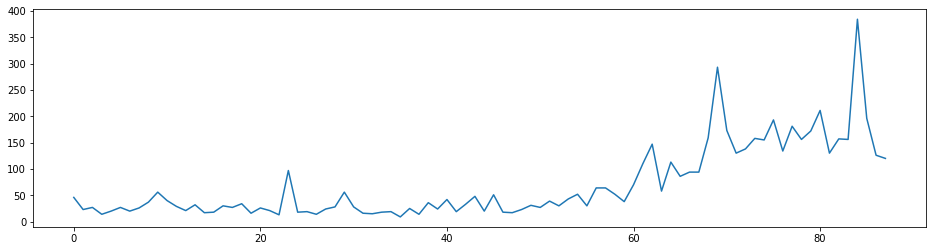

In [6]:
from src.environments.continuous.inverted_pendulum import environment

agent= SoftActorCriticAgent(environment)
agent.learn(log_each_n_episodes=10, success_threshold=100)

In [8]:
from src.environments.continuous.inverted_pendulum import environment
agent.env = environment()
agent.test()

Episode * 165.0 * Score ==> 0.000
Episode * 153.0 * Score ==> 1.000
Episode * 156.0 * Score ==> 2.000
Episode * 144.0 * Score ==> 3.000
Episode * 149.0 * Score ==> 4.000
Episode * 140.0 * Score ==> 5.000
Episode * 199.0 * Score ==> 6.000
Episode * 177.0 * Score ==> 7.000
Episode * 276.0 * Score ==> 8.000
Episode * 155.0 * Score ==> 9.000
